In [ ]:
from __future__ import print_function
import argparse
import datetime
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from IPython.display import clear_output
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.utils import save_image
from torch.autograd import Variable
from torch.utils.data import SubsetRandomSampler

In [ ]:
!pip install google collab

  Preparing metadata (setup.py) ... done
  Created wheel for collab: filename=collab-1.0.198-py3-none-any.whl size=20105 sha256=234a9ecdf3dd590166d74019c43a1c76bd6e15722cf2543e22cb190d2a4a82de
  Stored in directory: /root/.cache/pip/wheels/f5/e1/3d/bac4201cfa08172837cb6af844d04d61d5139906ec312ac09f
Successfully built collab


In [ ]:
# class netG(nn.Module):

#     def __init__(self, nz, ngf, nc):

#         super(netG, self).__init__()
#         self.ReLU = nn.ReLU(True)
#         self.Tanh = nn.Tanh()
#         self.DropOut = nn.Dropout(p=0.75)
#         #self.conv0 = nn.ConvTranspose2d(nz, ngf * 16, 4, 1, 1, bias=False)
#         #self.BatchNorm0 = nn.BatchNorm2d(ngf * 16)
#         self.conv1 = nn.ConvTranspose2d(nz, ngf * 8, 5, 1, 0, bias=False)
#         self.BatchNorm1 = nn.BatchNorm2d(ngf * 8)

#         self.conv2 = nn.ConvTranspose2d(ngf * 8, ngf * 4, 5, 2, 2, bias=False)
#         self.BatchNorm2 = nn.BatchNorm2d(ngf * 4)

#         self.conv3 = nn.ConvTranspose2d(ngf * 4, ngf * 2, 5, 2, 2, bias=False)
#         self.BatchNorm3 = nn.BatchNorm2d(ngf * 2)

#         self.conv4 = nn.ConvTranspose2d(ngf * 2, ngf * 1, 4, 2, 2, bias=False)
#         self.BatchNorm4 = nn.BatchNorm2d(ngf * 1)

#         self.conv5 = nn.ConvTranspose2d(ngf * 1, nc, 4, 2, 1, bias=False)

#         self.apply(weights_init)


#     def forward(self, input):
#         #x = self.conv0(input)
#         #x = self.BatchNorm0(x)
#         #x = self.ReLU(x)
#         x = self.conv1(input)
#         x = self.BatchNorm1(x)
#         x = self.ReLU(x)
#         #x = self.DropOut(x)

#         x = self.conv2(x)
#         x = self.BatchNorm2(x)
#         x = self.ReLU(x)
#         x = self.DropOut(x)

#         x = self.conv3(x)
#         x = self.BatchNorm3(x)
#         x = self.ReLU(x)
#         #x = self.DropOut(x)

#         x = self.conv4(x)
#         x = self.BatchNorm4(x)
#         x = self.ReLU(x)
#         #x = self.DropOut(x)

#         x = self.conv5(x)
#         output = self.Tanh(x)
#         return output

In [ ]:
class netG(nn.Module):
  """
    Generator network for a Deep Convolutional GAN (DCGAN).

    Args:
        nz (int): Size of the latent vector (input noise dimension).
        ngf (int): Number of generator feature maps.
        nc (int): Number of channels in the output image (e.g., 3 for RGB).

    Architecture:
        - Series of ConvTranspose2d layers with BatchNorm and ReLU activations.
        - Final output uses Tanh activation to generate images in range [-1, 1].
    """

    def __init__(self, nz, ngf, nc):

        super(netG, self).__init__()
        self.ReLU = nn.ReLU(True)
        self.Tanh = nn.Tanh()
        #self.DropOut = nn.Dropout(p=0.75)
        #self.conv0 = nn.ConvTranspose2d(nz, ngf * 16, 4, 1, 1, bias=False)
        #self.BatchNorm0 = nn.BatchNorm2d(ngf * 16)
        self.conv1 = nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False)
        self.BatchNorm1 = nn.BatchNorm2d(ngf * 8)

        self.conv2 = nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False)
        self.BatchNorm2 = nn.BatchNorm2d(ngf * 4)

        self.conv3 = nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False)
        self.BatchNorm3 = nn.BatchNorm2d(ngf * 2)

        self.conv4 = nn.ConvTranspose2d(ngf * 2, ngf * 1, 4, 2, 1, bias=False)
        self.BatchNorm4 = nn.BatchNorm2d(ngf * 1)

        self.conv5 = nn.ConvTranspose2d(ngf * 1, nc, 4, 2, 1, bias=False)

        self.apply(weights_init)


    def forward(self, input):
        #x = self.conv0(input)
        #x = self.BatchNorm0(x)
        #x = self.ReLU(x)
        x = self.conv1(input)
        x = self.BatchNorm1(x)
        x = self.ReLU(x)
        #x = self.DropOut(x)

        x = self.conv2(x)
        x = self.BatchNorm2(x)
        x = self.ReLU(x)
        #x = self.DropOut(x)

        x = self.conv3(x)
        x = self.BatchNorm3(x)
        x = self.ReLU(x)
        #x = self.DropOut(x)

        x = self.conv4(x)
        x = self.BatchNorm4(x)
        x = self.ReLU(x)
        #x = self.DropOut(x)

        x = self.conv5(x)
        output = self.Tanh(x)
        return output

In [ ]:
class netD(nn.Module):

    def __init__(self, ndf, nc, nb_label):

        super(netD, self).__init__()
        self.LeakyReLU = nn.LeakyReLU(0.2, inplace=True)
        self.DropOut1 = nn.Dropout(p=0.5)
        self.DropOut2 = nn.Dropout(p=0.25)
        self.conv1 = nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)
        self.conv2 = nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)
        self.BatchNorm2 = nn.BatchNorm2d(ndf * 2)
        self.conv3 = nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)
        self.BatchNorm3 = nn.BatchNorm2d(ndf * 4)
        self.conv4 = nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)
        self.BatchNorm4 = nn.BatchNorm2d(ndf * 8)
        self.conv5 = nn.Conv2d(ndf * 8, ndf * 1, 4, 1, 0, bias=False)
        self.disc_linear = nn.Linear(ndf * 1, 1)
        self.aux_linear = nn.Linear(ndf * 1, nb_label)
        self.softmax = nn.Softmax()
        self.sigmoid = nn.Sigmoid()
        self.ndf = ndf
        self.apply(weights_init)

    def forward(self, input):

        x = self.conv1(input)
        x = self.LeakyReLU(x)
        x = self.DropOut1(x)

        x = self.conv2(x)
        x = self.BatchNorm2(x)
        x = self.LeakyReLU(x)
        #x = self.DropOut(x)

        x = self.conv3(x)
        x = self.BatchNorm3(x)
        x = self.LeakyReLU(x)
        x = self.DropOut1(x)

        x = self.conv4(x)
        x = self.BatchNorm4(x)
        x = self.LeakyReLU(x)
        x = self.DropOut2(x)

        x = self.conv5(x)
        x = x.view(-1, self.ndf * 1)
        c = self.aux_linear(x)
        c = self.softmax(c)
        s = self.disc_linear(x)
        s = self.sigmoid(s)
        return s,c

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#data_dir = '4/3AHDbc50wauQLH_Uxb1lOAm9fH5_nZ8o_gvOQGzGEebKG_8SK7yvan4div2k' #Just to check
data_dir = 'Thyroid data/DU'
batch_size = 16
# Number of training epochs
num_epochs = 200

#All images will be resized to this size using a transformer.
#image_size = 64
imageSize = 64

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# No of labels
nb_label = 1

# Learning rate for optimizers
lr = 0.0001
lr_d = 0.0002
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Beta2 hyperparam for Adam optimizers
beta2 = 0.999

real_label = 1.
fake_label = 0.
# Input to generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device) #batch of 64
# Define Loss function
s_criterion = nn.BCELoss().to(device) #For synthesizing
c_criterion = nn.NLLLoss().to(device) #For classification

input = torch.FloatTensor(batch_size, 1, imageSize, imageSize).to(device)
noise = torch.FloatTensor(batch_size, nz, 1, 1).to(device)
fixed_noise = torch.FloatTensor(batch_size, nz, 1, 1).normal_(0, 1).to(device)
s_label = torch.FloatTensor(batch_size).to(device)
c_label = torch.LongTensor(batch_size).to(device)

input = Variable(input)
s_label = Variable(s_label)
c_label = Variable(c_label)
noise = Variable(noise)
fixed_noise = Variable(fixed_noise)
fixed_noise_ = np.random.normal(0, 1, (batch_size, nz))
random_label = np.random.randint(0, nb_label, batch_size)
#print('fixed label:{}'.format(random_label))
random_onehot = np.zeros((batch_size, nb_label))
random_onehot[np.arange(batch_size), random_label] = 1
fixed_noise_[np.arange(batch_size), :nb_label] = random_onehot[np.arange(batch_size)]


fixed_noise_ = (torch.from_numpy(fixed_noise_))
fixed_noise_ = fixed_noise_.resize_(batch_size, nz, 1, 1)
fixed_noise.data.copy_(fixed_noise_)

tensor([[[[ 1.0000]],

         [[-0.2938]],

         [[-0.1095]],

         ...,

         [[ 1.4524]],

         [[ 0.0555]],

         [[-0.4761]]],


        [[[ 1.0000]],

         [[-0.0201]],

         [[ 0.5902]],

         ...,

         [[-0.2888]],

         [[-1.4441]],

         [[ 1.1723]]],


        [[[ 1.0000]],

         [[-0.3460]],

         [[-1.9572]],

         ...,

         [[ 1.4825]],

         [[ 0.0186]],

         [[ 0.2146]]],


        ...,


        [[[ 1.0000]],

         [[-0.5814]],

         [[-0.2275]],

         ...,

         [[-2.0965]],

         [[-0.3329]],

         [[ 0.4041]]],


        [[[ 1.0000]],

         [[-0.5101]],

         [[-0.6014]],

         ...,

         [[ 0.1217]],

         [[ 2.5731]],

         [[-1.1908]]],


        [[[ 1.0000]],

         [[ 1.1910]],

         [[ 0.8181]],

         ...,

         [[-1.4788]],

         [[-0.7645]],

         [[ 0.8489]]]], device='cuda:0')

In [ ]:
for func in [
    lambda: os.mkdir(os.path.join('.', 'augGAN')),
    lambda: os.mkdir(os.path.join('.', 'augGAN/model/ACGAN')),
    lambda: os.mkdir(os.path.join('.', 'augGAN/plots/ACGAN')),
    lambda: os.mkdir(os.path.join('.', 'augGAN/output_images/ACGAN'))]:  # create directories
  try:
    func()
  except Exception as error:
    print(error)
    continue

METRIC_FIELDS = [
    'train.D_x',
    'train.D_G_z1',
    'train.D_G_z2',
    'train.G_losses',
    'train.D_losses',
]
metrics = {field: list() for field in METRIC_FIELDS}

if nc==1:
    mu = (0.5)
    sigma = (0.5)
    transform = transforms.Compose([#transforms.RandomHorizontalFlip(),
                                    transforms.Grayscale(num_output_channels=1),
                                    transforms.Resize((64,64)),
                                    #transforms.Scale(imageSize),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mu, sigma)])
elif nc==3:
    mu = (0.5,0.5,0.5)
    sigma = (0.5,0.5,0.5)
    #Originally authors used just scaling
    transform = transforms.Compose([#transforms.RandomHorizontalFlip(),
                                    transforms.Resize((64,64)),
                                    #transforms.Scale(imageSize),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mu, sigma)])
else:
    print("Tranformation not defined for this option")
train_set = datasets.ImageFolder(os.path.join(data_dir, "Train/"), transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True)

generator = netG(nz, ngf, nc).to(device)
discriminator = netD(ndf, nc, nb_label).to(device)

# setup optimizer
optimizerD = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(beta1, beta2))
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))

[Errno 17] File exists: './augGAN'
[Errno 17] File exists: './augGAN/model/ACGAN'
[Errno 17] File exists: './augGAN/plots/ACGAN'
[Errno 17] File exists: './augGAN/output_images/ACGAN'


In [ ]:
print(generator)
print(discriminator)

from torchsummary import summary

summary(generator, (100, 1, 1))
summary(discriminator, (1, 64, 64))

netG(
  (ReLU): ReLU(inplace=True)
  (Tanh): Tanh()
  (conv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (BatchNorm1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (BatchNorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (BatchNorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (BatchNorm4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)
netD(
  (LeakyReLU): LeakyReLU(negative_slope=0.2, inplace=True)
  (DropOut1): 

In [ ]:
def test(predict, labels):
    correct = 0
    pred = predict.data.max(1)[1]
    correct = pred.eq(labels.data).cpu().sum()
    return correct, len(labels.data)

In [ ]:
for epoch in range(num_epochs):
    for i, data in enumerate(tqdm(train_loader, 0)):
        ###########################
        # (1) Update D network
        ###########################
        # train with real
        discriminator.zero_grad()
        img, label = data
        batch_size = img.size(0)
        with torch.no_grad():
            input.resize_(img.size()).copy_(img)
            s_label.resize_(batch_size).fill_(real_label)
            c_label.resize_(batch_size).copy_(label)
        s_output, c_output = discriminator(input)

        s_label = s_label.unsqueeze(1) # Add an extra dimension to s_label
        s_errD_real = s_criterion(s_output, s_label)
        c_errD_real = c_criterion(c_output, c_label)
        errD_real = s_errD_real + c_errD_real
        errD_real.backward()
        D_x = s_output.data.mean()

        correct, length = test(c_output, c_label)

        # train with fake
        with torch.no_grad():
            noise.resize_(batch_size, nz, 1, 1)
            noise.normal_(0, 1)

        label = np.random.randint(0, nb_label, batch_size)
        noise_ = np.random.normal(0, 1, (batch_size, nz))
        label_onehot = np.zeros((batch_size, nb_label))
        label_onehot[np.arange(batch_size), label] = 1
        noise_[np.arange(batch_size), :nb_label] = label_onehot[np.arange(batch_size)]

        noise_ = (torch.from_numpy(noise_))
        noise_ = noise_.resize_(batch_size, nz, 1, 1)
        noise.data.copy_(noise_)

        c_label.data.resize_(batch_size).copy_(torch.from_numpy(label))

        fake = generator(noise)
        s_label.data.fill_(fake_label)
        s_output,c_output = discriminator(fake.detach())
        s_errD_fake = s_criterion(s_output, s_label)
        c_errD_fake = c_criterion(c_output, c_label)
        errD_fake = s_errD_fake + c_errD_fake

        errD_fake.backward()
        D_G_z1 = s_output.data.mean()
        errD = s_errD_real + s_errD_fake
        optimizerD.step()

        ###########################
        # (2) Update G network
        ###########################
        generator.zero_grad()
        s_label.data.fill_(real_label)  # fake labels are real for generator cost
        s_output,c_output = discriminator(fake)
        s_errG = s_criterion(s_output, s_label)
        c_errG = c_criterion(c_output, c_label)

        errG = s_errG + c_errG
        errG.backward()
        D_G_z2 = s_output.data.mean()
        optimizerG.step()
        metrics['train.G_losses'].append(errG.item())
        metrics['train.D_losses'].append(errD.item())

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f, Accuracy: %.4f / %.4f = %.4f'
              % (epoch, num_epochs, i, len(train_loader),
                 errD.data, errG.data, D_x, D_G_z1, D_G_z2,
                 correct, length, 100.* correct / length))
        if i % 100 == 0:
            vutils.save_image(img,
                    '%s/real_samples.png' % './augGAN/output_images/ACGAN', normalize=True)
            #fake = netG(fixed_cat)
            fake = generator(fixed_noise)
            vutils.save_image(fake.data,
                    '%s/fake_samples_epoch_%03d.png' % ('./augGAN/output_images/ACGAN', epoch), normalize=True)

    # do checkpointing
    #torch.save(generator.state_dict(), '%s/netG_epoch_%d.pth' % (os.path.join('.', 'augGAN/model/ACGAN'), epoch))
    #torch.save(discriminator.state_dict(), '%s/netD_epoch_%d.pth' % (os.path.join('.', 'augGAN/model/ACGAN'), epoch))

 29%|██▊       | 2/7 [00:00<00:00,  6.01it/s]

[0/200][0/7] Loss_D: 1.7099 Loss_G: -0.4005 D(x): 0.3214 D(G(z)): 0.3350 / 0.5876, Accuracy: 16.0000 / 16.0000 = 100.0000
[0/200][1/7] Loss_D: 1.3143 Loss_G: -0.1612 D(x): 0.7336 D(G(z)): 0.5966 / 0.4785, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  7.47it/s]

[0/200][2/7] Loss_D: 1.0941 Loss_G: 0.8731 D(x): 0.7193 D(G(z)): 0.4753 / 0.1884, Accuracy: 16.0000 / 16.0000 = 100.0000
[0/200][3/7] Loss_D: 1.0121 Loss_G: 0.9891 D(x): 0.5714 D(G(z)): 0.2847 / 0.1752, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.24it/s]


[0/200][4/7] Loss_D: 0.8716 Loss_G: 0.4491 D(x): 0.6002 D(G(z)): 0.2226 / 0.2637, Accuracy: 16.0000 / 16.0000 = 100.0000
[0/200][5/7] Loss_D: 0.9003 Loss_G: 0.3518 D(x): 0.6578 D(G(z)): 0.3178 / 0.3056, Accuracy: 16.0000 / 16.0000 = 100.0000
[0/200][6/7] Loss_D: 1.2208 Loss_G: 0.4310 D(x): 0.7805 D(G(z)): 0.5396 / 0.2575, Accuracy: 3.0000 / 3.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.10it/s]

[1/200][0/7] Loss_D: 0.6525 Loss_G: 0.8780 D(x): 0.7368 D(G(z)): 0.2595 / 0.1901, Accuracy: 16.0000 / 16.0000 = 100.0000
[1/200][1/7] Loss_D: 0.5630 Loss_G: 0.8684 D(x): 0.7790 D(G(z)): 0.2311 / 0.1884, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.37it/s]

[1/200][2/7] Loss_D: 0.6148 Loss_G: 1.2946 D(x): 0.8069 D(G(z)): 0.2880 / 0.1343, Accuracy: 16.0000 / 16.0000 = 100.0000
[1/200][3/7] Loss_D: 0.6166 Loss_G: 0.9489 D(x): 0.7478 D(G(z)): 0.1814 / 0.1774, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.95it/s]


[1/200][4/7] Loss_D: 0.5788 Loss_G: 0.7985 D(x): 0.7601 D(G(z)): 0.2251 / 0.2176, Accuracy: 16.0000 / 16.0000 = 100.0000
[1/200][5/7] Loss_D: 0.6301 Loss_G: 0.9540 D(x): 0.7527 D(G(z)): 0.2524 / 0.1673, Accuracy: 16.0000 / 16.0000 = 100.0000
[1/200][6/7] Loss_D: 0.4464 Loss_G: 0.6582 D(x): 0.8151 D(G(z)): 0.1820 / 0.1907, Accuracy: 3.0000 / 3.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.78it/s]

[2/200][0/7] Loss_D: 0.4813 Loss_G: 1.1266 D(x): 0.9043 D(G(z)): 0.2928 / 0.1609, Accuracy: 16.0000 / 16.0000 = 100.0000
[2/200][1/7] Loss_D: 0.5830 Loss_G: 1.4267 D(x): 0.8202 D(G(z)): 0.2458 / 0.1233, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.28it/s]

[2/200][2/7] Loss_D: 0.6636 Loss_G: 1.1688 D(x): 0.6971 D(G(z)): 0.1425 / 0.1631, Accuracy: 16.0000 / 16.0000 = 100.0000
[2/200][3/7] Loss_D: 0.8240 Loss_G: 1.0817 D(x): 0.7183 D(G(z)): 0.2578 / 0.1542, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.35it/s]


[2/200][4/7] Loss_D: 0.6821 Loss_G: 0.4090 D(x): 0.6993 D(G(z)): 0.2173 / 0.2888, Accuracy: 16.0000 / 16.0000 = 100.0000
[2/200][5/7] Loss_D: 0.8820 Loss_G: 1.8455 D(x): 0.8718 D(G(z)): 0.4645 / 0.0767, Accuracy: 16.0000 / 16.0000 = 100.0000
[2/200][6/7] Loss_D: 1.3386 Loss_G: 2.6464 D(x): 0.6763 D(G(z)): 0.3305 / 0.0369, Accuracy: 3.0000 / 3.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.36it/s]

[3/200][0/7] Loss_D: 0.4013 Loss_G: 1.9639 D(x): 0.8103 D(G(z)): 0.0797 / 0.0734, Accuracy: 16.0000 / 16.0000 = 100.0000
[3/200][1/7] Loss_D: 0.6453 Loss_G: 0.6736 D(x): 0.6254 D(G(z)): 0.0674 / 0.2343, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.66it/s]

[3/200][2/7] Loss_D: 0.4539 Loss_G: 0.9775 D(x): 0.9018 D(G(z)): 0.2732 / 0.1939, Accuracy: 16.0000 / 16.0000 = 100.0000
[3/200][3/7] Loss_D: 0.5950 Loss_G: 1.6998 D(x): 0.8728 D(G(z)): 0.2817 / 0.0940, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.28it/s]


[3/200][4/7] Loss_D: 0.3368 Loss_G: 2.6437 D(x): 0.8664 D(G(z)): 0.1625 / 0.0335, Accuracy: 16.0000 / 16.0000 = 100.0000
[3/200][5/7] Loss_D: 0.4306 Loss_G: 1.9814 D(x): 0.7545 D(G(z)): 0.1085 / 0.0916, Accuracy: 16.0000 / 16.0000 = 100.0000
[3/200][6/7] Loss_D: 0.3648 Loss_G: 1.4949 D(x): 0.7798 D(G(z)): 0.0852 / 0.0827, Accuracy: 3.0000 / 3.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.13it/s]

[4/200][0/7] Loss_D: 0.4510 Loss_G: 1.7553 D(x): 0.9002 D(G(z)): 0.2541 / 0.0908, Accuracy: 16.0000 / 16.0000 = 100.0000
[4/200][1/7] Loss_D: 0.2822 Loss_G: 2.7079 D(x): 0.9198 D(G(z)): 0.1663 / 0.0351, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  9.10it/s]

[4/200][2/7] Loss_D: 0.5525 Loss_G: 2.6074 D(x): 0.7632 D(G(z)): 0.1763 / 0.0362, Accuracy: 16.0000 / 16.0000 = 100.0000
[4/200][3/7] Loss_D: 0.3510 Loss_G: 2.0304 D(x): 0.8393 D(G(z)): 0.0984 / 0.0811, Accuracy: 16.0000 / 16.0000 = 100.0000
[4/200][4/7] Loss_D: 0.3103 Loss_G: 1.2614 D(x): 0.8876 D(G(z)): 0.0794 / 0.1562, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.67it/s]


[4/200][5/7] Loss_D: 0.3258 Loss_G: 2.4565 D(x): 0.9636 D(G(z)): 0.2356 / 0.0502, Accuracy: 16.0000 / 16.0000 = 100.0000
[4/200][6/7] Loss_D: 0.3267 Loss_G: 2.1035 D(x): 0.8804 D(G(z)): 0.1728 / 0.0676, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[5/200][0/7] Loss_D: 0.3314 Loss_G: 2.2681 D(x): 0.8265 D(G(z)): 0.0851 / 0.0556, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.28it/s]

[5/200][1/7] Loss_D: 0.3450 Loss_G: 2.4625 D(x): 0.8603 D(G(z)): 0.1065 / 0.0468, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  8.19it/s]

[5/200][2/7] Loss_D: 0.4432 Loss_G: 1.3076 D(x): 0.7771 D(G(z)): 0.1070 / 0.1365, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.27it/s]

[5/200][3/7] Loss_D: 0.3229 Loss_G: 1.3407 D(x): 0.9206 D(G(z)): 0.1689 / 0.1236, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.62it/s]

[5/200][4/7] Loss_D: 0.3952 Loss_G: 2.4246 D(x): 0.8766 D(G(z)): 0.1916 / 0.0395, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.21it/s]


[5/200][5/7] Loss_D: 0.2097 Loss_G: 2.6766 D(x): 0.8966 D(G(z)): 0.0861 / 0.0395, Accuracy: 16.0000 / 16.0000 = 100.0000
[5/200][6/7] Loss_D: 0.0806 Loss_G: 3.1356 D(x): 0.9619 D(G(z)): 0.0401 / 0.0280, Accuracy: 3.0000 / 3.0000 = 100.0000


 14%|█▍        | 1/7 [00:00<00:00,  6.37it/s]

[6/200][0/7] Loss_D: 0.3352 Loss_G: 2.6212 D(x): 0.8373 D(G(z)): 0.1039 / 0.0448, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.54it/s]

[6/200][1/7] Loss_D: 0.1730 Loss_G: 2.0907 D(x): 0.9277 D(G(z)): 0.0793 / 0.0687, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  8.05it/s]

[6/200][2/7] Loss_D: 0.3212 Loss_G: 2.4017 D(x): 0.8521 D(G(z)): 0.0972 / 0.0466, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.69it/s]

[6/200][3/7] Loss_D: 0.2843 Loss_G: 2.4874 D(x): 0.9134 D(G(z)): 0.1578 / 0.0536, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.73it/s]

[6/200][4/7] Loss_D: 0.1678 Loss_G: 3.4633 D(x): 0.9520 D(G(z)): 0.1023 / 0.0188, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.19it/s]


[6/200][5/7] Loss_D: 0.3578 Loss_G: 2.8026 D(x): 0.7916 D(G(z)): 0.0507 / 0.0346, Accuracy: 16.0000 / 16.0000 = 100.0000
[6/200][6/7] Loss_D: 0.6457 Loss_G: 3.1501 D(x): 0.8145 D(G(z)): 0.2631 / 0.0309, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[7/200][0/7] Loss_D: 0.4163 Loss_G: 2.9519 D(x): 0.8358 D(G(z)): 0.1088 / 0.0612, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  6.52it/s]

[7/200][1/7] Loss_D: 0.1987 Loss_G: 4.0053 D(x): 0.9517 D(G(z)): 0.1198 / 0.0100, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.12it/s]

[7/200][2/7] Loss_D: 0.1901 Loss_G: 3.7338 D(x): 0.8820 D(G(z)): 0.0475 / 0.0141, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  7.07it/s]

[7/200][3/7] Loss_D: 0.1098 Loss_G: 3.7389 D(x): 0.9738 D(G(z)): 0.0761 / 0.0188, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  7.34it/s]

[7/200][4/7] Loss_D: 0.2070 Loss_G: 2.9352 D(x): 0.9155 D(G(z)): 0.0900 / 0.0260, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  7.97it/s]


[7/200][5/7] Loss_D: 0.2965 Loss_G: 2.3824 D(x): 0.8946 D(G(z)): 0.1260 / 0.0627, Accuracy: 16.0000 / 16.0000 = 100.0000
[7/200][6/7] Loss_D: 0.3131 Loss_G: 2.2558 D(x): 0.8129 D(G(z)): 0.0919 / 0.0459, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[8/200][0/7] Loss_D: 0.4280 Loss_G: 4.0287 D(x): 0.9476 D(G(z)): 0.2798 / 0.0096, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.43it/s]

[8/200][1/7] Loss_D: 0.1120 Loss_G: 4.5276 D(x): 0.9213 D(G(z)): 0.0186 / 0.0082, Accuracy: 16.0000 / 16.0000 = 100.0000
[8/200][2/7] Loss_D: 0.1408 Loss_G: 3.8637 D(x): 0.9073 D(G(z)): 0.0361 / 0.0196, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  7.94it/s]

[8/200][3/7] Loss_D: 0.2803 Loss_G: 3.2099 D(x): 0.8485 D(G(z)): 0.0800 / 0.0214, Accuracy: 16.0000 / 16.0000 = 100.0000
[8/200][4/7] Loss_D: 0.1551 Loss_G: 3.6343 D(x): 0.9503 D(G(z)): 0.0917 / 0.0171, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.15it/s]


[8/200][5/7] Loss_D: 0.1993 Loss_G: 3.6377 D(x): 0.9158 D(G(z)): 0.0812 / 0.0153, Accuracy: 16.0000 / 16.0000 = 100.0000
[8/200][6/7] Loss_D: 0.0606 Loss_G: 4.0866 D(x): 0.9921 D(G(z)): 0.0510 / 0.0063, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[9/200][0/7] Loss_D: 0.0737 Loss_G: 3.2094 D(x): 0.9557 D(G(z)): 0.0254 / 0.0343, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  6.88it/s]

[9/200][1/7] Loss_D: 0.0642 Loss_G: 3.4287 D(x): 0.9787 D(G(z)): 0.0396 / 0.0180, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.32it/s]

[9/200][2/7] Loss_D: 0.0920 Loss_G: 3.3589 D(x): 0.9774 D(G(z)): 0.0644 / 0.0257, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.05it/s]

[9/200][3/7] Loss_D: 0.1071 Loss_G: 4.0473 D(x): 0.9796 D(G(z)): 0.0790 / 0.0112, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.50it/s]

[9/200][4/7] Loss_D: 0.1986 Loss_G: 4.8051 D(x): 0.9161 D(G(z)): 0.0799 / 0.0081, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.72it/s]


[9/200][5/7] Loss_D: 0.0813 Loss_G: 4.0138 D(x): 0.9517 D(G(z)): 0.0282 / 0.0116, Accuracy: 16.0000 / 16.0000 = 100.0000
[9/200][6/7] Loss_D: 0.0554 Loss_G: 3.2849 D(x): 0.9772 D(G(z)): 0.0312 / 0.0145, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[10/200][0/7] Loss_D: 0.0733 Loss_G: 2.7202 D(x): 0.9639 D(G(z)): 0.0325 / 0.0364, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  6.43it/s]

[10/200][1/7] Loss_D: 0.2033 Loss_G: 3.7314 D(x): 0.9461 D(G(z)): 0.1058 / 0.0180, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  6.86it/s]

[10/200][2/7] Loss_D: 0.0935 Loss_G: 3.6160 D(x): 0.9602 D(G(z)): 0.0460 / 0.0194, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  7.39it/s]

[10/200][3/7] Loss_D: 0.0598 Loss_G: 4.3447 D(x): 0.9703 D(G(z)): 0.0274 / 0.0072, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  7.39it/s]

[10/200][4/7] Loss_D: 0.0756 Loss_G: 3.4487 D(x): 0.9558 D(G(z)): 0.0279 / 0.0278, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.00it/s]


[10/200][5/7] Loss_D: 0.1883 Loss_G: 3.7408 D(x): 0.9138 D(G(z)): 0.0733 / 0.0169, Accuracy: 16.0000 / 16.0000 = 100.0000
[10/200][6/7] Loss_D: 5.6729 Loss_G: -0.1707 D(x): 0.0064 D(G(z)): 0.0506 / 0.4418, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[11/200][0/7] Loss_D: 1.3430 Loss_G: 8.1606 D(x): 0.9843 D(G(z)): 0.6893 / 0.0003, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.46it/s]

[11/200][1/7] Loss_D: 0.0239 Loss_G: 11.6029 D(x): 0.9781 D(G(z)): 0.0007 / 0.0000, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.68it/s]

[11/200][2/7] Loss_D: 0.1562 Loss_G: 10.1976 D(x): 0.8755 D(G(z)): 0.0001 / 0.0000, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.12it/s]

[11/200][3/7] Loss_D: 0.1301 Loss_G: 7.2299 D(x): 0.8910 D(G(z)): 0.0005 / 0.0005, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.45it/s]

[11/200][4/7] Loss_D: 0.0130 Loss_G: 3.9619 D(x): 0.9951 D(G(z)): 0.0081 / 0.0163, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.10it/s]


[11/200][5/7] Loss_D: 0.4155 Loss_G: 4.6481 D(x): 0.9928 D(G(z)): 0.2949 / 0.0071, Accuracy: 16.0000 / 16.0000 = 100.0000
[11/200][6/7] Loss_D: 0.0293 Loss_G: 4.5670 D(x): 0.9988 D(G(z)): 0.0276 / 0.0138, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[12/200][0/7] Loss_D: 0.3286 Loss_G: 4.9767 D(x): 0.9302 D(G(z)): 0.1870 / 0.0077, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.26it/s]

[12/200][1/7] Loss_D: 0.2367 Loss_G: 5.9128 D(x): 0.8994 D(G(z)): 0.0993 / 0.0031, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.84it/s]

[12/200][2/7] Loss_D: 0.1867 Loss_G: 4.6486 D(x): 0.8689 D(G(z)): 0.0279 / 0.0091, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  7.89it/s]

[12/200][3/7] Loss_D: 0.1729 Loss_G: 3.6682 D(x): 0.8930 D(G(z)): 0.0431 / 0.0162, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.07it/s]

[12/200][4/7] Loss_D: 0.4224 Loss_G: 5.4051 D(x): 0.8940 D(G(z)): 0.2108 / 0.0040, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.81it/s]


[12/200][5/7] Loss_D: 0.1316 Loss_G: 5.0885 D(x): 0.9187 D(G(z)): 0.0341 / 0.0043, Accuracy: 16.0000 / 16.0000 = 100.0000
[12/200][6/7] Loss_D: 0.0785 Loss_G: 4.4429 D(x): 0.9393 D(G(z)): 0.0125 / 0.0067, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[13/200][0/7] Loss_D: 0.0808 Loss_G: 3.5450 D(x): 0.9909 D(G(z)): 0.0651 / 0.0181, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.08it/s]

[13/200][1/7] Loss_D: 0.0786 Loss_G: 3.7630 D(x): 0.9890 D(G(z)): 0.0642 / 0.0205, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.84it/s]

[13/200][2/7] Loss_D: 0.1465 Loss_G: 4.1073 D(x): 0.9425 D(G(z)): 0.0697 / 0.0110, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.32it/s]

[13/200][3/7] Loss_D: 0.1573 Loss_G: 5.3926 D(x): 0.9668 D(G(z)): 0.1000 / 0.0026, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.65it/s]

[13/200][4/7] Loss_D: 0.0357 Loss_G: 5.4288 D(x): 0.9741 D(G(z)): 0.0077 / 0.0054, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.04it/s]


[13/200][5/7] Loss_D: 0.0498 Loss_G: 5.0644 D(x): 0.9604 D(G(z)): 0.0082 / 0.0039, Accuracy: 16.0000 / 16.0000 = 100.0000
[13/200][6/7] Loss_D: 0.3976 Loss_G: 4.0157 D(x): 0.7895 D(G(z)): 0.0991 / 0.0154, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[14/200][0/7] Loss_D: 0.0518 Loss_G: 4.5432 D(x): 0.9771 D(G(z)): 0.0271 / 0.0091, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.18it/s]

[14/200][1/7] Loss_D: 0.0551 Loss_G: 4.7180 D(x): 0.9820 D(G(z)): 0.0347 / 0.0091, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.86it/s]

[14/200][2/7] Loss_D: 0.0552 Loss_G: 3.5866 D(x): 0.9816 D(G(z)): 0.0347 / 0.0187, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  7.75it/s]

[14/200][3/7] Loss_D: 0.1340 Loss_G: 4.3742 D(x): 0.9684 D(G(z)): 0.0837 / 0.0120, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  7.88it/s]

[14/200][4/7] Loss_D: 0.0940 Loss_G: 4.9072 D(x): 0.9756 D(G(z)): 0.0636 / 0.0068, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.60it/s]


[14/200][5/7] Loss_D: 0.0758 Loss_G: 5.9839 D(x): 0.9828 D(G(z)): 0.0516 / 0.0020, Accuracy: 16.0000 / 16.0000 = 100.0000
[14/200][6/7] Loss_D: 0.2771 Loss_G: 3.4187 D(x): 0.7886 D(G(z)): 0.0216 / 0.0357, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[15/200][0/7] Loss_D: 0.1449 Loss_G: 3.7203 D(x): 0.9817 D(G(z)): 0.1126 / 0.0148, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.10it/s]

[15/200][1/7] Loss_D: 0.0753 Loss_G: 5.0148 D(x): 0.9858 D(G(z)): 0.0548 / 0.0065, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.86it/s]

[15/200][2/7] Loss_D: 0.2307 Loss_G: 5.5842 D(x): 0.9254 D(G(z)): 0.0376 / 0.0029, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.22it/s]

[15/200][3/7] Loss_D: 0.0504 Loss_G: 3.3396 D(x): 0.9663 D(G(z)): 0.0131 / 0.0193, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.49it/s]

[15/200][4/7] Loss_D: 0.0577 Loss_G: 4.7506 D(x): 0.9923 D(G(z)): 0.0463 / 0.0098, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.90it/s]


[15/200][5/7] Loss_D: 0.0715 Loss_G: 4.8706 D(x): 0.9837 D(G(z)): 0.0510 / 0.0058, Accuracy: 16.0000 / 16.0000 = 100.0000
[15/200][6/7] Loss_D: 0.0341 Loss_G: 4.2466 D(x): 0.9857 D(G(z)): 0.0194 / 0.0097, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[16/200][0/7] Loss_D: 0.0550 Loss_G: 4.7276 D(x): 0.9726 D(G(z)): 0.0259 / 0.0051, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.37it/s]

[16/200][1/7] Loss_D: 0.0390 Loss_G: 4.7469 D(x): 0.9861 D(G(z)): 0.0243 / 0.0075, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.79it/s]

[16/200][2/7] Loss_D: 0.2372 Loss_G: 3.6907 D(x): 0.8678 D(G(z)): 0.0515 / 0.0187, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.30it/s]

[16/200][3/7] Loss_D: 0.0865 Loss_G: 5.0086 D(x): 0.9858 D(G(z)): 0.0659 / 0.0044, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.71it/s]

[16/200][4/7] Loss_D: 0.0522 Loss_G: 5.9360 D(x): 0.9860 D(G(z)): 0.0364 / 0.0018, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.15it/s]


[16/200][5/7] Loss_D: 0.2181 Loss_G: 4.3416 D(x): 0.8560 D(G(z)): 0.0095 / 0.0077, Accuracy: 16.0000 / 16.0000 = 100.0000
[16/200][6/7] Loss_D: 0.0815 Loss_G: 4.8237 D(x): 0.9735 D(G(z)): 0.0525 / 0.0232, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[17/200][0/7] Loss_D: 0.1625 Loss_G: 7.2728 D(x): 0.9930 D(G(z)): 0.1282 / 0.0004, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.28it/s]

[17/200][1/7] Loss_D: 0.0292 Loss_G: 7.3852 D(x): 0.9763 D(G(z)): 0.0040 / 0.0004, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.69it/s]

[17/200][2/7] Loss_D: 0.0547 Loss_G: 6.0815 D(x): 0.9516 D(G(z)): 0.0020 / 0.0019, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.24it/s]

[17/200][3/7] Loss_D: 0.0245 Loss_G: 4.7548 D(x): 0.9937 D(G(z)): 0.0176 / 0.0069, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.04it/s]

[17/200][4/7] Loss_D: 0.0779 Loss_G: 4.0335 D(x): 0.9595 D(G(z)): 0.0262 / 0.0154, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.85it/s]


[17/200][5/7] Loss_D: 0.0684 Loss_G: 4.7039 D(x): 0.9965 D(G(z)): 0.0598 / 0.0069, Accuracy: 16.0000 / 16.0000 = 100.0000
[17/200][6/7] Loss_D: 0.0764 Loss_G: 6.4098 D(x): 0.9934 D(G(z)): 0.0664 / 0.0008, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[18/200][0/7] Loss_D: 0.1362 Loss_G: 5.1511 D(x): 0.9193 D(G(z)): 0.0351 / 0.0097, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  6.80it/s]

[18/200][1/7] Loss_D: 0.0595 Loss_G: 4.6185 D(x): 0.9723 D(G(z)): 0.0291 / 0.0056, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.76it/s]

[18/200][2/7] Loss_D: 0.1003 Loss_G: 5.2409 D(x): 0.9899 D(G(z)): 0.0748 / 0.0059, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.28it/s]

[18/200][3/7] Loss_D: 0.1230 Loss_G: 3.7189 D(x): 0.9057 D(G(z)): 0.0083 / 0.0304, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.50it/s]

[18/200][4/7] Loss_D: 0.0858 Loss_G: 4.0123 D(x): 0.9775 D(G(z)): 0.0585 / 0.0270, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.77it/s]


[18/200][5/7] Loss_D: 0.1379 Loss_G: 4.1841 D(x): 0.9388 D(G(z)): 0.0614 / 0.0119, Accuracy: 16.0000 / 16.0000 = 100.0000
[18/200][6/7] Loss_D: 1.6409 Loss_G: -0.8547 D(x): 0.3579 D(G(z)): 0.1000 / 0.8660, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[19/200][0/7] Loss_D: 2.4962 Loss_G: 17.1457 D(x): 0.9981 D(G(z)): 0.8588 / 0.0000, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  6.89it/s]

[19/200][1/7] Loss_D: 0.4990 Loss_G: 20.1412 D(x): 0.7005 D(G(z)): 0.0000 / 0.0000, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.74it/s]

[19/200][2/7] Loss_D: 0.0391 Loss_G: 17.1777 D(x): 0.9645 D(G(z)): 0.0000 / 0.0000, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  7.90it/s]

[19/200][3/7] Loss_D: 0.2010 Loss_G: 11.1567 D(x): 0.8814 D(G(z)): 0.0000 / 0.0001, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.31it/s]

[19/200][4/7] Loss_D: 0.0902 Loss_G: 3.6937 D(x): 0.9401 D(G(z)): 0.0142 / 0.0434, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.82it/s]


[19/200][5/7] Loss_D: 1.0511 Loss_G: 13.6974 D(x): 0.9848 D(G(z)): 0.5463 / 0.0000, Accuracy: 16.0000 / 16.0000 = 100.0000
[19/200][6/7] Loss_D: 0.8098 Loss_G: 15.6159 D(x): 0.6757 D(G(z)): 0.0000 / 0.0000, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[20/200][0/7] Loss_D: 0.1672 Loss_G: 11.6769 D(x): 0.8715 D(G(z)): 0.0000 / 0.0000, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.00it/s]

[20/200][1/7] Loss_D: 0.0091 Loss_G: 8.0957 D(x): 0.9917 D(G(z)): 0.0006 / 0.0006, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.91it/s]

[20/200][2/7] Loss_D: 0.2160 Loss_G: 6.0838 D(x): 0.9773 D(G(z)): 0.1388 / 0.0022, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.58it/s]

[20/200][3/7] Loss_D: 0.2387 Loss_G: 8.8332 D(x): 0.9734 D(G(z)): 0.1599 / 0.0003, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.71it/s]

[20/200][4/7] Loss_D: 0.3018 Loss_G: 7.5481 D(x): 0.8531 D(G(z)): 0.0151 / 0.0006, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.15it/s]


[20/200][5/7] Loss_D: 0.4377 Loss_G: 2.5340 D(x): 0.7439 D(G(z)): 0.0186 / 0.0711, Accuracy: 16.0000 / 16.0000 = 100.0000
[20/200][6/7] Loss_D: 0.5686 Loss_G: 10.7521 D(x): 0.9502 D(G(z)): 0.3879 / 0.0000, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[21/200][0/7] Loss_D: 0.1442 Loss_G: 11.0754 D(x): 0.8922 D(G(z)): 0.0014 / 0.0000, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.47it/s]

[21/200][1/7] Loss_D: 0.1756 Loss_G: 7.9850 D(x): 0.8578 D(G(z)): 0.0002 / 0.0002, Accuracy: 16.0000 / 16.0000 = 100.0000
[21/200][2/7] Loss_D: 0.1633 Loss_G: 4.3070 D(x): 0.9106 D(G(z)): 0.0045 / 0.0221, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.63it/s]

[21/200][3/7] Loss_D: 0.1857 Loss_G: 5.7968 D(x): 0.9961 D(G(z)): 0.1410 / 0.0044, Accuracy: 16.0000 / 16.0000 = 100.0000


 86%|████████▌ | 6/7 [00:00<00:00,  9.23it/s]

[21/200][4/7] Loss_D: 0.0195 Loss_G: 5.4994 D(x): 0.9937 D(G(z)): 0.0129 / 0.0068, Accuracy: 16.0000 / 16.0000 = 100.0000
[21/200][5/7] Loss_D: 0.1337 Loss_G: 5.0597 D(x): 0.9174 D(G(z)): 0.0305 / 0.0081, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.63it/s]


[21/200][6/7] Loss_D: 0.0408 Loss_G: 6.5213 D(x): 0.9974 D(G(z)): 0.0372 / 0.0006, Accuracy: 3.0000 / 3.0000 = 100.0000


 14%|█▍        | 1/7 [00:00<00:00,  6.03it/s]

[22/200][0/7] Loss_D: 0.1213 Loss_G: 4.5299 D(x): 0.9452 D(G(z)): 0.0312 / 0.0166, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.84it/s]

[22/200][1/7] Loss_D: 0.1521 Loss_G: 6.5879 D(x): 0.9984 D(G(z)): 0.1151 / 0.0019, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  8.43it/s]

[22/200][2/7] Loss_D: 0.0313 Loss_G: 7.7423 D(x): 0.9717 D(G(z)): 0.0021 / 0.0003, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.74it/s]

[22/200][3/7] Loss_D: 0.0182 Loss_G: 7.2751 D(x): 0.9857 D(G(z)): 0.0036 / 0.0018, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.98it/s]

[22/200][4/7] Loss_D: 0.0274 Loss_G: 4.9553 D(x): 0.9797 D(G(z)): 0.0058 / 0.0055, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.49it/s]


[22/200][5/7] Loss_D: 0.1703 Loss_G: 3.6656 D(x): 0.9026 D(G(z)): 0.0463 / 0.0277, Accuracy: 16.0000 / 16.0000 = 100.0000
[22/200][6/7] Loss_D: 1.0014 Loss_G: 4.1238 D(x): 0.5510 D(G(z)): 0.2640 / 0.0121, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[23/200][0/7] Loss_D: 0.0285 Loss_G: 5.9903 D(x): 0.9920 D(G(z)): 0.0196 / 0.0031, Accuracy: 16.0000 / 16.0000 = 100.0000


 14%|█▍        | 1/7 [00:00<00:00,  6.10it/s]

[23/200][1/7] Loss_D: 0.0854 Loss_G: 5.6322 D(x): 0.9426 D(G(z)): 0.0206 / 0.0029, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  8.36it/s]

[23/200][2/7] Loss_D: 0.0763 Loss_G: 5.9786 D(x): 0.9996 D(G(z)): 0.0659 / 0.0054, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.81it/s]

[23/200][3/7] Loss_D: 0.0187 Loss_G: 5.6763 D(x): 0.9984 D(G(z)): 0.0164 / 0.0286, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  9.00it/s]

[23/200][4/7] Loss_D: 0.1051 Loss_G: 6.5355 D(x): 0.9944 D(G(z)): 0.0857 / 0.0014, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.28it/s]


[23/200][5/7] Loss_D: 0.2018 Loss_G: 8.2077 D(x): 0.9953 D(G(z)): 0.1088 / 0.0012, Accuracy: 16.0000 / 16.0000 = 100.0000
[23/200][6/7] Loss_D: 0.0752 Loss_G: 8.0651 D(x): 0.9998 D(G(z)): 0.0690 / 0.0003, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[24/200][0/7] Loss_D: 0.0389 Loss_G: 6.6860 D(x): 0.9962 D(G(z)): 0.0330 / 0.0089, Accuracy: 16.0000 / 16.0000 = 100.0000

 14%|█▍        | 1/7 [00:00<00:01,  4.48it/s]

 43%|████▎     | 3/7 [00:00<00:00,  6.74it/s]

[24/200][1/7] Loss_D: 0.4372 Loss_G: 10.3748 D(x): 0.9871 D(G(z)): 0.2334 / 0.0001, Accuracy: 16.0000 / 16.0000 = 100.0000
[24/200][2/7] Loss_D: 0.0738 Loss_G: 10.6659 D(x): 0.9365 D(G(z)): 0.0046 / 0.0001, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  7.24it/s]

[24/200][3/7] Loss_D: 0.4464 Loss_G: 5.6848 D(x): 0.7414 D(G(z)): 0.0035 / 0.0119, Accuracy: 16.0000 / 16.0000 = 100.0000
[24/200][4/7] Loss_D: 0.1386 Loss_G: 4.7680 D(x): 0.9829 D(G(z)): 0.1045 / 0.0312, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  7.76it/s]


[24/200][5/7] Loss_D: 0.2039 Loss_G: 6.8396 D(x): 0.9459 D(G(z)): 0.1093 / 0.0020, Accuracy: 16.0000 / 16.0000 = 100.0000
[24/200][6/7] Loss_D: 0.0149 Loss_G: 8.8089 D(x): 0.9915 D(G(z)): 0.0064 / 0.0001, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[25/200][0/7] Loss_D: 0.0166 Loss_G: 7.2506 D(x): 0.9872 D(G(z)): 0.0033 / 0.0010, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.03it/s]

[25/200][1/7] Loss_D: 0.0771 Loss_G: 6.0404 D(x): 0.9427 D(G(z)): 0.0074 / 0.0058, Accuracy: 16.0000 / 16.0000 = 100.0000
[25/200][2/7] Loss_D: 0.0145 Loss_G: 4.8542 D(x): 0.9943 D(G(z)): 0.0086 / 0.0048, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  7.68it/s]

[25/200][3/7] Loss_D: 0.0299 Loss_G: 3.8331 D(x): 0.9953 D(G(z)): 0.0244 / 0.0237, Accuracy: 16.0000 / 16.0000 = 100.0000
[25/200][4/7] Loss_D: 0.1682 Loss_G: 7.3532 D(x): 0.9886 D(G(z)): 0.1212 / 0.0007, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.06it/s]


[25/200][5/7] Loss_D: 0.0182 Loss_G: 8.7420 D(x): 0.9841 D(G(z)): 0.0017 / 0.0002, Accuracy: 16.0000 / 16.0000 = 100.0000
[25/200][6/7] Loss_D: 1.7850 Loss_G: -0.3034 D(x): 0.4790 D(G(z)): 0.0008 / 0.5682, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[26/200][0/7] Loss_D: 1.4698 Loss_G: 13.8104 D(x): 0.9997 D(G(z)): 0.6441 / 0.0000, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  6.41it/s]

[26/200][1/7] Loss_D: 0.0796 Loss_G: 14.7358 D(x): 0.9332 D(G(z)): 0.0002 / 0.0000, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.06it/s]

[26/200][2/7] Loss_D: 0.5591 Loss_G: 12.9379 D(x): 0.7195 D(G(z)): 0.0002 / 0.0001, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  6.97it/s]

[26/200][3/7] Loss_D: 0.1345 Loss_G: 7.1459 D(x): 0.9863 D(G(z)): 0.0902 / 0.0504, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  7.32it/s]

[26/200][4/7] Loss_D: 1.0699 Loss_G: 13.0662 D(x): 0.9851 D(G(z)): 0.4023 / 0.0003, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  7.90it/s]


[26/200][5/7] Loss_D: 0.3165 Loss_G: 12.8825 D(x): 0.8248 D(G(z)): 0.0030 / 0.0000, Accuracy: 16.0000 / 16.0000 = 100.0000
[26/200][6/7] Loss_D: 3.4049 Loss_G: -0.9676 D(x): 0.2817 D(G(z)): 0.0016 / 0.9688, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[27/200][0/7] Loss_D: 6.1714 Loss_G: 13.5720 D(x): 1.0000 D(G(z)): 0.9931 / 0.0000, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  6.77it/s]

[27/200][1/7] Loss_D: 0.0097 Loss_G: 20.1843 D(x): 0.9905 D(G(z)): 0.0000 / 0.0000, Accuracy: 16.0000 / 16.0000 = 100.0000
[27/200][2/7] Loss_D: 2.0977 Loss_G: 14.8222 D(x): 0.2681 D(G(z)): 0.0000 / 0.0000, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  7.50it/s]

[27/200][3/7] Loss_D: 0.0080 Loss_G: 10.7277 D(x): 0.9923 D(G(z)): 0.0001 / 0.0000, Accuracy: 16.0000 / 16.0000 = 100.0000
[27/200][4/7] Loss_D: 0.0045 Loss_G: 6.3267 D(x): 0.9980 D(G(z)): 0.0025 / 0.0051, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  7.90it/s]


[27/200][5/7] Loss_D: 0.1484 Loss_G: 6.1072 D(x): 0.9597 D(G(z)): 0.0871 / 0.0105, Accuracy: 16.0000 / 16.0000 = 100.0000
[27/200][6/7] Loss_D: 1.9534 Loss_G: -0.8761 D(x): 0.6269 D(G(z)): 0.0462 / 0.8928, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[28/200][0/7] Loss_D: 3.0825 Loss_G: 12.7071 D(x): 0.9981 D(G(z)): 0.8463 / 0.0000, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.34it/s]

[28/200][1/7] Loss_D: 0.0722 Loss_G: 16.0081 D(x): 0.9547 D(G(z)): 0.0002 / 0.0000, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.90it/s]

[28/200][2/7] Loss_D: 0.3361 Loss_G: 14.6150 D(x): 0.8085 D(G(z)): 0.0000 / 0.0000, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.13it/s]

[28/200][3/7] Loss_D: 0.1443 Loss_G: 9.7484 D(x): 0.9247 D(G(z)): 0.0002 / 0.0001, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.68it/s]

[28/200][4/7] Loss_D: 0.0329 Loss_G: 5.5662 D(x): 0.9964 D(G(z)): 0.0267 / 0.0097, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.29it/s]


[28/200][5/7] Loss_D: 0.4995 Loss_G: 6.5167 D(x): 0.9957 D(G(z)): 0.2324 / 0.0015, Accuracy: 16.0000 / 16.0000 = 100.0000
[28/200][6/7] Loss_D: 0.5402 Loss_G: 13.0556 D(x): 0.9871 D(G(z)): 0.3489 / 0.0000, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[29/200][0/7] Loss_D: 0.8201 Loss_G: 8.8606 D(x): 0.5631 D(G(z)): 0.0003 / 0.0031, Accuracy: 16.0000 / 16.0000 = 100.0000


 14%|█▍        | 1/7 [00:00<00:01,  5.63it/s]

[29/200][1/7] Loss_D: 0.0482 Loss_G: 7.1654 D(x): 0.9561 D(G(z)): 0.0007 / 0.0019, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  8.35it/s]

[29/200][2/7] Loss_D: 0.0215 Loss_G: 6.1470 D(x): 0.9927 D(G(z)): 0.0137 / 0.0075, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.76it/s]

[29/200][3/7] Loss_D: 0.1440 Loss_G: 6.0125 D(x): 0.9966 D(G(z)): 0.1146 / 0.0065, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.55it/s]

[29/200][4/7] Loss_D: 0.0604 Loss_G: 6.7796 D(x): 0.9817 D(G(z)): 0.0374 / 0.0044, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.46it/s]


[29/200][5/7] Loss_D: 0.4950 Loss_G: 6.8584 D(x): 0.9268 D(G(z)): 0.0712 / 0.0090, Accuracy: 16.0000 / 16.0000 = 100.0000
[29/200][6/7] Loss_D: 0.0109 Loss_G: 5.5991 D(x): 0.9923 D(G(z)): 0.0032 / 0.0015, Accuracy: 3.0000 / 3.0000 = 100.0000


 14%|█▍        | 1/7 [00:00<00:00,  6.38it/s]

[30/200][0/7] Loss_D: 0.2417 Loss_G: 5.1922 D(x): 0.9267 D(G(z)): 0.0696 / 0.0118, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.93it/s]

[30/200][1/7] Loss_D: 0.1714 Loss_G: 6.6747 D(x): 0.9911 D(G(z)): 0.1190 / 0.0030, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  8.26it/s]

[30/200][2/7] Loss_D: 0.0366 Loss_G: 8.1684 D(x): 0.9847 D(G(z)): 0.0190 / 0.0018, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  9.37it/s]

[30/200][3/7] Loss_D: 0.1122 Loss_G: 6.3961 D(x): 0.9892 D(G(z)): 0.0756 / 0.0452, Accuracy: 16.0000 / 16.0000 = 100.0000
[30/200][4/7] Loss_D: 0.0697 Loss_G: 7.0236 D(x): 0.9552 D(G(z)): 0.0093 / 0.0036, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.88it/s]


[30/200][5/7] Loss_D: 0.2745 Loss_G: 5.6712 D(x): 0.8442 D(G(z)): 0.0228 / 0.0138, Accuracy: 16.0000 / 16.0000 = 100.0000
[30/200][6/7] Loss_D: 5.2039 Loss_G: 4.6324 D(x): 0.3816 D(G(z)): 0.2379 / 0.0206, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[31/200][0/7] Loss_D: 0.0332 Loss_G: 5.3484 D(x): 0.9929 D(G(z)): 0.0250 / 0.0587, Accuracy: 16.0000 / 16.0000 = 100.0000


 14%|█▍        | 1/7 [00:00<00:01,  5.15it/s]

[31/200][1/7] Loss_D: 1.1940 Loss_G: 11.2298 D(x): 0.9070 D(G(z)): 0.4289 / 0.0000, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.99it/s]

[31/200][2/7] Loss_D: 0.1222 Loss_G: 12.5069 D(x): 0.9095 D(G(z)): 0.0015 / 0.0002, Accuracy: 16.0000 / 16.0000 = 100.0000
[31/200][3/7] Loss_D: 2.1400 Loss_G: 6.4722 D(x): 0.6794 D(G(z)): 0.0280 / 0.0046, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.57it/s]


[31/200][4/7] Loss_D: 0.2036 Loss_G: 7.6663 D(x): 0.9999 D(G(z)): 0.1583 / 0.0018, Accuracy: 16.0000 / 16.0000 = 100.0000
[31/200][5/7] Loss_D: 0.1293 Loss_G: 9.6973 D(x): 1.0000 D(G(z)): 0.1073 / 0.0001, Accuracy: 16.0000 / 16.0000 = 100.0000
[31/200][6/7] Loss_D: 0.0116 Loss_G: 11.4661 D(x): 0.9994 D(G(z)): 0.0110 / 0.0000, Accuracy: 3.0000 / 3.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.58it/s]

[32/200][0/7] Loss_D: 0.0086 Loss_G: 8.4437 D(x): 0.9937 D(G(z)): 0.0022 / 0.0003, Accuracy: 16.0000 / 16.0000 = 100.0000
[32/200][1/7] Loss_D: 0.0842 Loss_G: 5.1312 D(x): 0.9520 D(G(z)): 0.0193 / 0.0158, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.71it/s]

[32/200][2/7] Loss_D: 0.3129 Loss_G: 12.3151 D(x): 0.9918 D(G(z)): 0.1921 / 0.0000, Accuracy: 16.0000 / 16.0000 = 100.0000
[32/200][3/7] Loss_D: 4.3344 Loss_G: -0.9781 D(x): 0.1063 D(G(z)): 0.0001 / 0.9788, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.68it/s]


[32/200][4/7] Loss_D: 5.5243 Loss_G: 8.4056 D(x): 1.0000 D(G(z)): 0.9546 / 0.0004, Accuracy: 16.0000 / 16.0000 = 100.0000
[32/200][5/7] Loss_D: 0.0358 Loss_G: 12.6332 D(x): 0.9745 D(G(z)): 0.0071 / 0.0000, Accuracy: 16.0000 / 16.0000 = 100.0000
[32/200][6/7] Loss_D: 0.1063 Loss_G: 14.7360 D(x): 0.8994 D(G(z)): 0.0000 / 0.0000, Accuracy: 3.0000 / 3.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.15it/s]

[33/200][0/7] Loss_D: 0.0334 Loss_G: 13.7020 D(x): 0.9678 D(G(z)): 0.0000 / 0.0000, Accuracy: 16.0000 / 16.0000 = 100.0000
[33/200][1/7] Loss_D: 0.0344 Loss_G: 11.6514 D(x): 0.9680 D(G(z)): 0.0000 / 0.0000, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.26it/s]

[33/200][2/7] Loss_D: 0.0341 Loss_G: 8.1630 D(x): 0.9701 D(G(z)): 0.0004 / 0.0078, Accuracy: 16.0000 / 16.0000 = 100.0000
[33/200][3/7] Loss_D: 0.0284 Loss_G: 5.8957 D(x): 0.9759 D(G(z)): 0.0037 / 0.0060, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.04it/s]


[33/200][4/7] Loss_D: 0.0718 Loss_G: 4.4120 D(x): 0.9791 D(G(z)): 0.0448 / 0.0275, Accuracy: 16.0000 / 16.0000 = 100.0000
[33/200][5/7] Loss_D: 0.1688 Loss_G: 4.4311 D(x): 0.9887 D(G(z)): 0.1299 / 0.0237, Accuracy: 16.0000 / 16.0000 = 100.0000
[33/200][6/7] Loss_D: 0.1632 Loss_G: 6.5473 D(x): 0.8989 D(G(z)): 0.0407 / 0.0033, Accuracy: 3.0000 / 3.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  6.93it/s]

[34/200][0/7] Loss_D: 0.1335 Loss_G: 3.9495 D(x): 0.9852 D(G(z)): 0.0975 / 0.0568, Accuracy: 16.0000 / 16.0000 = 100.0000
[34/200][1/7] Loss_D: 0.3345 Loss_G: 5.3877 D(x): 0.9319 D(G(z)): 0.1686 / 0.0179, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.36it/s]

[34/200][2/7] Loss_D: 0.2553 Loss_G: 5.2308 D(x): 0.8465 D(G(z)): 0.0346 / 0.0099, Accuracy: 16.0000 / 16.0000 = 100.0000
[34/200][3/7] Loss_D: 0.1460 Loss_G: 4.0316 D(x): 0.9300 D(G(z)): 0.0546 / 0.0298, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.15it/s]


[34/200][4/7] Loss_D: 0.0951 Loss_G: 4.3263 D(x): 0.9716 D(G(z)): 0.0559 / 0.0271, Accuracy: 16.0000 / 16.0000 = 100.0000
[34/200][5/7] Loss_D: 0.1184 Loss_G: 3.8257 D(x): 0.9666 D(G(z)): 0.0699 / 0.0564, Accuracy: 16.0000 / 16.0000 = 100.0000
[34/200][6/7] Loss_D: 0.0137 Loss_G: 7.7869 D(x): 0.9883 D(G(z)): 0.0020 / 0.0004, Accuracy: 3.0000 / 3.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.51it/s]

[35/200][0/7] Loss_D: 0.0876 Loss_G: 5.5858 D(x): 0.9856 D(G(z)): 0.0640 / 0.0128, Accuracy: 16.0000 / 16.0000 = 100.0000
[35/200][1/7] Loss_D: 0.1854 Loss_G: 7.1294 D(x): 0.9871 D(G(z)): 0.0921 / 0.0012, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.20it/s]

[35/200][2/7] Loss_D: 0.1918 Loss_G: 6.2152 D(x): 0.8638 D(G(z)): 0.0052 / 0.0080, Accuracy: 16.0000 / 16.0000 = 100.0000
[35/200][3/7] Loss_D: 0.1803 Loss_G: 3.3203 D(x): 0.9143 D(G(z)): 0.0643 / 0.1201, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.33it/s]


[35/200][4/7] Loss_D: 0.1739 Loss_G: 5.6309 D(x): 0.9829 D(G(z)): 0.0790 / 0.0216, Accuracy: 16.0000 / 16.0000 = 100.0000
[35/200][5/7] Loss_D: 0.1787 Loss_G: 5.3971 D(x): 0.9896 D(G(z)): 0.1164 / 0.0226, Accuracy: 16.0000 / 16.0000 = 100.0000
[35/200][6/7] Loss_D: 0.0129 Loss_G: 6.4342 D(x): 0.9961 D(G(z)): 0.0089 / 0.0081, Accuracy: 3.0000 / 3.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.44it/s]

[36/200][0/7] Loss_D: 0.0668 Loss_G: 5.8516 D(x): 0.9429 D(G(z)): 0.0038 / 0.0105, Accuracy: 16.0000 / 16.0000 = 100.0000
[36/200][1/7] Loss_D: 0.0622 Loss_G: 4.6043 D(x): 0.9672 D(G(z)): 0.0255 / 0.0187, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.29it/s]

[36/200][2/7] Loss_D: 0.0556 Loss_G: 4.2121 D(x): 0.9679 D(G(z)): 0.0213 / 0.0319, Accuracy: 16.0000 / 16.0000 = 100.0000
[36/200][3/7] Loss_D: 0.0465 Loss_G: 4.4075 D(x): 0.9954 D(G(z)): 0.0396 / 0.0246, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  7.99it/s]


[36/200][4/7] Loss_D: 0.0539 Loss_G: 5.3905 D(x): 0.9743 D(G(z)): 0.0249 / 0.0142, Accuracy: 16.0000 / 16.0000 = 100.0000
[36/200][5/7] Loss_D: 0.0614 Loss_G: 4.6687 D(x): 0.9688 D(G(z)): 0.0261 / 0.0169, Accuracy: 16.0000 / 16.0000 = 100.0000
[36/200][6/7] Loss_D: 0.0649 Loss_G: 2.9933 D(x): 0.9912 D(G(z)): 0.0531 / 0.0843, Accuracy: 3.0000 / 3.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.67it/s]

[37/200][0/7] Loss_D: 0.1737 Loss_G: 4.0471 D(x): 0.9254 D(G(z)): 0.0812 / 0.0433, Accuracy: 16.0000 / 16.0000 = 100.0000
[37/200][1/7] Loss_D: 0.2719 Loss_G: 4.8661 D(x): 0.9677 D(G(z)): 0.1773 / 0.0169, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.61it/s]

[37/200][2/7] Loss_D: 0.2443 Loss_G: 5.0778 D(x): 0.8548 D(G(z)): 0.0178 / 0.0166, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  6.53it/s]

[37/200][3/7] Loss_D: 0.1006 Loss_G: 4.2183 D(x): 0.9693 D(G(z)): 0.0601 / 0.0256, Accuracy: 16.0000 / 16.0000 = 100.0000
[37/200][4/7] Loss_D: 0.0389 Loss_G: 5.5694 D(x): 0.9762 D(G(z)): 0.0137 / 0.0087, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  7.65it/s]


[37/200][5/7] Loss_D: 0.0873 Loss_G: 5.4723 D(x): 0.9897 D(G(z)): 0.0686 / 0.0251, Accuracy: 16.0000 / 16.0000 = 100.0000
[37/200][6/7] Loss_D: 0.0042 Loss_G: 11.0761 D(x): 0.9958 D(G(z)): 0.0001 / 0.0000, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[38/200][0/7] Loss_D: 0.1671 Loss_G: 4.9325 D(x): 0.9251 D(G(z)): 0.0645 / 0.0299, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.03it/s]

[38/200][1/7] Loss_D: 0.0480 Loss_G: 4.6503 D(x): 0.9856 D(G(z)): 0.0310 / 0.0097, Accuracy: 16.0000 / 16.0000 = 100.0000
[38/200][2/7] Loss_D: 0.0738 Loss_G: 4.6361 D(x): 0.9851 D(G(z)): 0.0493 / 0.0368, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  6.72it/s]

[38/200][3/7] Loss_D: 0.0499 Loss_G: 4.5097 D(x): 0.9721 D(G(z)): 0.0204 / 0.0183, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  7.86it/s]


[38/200][4/7] Loss_D: 0.0575 Loss_G: 4.5215 D(x): 0.9696 D(G(z)): 0.0237 / 0.0287, Accuracy: 16.0000 / 16.0000 = 100.0000
[38/200][5/7] Loss_D: 0.1144 Loss_G: 3.6160 D(x): 0.9778 D(G(z)): 0.0722 / 0.0638, Accuracy: 16.0000 / 16.0000 = 100.0000
[38/200][6/7] Loss_D: 7.2137 Loss_G: -0.8718 D(x): 0.0096 D(G(z)): 0.0654 / 0.8846, Accuracy: 3.0000 / 3.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.23it/s]

[39/200][0/7] Loss_D: 2.9768 Loss_G: 5.3985 D(x): 0.9999 D(G(z)): 0.7918 / 0.0169, Accuracy: 16.0000 / 16.0000 = 100.0000
[39/200][1/7] Loss_D: 0.1548 Loss_G: 7.9342 D(x): 0.9803 D(G(z)): 0.1047 / 0.0013, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.16it/s]

[39/200][2/7] Loss_D: 0.0913 Loss_G: 9.2448 D(x): 0.9219 D(G(z)): 0.0011 / 0.0002, Accuracy: 16.0000 / 16.0000 = 100.0000
[39/200][3/7] Loss_D: 0.1510 Loss_G: 7.7143 D(x): 0.9204 D(G(z)): 0.0025 / 0.0011, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.03it/s]


[39/200][4/7] Loss_D: 0.0409 Loss_G: 6.1328 D(x): 0.9724 D(G(z)): 0.0107 / 0.0146, Accuracy: 16.0000 / 16.0000 = 100.0000
[39/200][5/7] Loss_D: 0.1667 Loss_G: 3.6804 D(x): 0.9279 D(G(z)): 0.0658 / 0.0501, Accuracy: 16.0000 / 16.0000 = 100.0000
[39/200][6/7] Loss_D: 0.2215 Loss_G: 3.7103 D(x): 0.9680 D(G(z)): 0.1491 / 0.0130, Accuracy: 3.0000 / 3.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.21it/s]

[40/200][0/7] Loss_D: 0.1293 Loss_G: 4.3901 D(x): 0.9745 D(G(z)): 0.0907 / 0.0234, Accuracy: 16.0000 / 16.0000 = 100.0000
[40/200][1/7] Loss_D: 0.2568 Loss_G: 4.4187 D(x): 0.8302 D(G(z)): 0.0254 / 0.0159, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  7.76it/s]

[40/200][2/7] Loss_D: 0.4278 Loss_G: 4.4513 D(x): 0.9744 D(G(z)): 0.2559 / 0.0452, Accuracy: 16.0000 / 16.0000 = 100.0000
[40/200][3/7] Loss_D: 0.1156 Loss_G: 5.8646 D(x): 0.9318 D(G(z)): 0.0326 / 0.0074, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.29it/s]


[40/200][4/7] Loss_D: 0.1518 Loss_G: 5.1315 D(x): 0.9153 D(G(z)): 0.0436 / 0.0372, Accuracy: 16.0000 / 16.0000 = 100.0000
[40/200][5/7] Loss_D: 0.1718 Loss_G: 2.9410 D(x): 0.8752 D(G(z)): 0.0201 / 0.1408, Accuracy: 16.0000 / 16.0000 = 100.0000
[40/200][6/7] Loss_D: 1.7839 Loss_G: 7.8050 D(x): 0.9843 D(G(z)): 0.5889 / 0.0003, Accuracy: 3.0000 / 3.0000 = 100.0000


 14%|█▍        | 1/7 [00:00<00:01,  4.71it/s]

[41/200][0/7] Loss_D: 2.2876 Loss_G: 5.0845 D(x): 0.3475 D(G(z)): 0.0001 / 0.0436, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  6.86it/s]

[41/200][1/7] Loss_D: 0.1774 Loss_G: 3.7448 D(x): 0.9925 D(G(z)): 0.1234 / 0.1939, Accuracy: 16.0000 / 16.0000 = 100.0000
[41/200][2/7] Loss_D: 0.6309 Loss_G: 6.2185 D(x): 0.9963 D(G(z)): 0.3194 / 0.0090, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  7.57it/s]

[41/200][3/7] Loss_D: 0.1039 Loss_G: 6.4040 D(x): 0.9308 D(G(z)): 0.0213 / 0.0060, Accuracy: 16.0000 / 16.0000 = 100.0000
[41/200][4/7] Loss_D: 0.1464 Loss_G: 5.5178 D(x): 0.8892 D(G(z)): 0.0112 / 0.0087, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  7.79it/s]


[41/200][5/7] Loss_D: 0.0412 Loss_G: 4.6483 D(x): 0.9797 D(G(z)): 0.0197 / 0.0190, Accuracy: 16.0000 / 16.0000 = 100.0000
[41/200][6/7] Loss_D: 1.2803 Loss_G: 0.5259 D(x): 0.3588 D(G(z)): 0.0291 / 0.3868, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[42/200][0/7] Loss_D: 1.5646 Loss_G: 3.3695 D(x): 0.9991 D(G(z)): 0.6106 / 0.0518, Accuracy: 16.0000 / 16.0000 = 100.0000


 14%|█▍        | 1/7 [00:00<00:01,  4.84it/s]

[42/200][1/7] Loss_D: 0.2327 Loss_G: 4.5394 D(x): 0.9017 D(G(z)): 0.0650 / 0.0133, Accuracy: 16.0000 / 16.0000 = 100.0000

 43%|████▎     | 3/7 [00:00<00:00,  7.07it/s]


[42/200][2/7] Loss_D: 0.2200 Loss_G: 4.9348 D(x): 0.8934 D(G(z)): 0.0292 / 0.0107, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  7.35it/s]

[42/200][3/7] Loss_D: 0.1304 Loss_G: 3.9679 D(x): 0.9395 D(G(z)): 0.0574 / 0.0274, Accuracy: 16.0000 / 16.0000 = 100.0000
[42/200][4/7] Loss_D: 0.2041 Loss_G: 4.1559 D(x): 0.9684 D(G(z)): 0.1359 / 0.0505, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  7.94it/s]


[42/200][5/7] Loss_D: 0.2578 Loss_G: 3.8921 D(x): 0.9335 D(G(z)): 0.1454 / 0.0253, Accuracy: 16.0000 / 16.0000 = 100.0000
[42/200][6/7] Loss_D: 0.3755 Loss_G: 2.6516 D(x): 0.8387 D(G(z)): 0.1597 / 0.0314, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[43/200][0/7] Loss_D: 0.0703 Loss_G: 6.2922 D(x): 0.9438 D(G(z)): 0.0094 / 0.0034, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  6.64it/s]

[43/200][1/7] Loss_D: 0.1410 Loss_G: 3.8903 D(x): 0.9308 D(G(z)): 0.0409 / 0.0236, Accuracy: 16.0000 / 16.0000 = 100.0000
[43/200][2/7] Loss_D: 0.1888 Loss_G: 5.3005 D(x): 0.9977 D(G(z)): 0.1289 / 0.0115, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  7.38it/s]

[43/200][3/7] Loss_D: 0.1145 Loss_G: 6.2260 D(x): 0.9125 D(G(z)): 0.0049 / 0.0170, Accuracy: 16.0000 / 16.0000 = 100.0000
[43/200][4/7] Loss_D: 0.1726 Loss_G: 4.5535 D(x): 0.9886 D(G(z)): 0.1348 / 0.0245, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  7.55it/s]


[43/200][5/7] Loss_D: 0.1446 Loss_G: 5.4946 D(x): 0.9352 D(G(z)): 0.0638 / 0.0079, Accuracy: 16.0000 / 16.0000 = 100.0000
[43/200][6/7] Loss_D: 0.0397 Loss_G: 7.0403 D(x): 0.9666 D(G(z)): 0.0051 / 0.0034, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[44/200][0/7] Loss_D: 0.1315 Loss_G: 5.6425 D(x): 0.8932 D(G(z)): 0.0067 / 0.0083, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  6.63it/s]

[44/200][1/7] Loss_D: 0.0260 Loss_G: 3.1626 D(x): 0.9948 D(G(z)): 0.0203 / 0.0982, Accuracy: 16.0000 / 16.0000 = 100.0000
[44/200][2/7] Loss_D: 0.1908 Loss_G: 4.0087 D(x): 0.9727 D(G(z)): 0.1367 / 0.0302, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.03it/s]

[44/200][3/7] Loss_D: 0.1476 Loss_G: 5.9771 D(x): 0.9436 D(G(z)): 0.0591 / 0.0039, Accuracy: 16.0000 / 16.0000 = 100.0000
[44/200][4/7] Loss_D: 0.0905 Loss_G: 4.2053 D(x): 0.9567 D(G(z)): 0.0426 / 0.0590, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.42it/s]


[44/200][5/7] Loss_D: 0.0596 Loss_G: 5.3509 D(x): 0.9477 D(G(z)): 0.0039 / 0.0196, Accuracy: 16.0000 / 16.0000 = 100.0000
[44/200][6/7] Loss_D: 0.0179 Loss_G: 6.3652 D(x): 0.9836 D(G(z)): 0.0014 / 0.0104, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[45/200][0/7] Loss_D: 0.2364 Loss_G: 4.0010 D(x): 0.9366 D(G(z)): 0.1189 / 0.0399, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.27it/s]

[45/200][1/7] Loss_D: 0.0405 Loss_G: 4.3291 D(x): 0.9957 D(G(z)): 0.0340 / 0.0192, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  8.05it/s]

[45/200][2/7] Loss_D: 0.1240 Loss_G: 4.5789 D(x): 0.9095 D(G(z)): 0.0073 / 0.0303, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.34it/s]

[45/200][3/7] Loss_D: 0.0974 Loss_G: 3.9787 D(x): 0.9486 D(G(z)): 0.0354 / 0.0322, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.23it/s]

[45/200][4/7] Loss_D: 0.5032 Loss_G: 6.6222 D(x): 0.9953 D(G(z)): 0.3008 / 0.0040, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.81it/s]


[45/200][5/7] Loss_D: 0.3563 Loss_G: 6.4215 D(x): 0.7641 D(G(z)): 0.0060 / 0.0095, Accuracy: 16.0000 / 16.0000 = 100.0000
[45/200][6/7] Loss_D: 0.1183 Loss_G: 4.7607 D(x): 0.9778 D(G(z)): 0.0834 / 0.0059, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[46/200][0/7] Loss_D: 0.3709 Loss_G: 2.9679 D(x): 0.8109 D(G(z)): 0.0460 / 0.1015, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.55it/s]

[46/200][1/7] Loss_D: 0.2253 Loss_G: 4.7386 D(x): 0.9925 D(G(z)): 0.1530 / 0.0301, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.88it/s]

[46/200][2/7] Loss_D: 0.2296 Loss_G: 5.3792 D(x): 0.9863 D(G(z)): 0.1600 / 0.0129, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.44it/s]

[46/200][3/7] Loss_D: 0.1173 Loss_G: 6.6339 D(x): 0.9620 D(G(z)): 0.0529 / 0.0042, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.78it/s]

[46/200][4/7] Loss_D: 0.3003 Loss_G: 6.6808 D(x): 0.8306 D(G(z)): 0.0018 / 0.0035, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.20it/s]


[46/200][5/7] Loss_D: 0.0232 Loss_G: 4.6288 D(x): 0.9865 D(G(z)): 0.0091 / 0.0327, Accuracy: 16.0000 / 16.0000 = 100.0000
[46/200][6/7] Loss_D: 4.2518 Loss_G: -0.5107 D(x): 0.2882 D(G(z)): 0.1167 / 0.7124, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[47/200][0/7] Loss_D: 1.9196 Loss_G: 7.5711 D(x): 0.9027 D(G(z)): 0.5683 / 0.0167, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.03it/s]

[47/200][1/7] Loss_D: 2.3024 Loss_G: 2.7413 D(x): 0.3866 D(G(z)): 0.0462 / 0.2576, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.86it/s]

[47/200][2/7] Loss_D: 1.3672 Loss_G: 4.3538 D(x): 0.9486 D(G(z)): 0.4294 / 0.0839, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.39it/s]

[47/200][3/7] Loss_D: 0.4185 Loss_G: 7.7245 D(x): 0.9380 D(G(z)): 0.2136 / 0.0012, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.41it/s]

[47/200][4/7] Loss_D: 0.2828 Loss_G: 5.3604 D(x): 0.8628 D(G(z)): 0.0458 / 0.0549, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.09it/s]


[47/200][5/7] Loss_D: 0.0832 Loss_G: 8.2298 D(x): 0.9777 D(G(z)): 0.0499 / 0.0018, Accuracy: 16.0000 / 16.0000 = 100.0000
[47/200][6/7] Loss_D: 0.2907 Loss_G: 6.5446 D(x): 0.9994 D(G(z)): 0.2319 / 0.0011, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[48/200][0/7] Loss_D: 0.3072 Loss_G: 5.2325 D(x): 0.8233 D(G(z)): 0.0351 / 0.0709, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.22it/s]

[48/200][1/7] Loss_D: 0.1276 Loss_G: 5.6914 D(x): 0.9368 D(G(z)): 0.0432 / 0.0085, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  8.15it/s]

[48/200][2/7] Loss_D: 0.3590 Loss_G: 3.4148 D(x): 0.8100 D(G(z)): 0.0648 / 0.0862, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.47it/s]

[48/200][3/7] Loss_D: 1.3189 Loss_G: 4.9141 D(x): 0.9365 D(G(z)): 0.5101 / 0.0053, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.93it/s]

[48/200][4/7] Loss_D: 0.2081 Loss_G: 7.1607 D(x): 0.8584 D(G(z)): 0.0169 / 0.0031, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.37it/s]


[48/200][5/7] Loss_D: 0.3916 Loss_G: 3.4071 D(x): 0.8408 D(G(z)): 0.0156 / 0.1451, Accuracy: 16.0000 / 16.0000 = 100.0000
[48/200][6/7] Loss_D: 2.8498 Loss_G: -0.4598 D(x): 0.6486 D(G(z)): 0.0397 / 0.6042, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[49/200][0/7] Loss_D: 0.9832 Loss_G: 4.9689 D(x): 0.9954 D(G(z)): 0.5057 / 0.0411, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.92it/s]

[49/200][1/7] Loss_D: 0.8781 Loss_G: 3.2344 D(x): 0.6564 D(G(z)): 0.0955 / 0.0849, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  8.30it/s]

[49/200][2/7] Loss_D: 0.2113 Loss_G: 4.1124 D(x): 0.9785 D(G(z)): 0.1452 / 0.0571, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.39it/s]

[49/200][3/7] Loss_D: 0.2237 Loss_G: 4.1725 D(x): 0.9249 D(G(z)): 0.1084 / 0.0221, Accuracy: 16.0000 / 16.0000 = 100.0000


 86%|████████▌ | 6/7 [00:00<00:00,  9.19it/s]

[49/200][4/7] Loss_D: 0.0635 Loss_G: 4.4870 D(x): 0.9926 D(G(z)): 0.0513 / 0.0238, Accuracy: 16.0000 / 16.0000 = 100.0000
[49/200][5/7] Loss_D: 0.1049 Loss_G: 3.8996 D(x): 0.9559 D(G(z)): 0.0502 / 0.0405, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.51it/s]


[49/200][6/7] Loss_D: 0.8438 Loss_G: 1.4349 D(x): 0.6822 D(G(z)): 0.1256 / 0.2147, Accuracy: 3.0000 / 3.0000 = 100.0000


 14%|█▍        | 1/7 [00:00<00:00,  6.07it/s]

[50/200][0/7] Loss_D: 1.2118 Loss_G: 5.1393 D(x): 0.9943 D(G(z)): 0.4753 / 0.0073, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.24it/s]

[50/200][1/7] Loss_D: 0.8196 Loss_G: 4.6113 D(x): 0.6470 D(G(z)): 0.0086 / 0.0233, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  8.24it/s]

[50/200][2/7] Loss_D: 0.1757 Loss_G: 2.0396 D(x): 0.9281 D(G(z)): 0.0457 / 0.1065, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.80it/s]

[50/200][3/7] Loss_D: 0.1165 Loss_G: 4.1129 D(x): 0.9964 D(G(z)): 0.0964 / 0.0866, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.88it/s]

[50/200][4/7] Loss_D: 0.2388 Loss_G: 5.6265 D(x): 0.9824 D(G(z)): 0.1767 / 0.0305, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.32it/s]


[50/200][5/7] Loss_D: 0.0983 Loss_G: 5.1967 D(x): 0.9351 D(G(z)): 0.0187 / 0.0239, Accuracy: 16.0000 / 16.0000 = 100.0000
[50/200][6/7] Loss_D: 0.0695 Loss_G: 7.7343 D(x): 0.9870 D(G(z)): 0.0520 / 0.0002, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[51/200][0/7] Loss_D: 0.0483 Loss_G: 4.6934 D(x): 0.9705 D(G(z)): 0.0168 / 0.0325, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.47it/s]

[51/200][1/7] Loss_D: 0.0297 Loss_G: 5.1283 D(x): 0.9823 D(G(z)): 0.0109 / 0.0043, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  8.32it/s]

[51/200][2/7] Loss_D: 0.0812 Loss_G: 5.1308 D(x): 0.9958 D(G(z)): 0.0663 / 0.0228, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.25it/s]

[51/200][3/7] Loss_D: 0.4373 Loss_G: 0.6962 D(x): 0.7554 D(G(z)): 0.0611 / 0.3246, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.62it/s]

[51/200][4/7] Loss_D: 0.5404 Loss_G: 3.8988 D(x): 0.8859 D(G(z)): 0.2268 / 0.0412, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.32it/s]


[51/200][5/7] Loss_D: 0.1693 Loss_G: 4.5464 D(x): 0.9827 D(G(z)): 0.0889 / 0.0216, Accuracy: 16.0000 / 16.0000 = 100.0000
[51/200][6/7] Loss_D: 0.0184 Loss_G: 6.6925 D(x): 0.9831 D(G(z)): 0.0013 / 0.0009, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[52/200][0/7] Loss_D: 0.0742 Loss_G: 4.3172 D(x): 0.9512 D(G(z)): 0.0199 / 0.0447, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.29it/s]

[52/200][1/7] Loss_D: 0.0172 Loss_G: 6.9434 D(x): 0.9853 D(G(z)): 0.0022 / 0.0032, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  8.18it/s]

[52/200][2/7] Loss_D: 0.1350 Loss_G: 4.4025 D(x): 0.9701 D(G(z)): 0.0781 / 0.0370, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.72it/s]

[52/200][3/7] Loss_D: 0.0262 Loss_G: 5.6588 D(x): 0.9833 D(G(z)): 0.0088 / 0.0112, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.49it/s]

[52/200][4/7] Loss_D: 0.0621 Loss_G: 5.0760 D(x): 0.9584 D(G(z)): 0.0173 / 0.0103, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.27it/s]


[52/200][5/7] Loss_D: 0.0856 Loss_G: 3.7282 D(x): 0.9833 D(G(z)): 0.0587 / 0.0300, Accuracy: 16.0000 / 16.0000 = 100.0000
[52/200][6/7] Loss_D: 0.7164 Loss_G: 1.7134 D(x): 0.5732 D(G(z)): 0.0052 / 0.2426, Accuracy: 3.0000 / 3.0000 = 100.0000


 14%|█▍        | 1/7 [00:00<00:00,  6.41it/s]

[53/200][0/7] Loss_D: 0.8743 Loss_G: 2.4339 D(x): 0.9975 D(G(z)): 0.4085 / 0.1048, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.88it/s]

[53/200][1/7] Loss_D: 0.0365 Loss_G: 7.1312 D(x): 0.9905 D(G(z)): 0.0250 / 0.0014, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.89it/s]

[53/200][2/7] Loss_D: 0.1469 Loss_G: 4.8159 D(x): 0.9215 D(G(z)): 0.0534 / 0.0476, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.49it/s]

[53/200][3/7] Loss_D: 0.3455 Loss_G: 4.0861 D(x): 0.8169 D(G(z)): 0.0196 / 0.1088, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.72it/s]

[53/200][4/7] Loss_D: 1.3674 Loss_G: 5.1279 D(x): 0.9195 D(G(z)): 0.4889 / 0.0190, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.51it/s]


[53/200][5/7] Loss_D: 0.2115 Loss_G: 5.9019 D(x): 0.8434 D(G(z)): 0.0074 / 0.0102, Accuracy: 16.0000 / 16.0000 = 100.0000
[53/200][6/7] Loss_D: 0.0540 Loss_G: 6.4202 D(x): 0.9505 D(G(z)): 0.0018 / 0.0022, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[54/200][0/7] Loss_D: 0.2064 Loss_G: 4.0135 D(x): 0.8854 D(G(z)): 0.0315 / 0.0411, Accuracy: 16.0000 / 16.0000 = 100.0000


 14%|█▍        | 1/7 [00:00<00:01,  5.36it/s]

[54/200][1/7] Loss_D: 0.0087 Loss_G: 5.8121 D(x): 0.9974 D(G(z)): 0.0060 / 0.0053, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  8.02it/s]

[54/200][2/7] Loss_D: 0.1074 Loss_G: 5.3118 D(x): 0.9475 D(G(z)): 0.0344 / 0.0314, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.55it/s]

[54/200][3/7] Loss_D: 0.1330 Loss_G: 3.1701 D(x): 0.9616 D(G(z)): 0.0830 / 0.0479, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.29it/s]

[54/200][4/7] Loss_D: 0.2356 Loss_G: 4.8820 D(x): 0.9962 D(G(z)): 0.1497 / 0.0130, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.28it/s]


[54/200][5/7] Loss_D: 0.2278 Loss_G: 4.7558 D(x): 0.9978 D(G(z)): 0.1541 / 0.0118, Accuracy: 16.0000 / 16.0000 = 100.0000
[54/200][6/7] Loss_D: 0.0076 Loss_G: 10.2692 D(x): 0.9925 D(G(z)): 0.0001 / 0.0001, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[55/200][0/7] Loss_D: 0.1909 Loss_G: 7.1407 D(x): 0.8540 D(G(z)): 0.0014 / 0.0040, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.74it/s]

[55/200][1/7] Loss_D: 0.0206 Loss_G: 4.1729 D(x): 0.9860 D(G(z)): 0.0062 / 0.0312, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.92it/s]

[55/200][2/7] Loss_D: 0.3553 Loss_G: 4.0602 D(x): 0.8870 D(G(z)): 0.0825 / 0.0590, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.49it/s]

[55/200][3/7] Loss_D: 0.6300 Loss_G: 2.0282 D(x): 0.6579 D(G(z)): 0.0379 / 0.2521, Accuracy: 16.0000 / 16.0000 = 100.0000
[55/200][4/7] Loss_D: 0.6629 Loss_G: 2.8454 D(x): 0.9964 D(G(z)): 0.2828 / 0.0914, Accuracy: 16.0000 / 16.0000 = 100.0000
[55/200][5/7] Loss_D: 0.1341 Loss_G: 5.9334 D(x): 0.9957 D(G(z)): 0.0868 / 0.0134, Accuracy: 16.0000 / 16.0000 = 100.0000

100%|██████████| 7/7 [00:00<00:00,  9.54it/s]



[55/200][6/7] Loss_D: 0.3468 Loss_G: 4.9670 D(x): 0.8088 D(G(z)): 0.0622 / 0.0032, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[56/200][0/7] Loss_D: 0.1450 Loss_G: 3.2331 D(x): 0.9136 D(G(z)): 0.0343 / 0.1001, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.33it/s]

[56/200][1/7] Loss_D: 0.7970 Loss_G: 4.0181 D(x): 0.9887 D(G(z)): 0.1355 / 0.0505, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  8.20it/s]

[56/200][2/7] Loss_D: 0.0194 Loss_G: 5.2248 D(x): 0.9962 D(G(z)): 0.0151 / 0.0097, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.21it/s]

[56/200][3/7] Loss_D: 0.0594 Loss_G: 4.0883 D(x): 0.9838 D(G(z)): 0.0405 / 0.0387, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.38it/s]

[56/200][4/7] Loss_D: 0.0375 Loss_G: 5.2848 D(x): 0.9813 D(G(z)): 0.0175 / 0.0154, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.10it/s]


[56/200][5/7] Loss_D: 0.7376 Loss_G: 4.6949 D(x): 0.9935 D(G(z)): 0.3704 / 0.0150, Accuracy: 16.0000 / 16.0000 = 100.0000
[56/200][6/7] Loss_D: 2.6382 Loss_G: 6.9012 D(x): 0.3313 D(G(z)): 0.0001 / 0.0258, Accuracy: 3.0000 / 3.0000 = 100.0000


 14%|█▍        | 1/7 [00:00<00:00,  6.18it/s]

[57/200][0/7] Loss_D: 0.9747 Loss_G: 3.2290 D(x): 0.9462 D(G(z)): 0.4425 / 0.0547, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.23it/s]

[57/200][1/7] Loss_D: 0.0950 Loss_G: 5.9570 D(x): 0.9349 D(G(z)): 0.0162 / 0.0046, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.37it/s]

[57/200][2/7] Loss_D: 0.3060 Loss_G: 4.1391 D(x): 0.8195 D(G(z)): 0.0686 / 0.0531, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  7.52it/s]

[57/200][3/7] Loss_D: 0.0875 Loss_G: 4.3451 D(x): 0.9369 D(G(z)): 0.0075 / 0.0446, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  7.58it/s]

[57/200][4/7] Loss_D: 0.1324 Loss_G: 3.0506 D(x): 0.9921 D(G(z)): 0.1022 / 0.0667, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.16it/s]


[57/200][5/7] Loss_D: 0.1828 Loss_G: 4.5293 D(x): 0.9972 D(G(z)): 0.0977 / 0.0132, Accuracy: 16.0000 / 16.0000 = 100.0000
[57/200][6/7] Loss_D: 2.1748 Loss_G: -0.6923 D(x): 0.2052 D(G(z)): 0.0029 / 0.7537, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[58/200][0/7] Loss_D: 2.8537 Loss_G: 2.8346 D(x): 0.9988 D(G(z)): 0.7538 / 0.1609, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  6.36it/s]

[58/200][1/7] Loss_D: 0.6155 Loss_G: 5.3838 D(x): 0.8635 D(G(z)): 0.2168 / 0.0087, Accuracy: 16.0000 / 16.0000 = 100.0000
[58/200][2/7] Loss_D: 2.0730 Loss_G: 0.7761 D(x): 0.4620 D(G(z)): 0.0481 / 0.2986, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  6.96it/s]

[58/200][3/7] Loss_D: 0.3804 Loss_G: 2.4392 D(x): 0.9978 D(G(z)): 0.2494 / 0.0844, Accuracy: 16.0000 / 16.0000 = 100.0000
[58/200][4/7] Loss_D: 0.4670 Loss_G: 2.9886 D(x): 0.9083 D(G(z)): 0.2289 / 0.0728, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  7.46it/s]


[58/200][5/7] Loss_D: 0.1989 Loss_G: 4.0249 D(x): 0.8818 D(G(z)): 0.0464 / 0.0717, Accuracy: 16.0000 / 16.0000 = 100.0000
[58/200][6/7] Loss_D: 0.1917 Loss_G: 5.5089 D(x): 0.8818 D(G(z)): 0.0567 / 0.0047, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[59/200][0/7] Loss_D: 0.2571 Loss_G: 4.3182 D(x): 0.9992 D(G(z)): 0.1857 / 0.0187, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  6.71it/s]

[59/200][1/7] Loss_D: 0.0823 Loss_G: 4.3313 D(x): 0.9871 D(G(z)): 0.0534 / 0.0139, Accuracy: 16.0000 / 16.0000 = 100.0000
[59/200][2/7] Loss_D: 0.0670 Loss_G: 3.9130 D(x): 0.9986 D(G(z)): 0.0541 / 0.0210, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  7.10it/s]

[59/200][3/7] Loss_D: 0.8213 Loss_G: 1.5491 D(x): 0.6611 D(G(z)): 0.1009 / 0.1878, Accuracy: 16.0000 / 16.0000 = 100.0000
[59/200][4/7] Loss_D: 0.6461 Loss_G: 2.7886 D(x): 0.9974 D(G(z)): 0.3413 / 0.0992, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  7.54it/s]


[59/200][5/7] Loss_D: 0.1773 Loss_G: 4.9733 D(x): 0.9739 D(G(z)): 0.1220 / 0.0183, Accuracy: 16.0000 / 16.0000 = 100.0000
[59/200][6/7] Loss_D: 0.5668 Loss_G: 7.9756 D(x): 0.9779 D(G(z)): 0.3282 / 0.0004, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[60/200][0/7] Loss_D: 2.3325 Loss_G: 3.3018 D(x): 0.2299 D(G(z)): 0.0025 / 0.0490, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  6.22it/s]

[60/200][1/7] Loss_D: 0.0522 Loss_G: 1.8941 D(x): 0.9860 D(G(z)): 0.0349 / 0.1584, Accuracy: 16.0000 / 16.0000 = 100.0000
[60/200][2/7] Loss_D: 0.7230 Loss_G: 3.5437 D(x): 0.9995 D(G(z)): 0.4438 / 0.0356, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  6.90it/s]

[60/200][3/7] Loss_D: 1.9983 Loss_G: 0.3131 D(x): 0.3398 D(G(z)): 0.0308 / 0.4237, Accuracy: 16.0000 / 16.0000 = 100.0000
[60/200][4/7] Loss_D: 1.4201 Loss_G: 3.0384 D(x): 0.9984 D(G(z)): 0.5243 / 0.0956, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  7.39it/s]


[60/200][5/7] Loss_D: 0.1469 Loss_G: 6.7904 D(x): 0.9871 D(G(z)): 0.0584 / 0.0018, Accuracy: 16.0000 / 16.0000 = 100.0000
[60/200][6/7] Loss_D: 0.1043 Loss_G: 7.1815 D(x): 0.9400 D(G(z)): 0.0374 / 0.0020, Accuracy: 3.0000 / 3.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  6.28it/s]

[61/200][0/7] Loss_D: 0.6315 Loss_G: 2.2024 D(x): 0.6675 D(G(z)): 0.0551 / 0.1467, Accuracy: 16.0000 / 16.0000 = 100.0000
[61/200][1/7] Loss_D: 0.1651 Loss_G: 2.1703 D(x): 0.9914 D(G(z)): 0.1187 / 0.1091, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  7.67it/s]

[61/200][2/7] Loss_D: 0.4739 Loss_G: 2.6960 D(x): 0.9250 D(G(z)): 0.2058 / 0.0665, Accuracy: 16.0000 / 16.0000 = 100.0000
[61/200][3/7] Loss_D: 0.0816 Loss_G: 3.9801 D(x): 0.9942 D(G(z)): 0.0703 / 0.0232, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.28it/s]


[61/200][4/7] Loss_D: 0.1705 Loss_G: 3.5258 D(x): 0.9444 D(G(z)): 0.0869 / 0.0323, Accuracy: 16.0000 / 16.0000 = 100.0000
[61/200][5/7] Loss_D: 0.0406 Loss_G: 4.1585 D(x): 0.9808 D(G(z)): 0.0200 / 0.0144, Accuracy: 16.0000 / 16.0000 = 100.0000
[61/200][6/7] Loss_D: 0.0624 Loss_G: 5.5820 D(x): 0.9846 D(G(z)): 0.0442 / 0.0065, Accuracy: 3.0000 / 3.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.34it/s]

[62/200][0/7] Loss_D: 0.8248 Loss_G: 2.3987 D(x): 0.5748 D(G(z)): 0.0055 / 0.1297, Accuracy: 16.0000 / 16.0000 = 100.0000
[62/200][1/7] Loss_D: 0.2135 Loss_G: 1.1957 D(x): 0.9916 D(G(z)): 0.1501 / 0.2375, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.73it/s]

[62/200][2/7] Loss_D: 0.2989 Loss_G: 2.7342 D(x): 0.9897 D(G(z)): 0.1901 / 0.0614, Accuracy: 16.0000 / 16.0000 = 100.0000
[62/200][3/7] Loss_D: 0.2236 Loss_G: 2.8366 D(x): 0.8864 D(G(z)): 0.0410 / 0.1305, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.42it/s]


[62/200][4/7] Loss_D: 0.0532 Loss_G: 5.3428 D(x): 0.9993 D(G(z)): 0.0408 / 0.0233, Accuracy: 16.0000 / 16.0000 = 100.0000
[62/200][5/7] Loss_D: 0.0256 Loss_G: 4.3093 D(x): 0.9992 D(G(z)): 0.0239 / 0.0147, Accuracy: 16.0000 / 16.0000 = 100.0000
[62/200][6/7] Loss_D: 0.0159 Loss_G: 4.2606 D(x): 0.9991 D(G(z)): 0.0148 / 0.0071, Accuracy: 3.0000 / 3.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.83it/s]

[63/200][0/7] Loss_D: 0.3626 Loss_G: 3.8012 D(x): 0.8740 D(G(z)): 0.1161 / 0.0264, Accuracy: 16.0000 / 16.0000 = 100.0000
[63/200][1/7] Loss_D: 0.0850 Loss_G: 3.5747 D(x): 0.9985 D(G(z)): 0.0716 / 0.0337, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.53it/s]

[63/200][2/7] Loss_D: 0.0510 Loss_G: 4.4591 D(x): 0.9862 D(G(z)): 0.0350 / 0.0331, Accuracy: 16.0000 / 16.0000 = 100.0000
[63/200][3/7] Loss_D: 0.2063 Loss_G: 4.1399 D(x): 0.8350 D(G(z)): 0.0086 / 0.0649, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.61it/s]


[63/200][4/7] Loss_D: 0.0349 Loss_G: 4.0500 D(x): 0.9919 D(G(z)): 0.0254 / 0.0376, Accuracy: 16.0000 / 16.0000 = 100.0000
[63/200][5/7] Loss_D: 0.0534 Loss_G: 2.9498 D(x): 0.9976 D(G(z)): 0.0469 / 0.0650, Accuracy: 16.0000 / 16.0000 = 100.0000
[63/200][6/7] Loss_D: 0.9578 Loss_G: 1.2628 D(x): 0.6656 D(G(z)): 0.1797 / 0.1865, Accuracy: 3.0000 / 3.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  6.79it/s]

[64/200][0/7] Loss_D: 0.1353 Loss_G: 2.6713 D(x): 0.9981 D(G(z)): 0.0932 / 0.1317, Accuracy: 16.0000 / 16.0000 = 100.0000
[64/200][1/7] Loss_D: 0.1328 Loss_G: 3.4032 D(x): 0.9516 D(G(z)): 0.0635 / 0.0505, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.51it/s]

[64/200][2/7] Loss_D: 0.6017 Loss_G: 2.1296 D(x): 0.7727 D(G(z)): 0.1690 / 0.1693, Accuracy: 16.0000 / 16.0000 = 100.0000
[64/200][3/7] Loss_D: 0.4836 Loss_G: 2.9609 D(x): 0.9260 D(G(z)): 0.1822 / 0.0815, Accuracy: 16.0000 / 16.0000 = 100.0000
[64/200][4/7] Loss_D: 0.0877 Loss_G: 4.1266 D(x): 0.9959 D(G(z)): 0.0716 / 0.0286, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.36it/s]


[64/200][5/7] Loss_D: 0.0372 Loss_G: 4.8081 D(x): 0.9891 D(G(z)): 0.0253 / 0.0180, Accuracy: 16.0000 / 16.0000 = 100.0000
[64/200][6/7] Loss_D: 0.0887 Loss_G: 3.1364 D(x): 0.9314 D(G(z)): 0.0136 / 0.0183, Accuracy: 3.0000 / 3.0000 = 100.0000


 14%|█▍        | 1/7 [00:00<00:00,  6.40it/s]

[65/200][0/7] Loss_D: 0.0698 Loss_G: 4.9639 D(x): 0.9936 D(G(z)): 0.0557 / 0.0312, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  8.04it/s]

[65/200][1/7] Loss_D: 0.0283 Loss_G: 6.6528 D(x): 0.9828 D(G(z)): 0.0098 / 0.0022, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  8.69it/s]

[65/200][2/7] Loss_D: 0.1249 Loss_G: 4.9441 D(x): 0.9195 D(G(z)): 0.0127 / 0.0106, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.62it/s]

[65/200][3/7] Loss_D: 0.0595 Loss_G: 2.5063 D(x): 0.9712 D(G(z)): 0.0289 / 0.0738, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.77it/s]

[65/200][4/7] Loss_D: 0.2409 Loss_G: 2.7459 D(x): 0.8018 D(G(z)): 0.0069 / 0.0986, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.71it/s]


[65/200][5/7] Loss_D: 0.1479 Loss_G: 3.2102 D(x): 0.9911 D(G(z)): 0.1151 / 0.0377, Accuracy: 16.0000 / 16.0000 = 100.0000
[65/200][6/7] Loss_D: 0.5722 Loss_G: 6.8022 D(x): 0.9985 D(G(z)): 0.3806 / 0.0005, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[66/200][0/7] Loss_D: 0.9715 Loss_G: 4.2108 D(x): 0.5341 D(G(z)): 0.0375 / 0.0242, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.49it/s]

[66/200][1/7] Loss_D: 0.1597 Loss_G: 4.8507 D(x): 0.9946 D(G(z)): 0.1195 / 0.0444, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  8.40it/s]

[66/200][2/7] Loss_D: 0.5379 Loss_G: 2.9958 D(x): 0.8451 D(G(z)): 0.1530 / 0.1872, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.83it/s]

[66/200][3/7] Loss_D: 0.2678 Loss_G: 3.4711 D(x): 0.8783 D(G(z)): 0.0600 / 0.0563, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  9.15it/s]

[66/200][4/7] Loss_D: 0.0488 Loss_G: 3.8539 D(x): 0.9720 D(G(z)): 0.0173 / 0.0196, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.23it/s]


[66/200][5/7] Loss_D: 0.0741 Loss_G: 3.3191 D(x): 0.9980 D(G(z)): 0.0674 / 0.0436, Accuracy: 16.0000 / 16.0000 = 100.0000
[66/200][6/7] Loss_D: 0.8822 Loss_G: -0.1195 D(x): 0.4886 D(G(z)): 0.1139 / 0.5152, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[67/200][0/7] Loss_D: 0.5025 Loss_G: 2.9329 D(x): 0.9892 D(G(z)): 0.2963 / 0.1329, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.21it/s]

[67/200][1/7] Loss_D: 0.6354 Loss_G: 5.2684 D(x): 0.9904 D(G(z)): 0.3199 / 0.0121, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.58it/s]

[67/200][2/7] Loss_D: 0.9033 Loss_G: 3.5180 D(x): 0.6885 D(G(z)): 0.0401 / 0.1534, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.22it/s]

[67/200][3/7] Loss_D: 0.2201 Loss_G: 4.2693 D(x): 0.9151 D(G(z)): 0.0740 / 0.0714, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.46it/s]

[67/200][4/7] Loss_D: 0.4185 Loss_G: 3.7217 D(x): 0.9894 D(G(z)): 0.0756 / 0.0631, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.05it/s]


[67/200][5/7] Loss_D: 0.0339 Loss_G: 3.8182 D(x): 0.9820 D(G(z)): 0.0147 / 0.0702, Accuracy: 16.0000 / 16.0000 = 100.0000
[67/200][6/7] Loss_D: 0.0043 Loss_G: 5.2552 D(x): 0.9962 D(G(z)): 0.0004 / 0.0114, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[68/200][0/7] Loss_D: 0.0626 Loss_G: 3.9450 D(x): 0.9833 D(G(z)): 0.0412 / 0.0482, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  6.89it/s]

[68/200][1/7] Loss_D: 0.2991 Loss_G: 2.8722 D(x): 0.9122 D(G(z)): 0.1138 / 0.0588, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.71it/s]

[68/200][2/7] Loss_D: 0.0712 Loss_G: 4.0679 D(x): 0.9989 D(G(z)): 0.0571 / 0.0334, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.20it/s]

[68/200][3/7] Loss_D: 0.0244 Loss_G: 5.5450 D(x): 0.9984 D(G(z)): 0.0216 / 0.0266, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.22it/s]

[68/200][4/7] Loss_D: 0.1738 Loss_G: 4.9886 D(x): 0.9003 D(G(z)): 0.0095 / 0.0121, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.83it/s]


[68/200][5/7] Loss_D: 0.4678 Loss_G: 1.8512 D(x): 0.7631 D(G(z)): 0.0524 / 0.2198, Accuracy: 16.0000 / 16.0000 = 100.0000
[68/200][6/7] Loss_D: 0.1492 Loss_G: 3.6609 D(x): 0.9992 D(G(z)): 0.1211 / 0.0193, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[69/200][0/7] Loss_D: 0.0760 Loss_G: 4.2567 D(x): 0.9931 D(G(z)): 0.0550 / 0.0458, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.03it/s]

[69/200][1/7] Loss_D: 0.3925 Loss_G: 5.3654 D(x): 0.9987 D(G(z)): 0.2487 / 0.0059, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.70it/s]

[69/200][2/7] Loss_D: 0.3380 Loss_G: 3.6657 D(x): 0.7572 D(G(z)): 0.0153 / 0.0266, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.08it/s]

[69/200][3/7] Loss_D: 0.2403 Loss_G: 5.1309 D(x): 0.9856 D(G(z)): 0.1039 / 0.0144, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.45it/s]

[69/200][4/7] Loss_D: 0.7172 Loss_G: 2.6319 D(x): 0.5921 D(G(z)): 0.0141 / 0.1294, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.89it/s]


[69/200][5/7] Loss_D: 0.8534 Loss_G: 3.0231 D(x): 0.9959 D(G(z)): 0.3731 / 0.0511, Accuracy: 16.0000 / 16.0000 = 100.0000
[69/200][6/7] Loss_D: 0.0372 Loss_G: 4.8333 D(x): 0.9902 D(G(z)): 0.0264 / 0.0040, Accuracy: 3.0000 / 3.0000 = 100.0000


 14%|█▍        | 1/7 [00:00<00:00,  6.23it/s]

[70/200][0/7] Loss_D: 0.6057 Loss_G: 3.5172 D(x): 0.8081 D(G(z)): 0.1132 / 0.0900, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.82it/s]

[70/200][1/7] Loss_D: 0.0982 Loss_G: 5.1077 D(x): 0.9283 D(G(z)): 0.0124 / 0.0226, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  8.59it/s]

[70/200][2/7] Loss_D: 0.0325 Loss_G: 4.6198 D(x): 0.9923 D(G(z)): 0.0235 / 0.0621, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.62it/s]

[70/200][3/7] Loss_D: 0.1387 Loss_G: 5.2174 D(x): 0.9989 D(G(z)): 0.1072 / 0.0537, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  9.05it/s]

[70/200][4/7] Loss_D: 0.4444 Loss_G: 2.0371 D(x): 0.6959 D(G(z)): 0.0049 / 0.1848, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.51it/s]


[70/200][5/7] Loss_D: 0.0788 Loss_G: 2.6689 D(x): 0.9958 D(G(z)): 0.0674 / 0.0833, Accuracy: 16.0000 / 16.0000 = 100.0000
[70/200][6/7] Loss_D: 0.0027 Loss_G: 5.0245 D(x): 0.9999 D(G(z)): 0.0026 / 0.0160, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[71/200][0/7] Loss_D: 0.3471 Loss_G: 4.7657 D(x): 0.9977 D(G(z)): 0.2457 / 0.0287, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.48it/s]

[71/200][1/7] Loss_D: 0.3680 Loss_G: 3.5677 D(x): 0.8033 D(G(z)): 0.0397 / 0.0493, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  8.39it/s]

[71/200][2/7] Loss_D: 0.0266 Loss_G: 4.6009 D(x): 0.9968 D(G(z)): 0.0221 / 0.0479, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.87it/s]

[71/200][3/7] Loss_D: 0.1284 Loss_G: 4.0810 D(x): 0.9980 D(G(z)): 0.1002 / 0.0272, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  9.16it/s]

[71/200][4/7] Loss_D: 0.1066 Loss_G: 3.4464 D(x): 0.9761 D(G(z)): 0.0727 / 0.0412, Accuracy: 16.0000 / 16.0000 = 100.0000


 86%|████████▌ | 6/7 [00:00<00:00,  8.67it/s]

[71/200][5/7] Loss_D: 0.0608 Loss_G: 3.6433 D(x): 0.9533 D(G(z)): 0.0103 / 0.0389, Accuracy: 16.0000 / 16.0000 = 100.0000
[71/200][6/7] Loss_D: 0.0029 Loss_G: 7.8860 D(x): 0.9977 D(G(z)): 0.0006 / 0.0002, Accuracy: 3.0000 / 3.0000 = 100.0000


 14%|█▍        | 1/7 [00:00<00:02,  2.85it/s]

[72/200][0/7] Loss_D: 0.0612 Loss_G: 5.1229 D(x): 0.9551 D(G(z)): 0.0126 / 0.0109, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  5.78it/s]

[72/200][1/7] Loss_D: 0.1259 Loss_G: 2.5061 D(x): 0.9744 D(G(z)): 0.0827 / 0.0999, Accuracy: 16.0000 / 16.0000 = 100.0000
[72/200][2/7] Loss_D: 0.7639 Loss_G: 1.7396 D(x): 0.6339 D(G(z)): 0.1769 / 0.1948, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  7.48it/s]

[72/200][3/7] Loss_D: 0.3279 Loss_G: 4.1188 D(x): 0.9931 D(G(z)): 0.2154 / 0.0203, Accuracy: 16.0000 / 16.0000 = 100.0000
[72/200][4/7] Loss_D: 0.1786 Loss_G: 3.9668 D(x): 0.9474 D(G(z)): 0.0898 / 0.0246, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  7.09it/s]


[72/200][5/7] Loss_D: 0.0082 Loss_G: 6.0874 D(x): 0.9958 D(G(z)): 0.0040 / 0.0022, Accuracy: 16.0000 / 16.0000 = 100.0000
[72/200][6/7] Loss_D: 0.0018 Loss_G: 6.9054 D(x): 0.9989 D(G(z)): 0.0007 / 0.0011, Accuracy: 3.0000 / 3.0000 = 100.0000


 14%|█▍        | 1/7 [00:00<00:02,  2.70it/s]

[73/200][0/7] Loss_D: 0.3587 Loss_G: 3.7373 D(x): 0.7745 D(G(z)): 0.0068 / 0.0267, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  5.94it/s]

[73/200][1/7] Loss_D: 0.5035 Loss_G: 0.2488 D(x): 0.7330 D(G(z)): 0.0370 / 0.4099, Accuracy: 16.0000 / 16.0000 = 100.0000
[73/200][2/7] Loss_D: 0.6892 Loss_G: 1.8393 D(x): 0.9999 D(G(z)): 0.3102 / 0.1541, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  6.83it/s]

[73/200][3/7] Loss_D: 0.4520 Loss_G: 5.7727 D(x): 0.9927 D(G(z)): 0.2532 / 0.0103, Accuracy: 16.0000 / 16.0000 = 100.0000
[73/200][4/7] Loss_D: 0.0431 Loss_G: 6.6803 D(x): 0.9713 D(G(z)): 0.0128 / 0.0017, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:01<00:00,  5.68it/s]


[73/200][5/7] Loss_D: 0.1872 Loss_G: 5.0388 D(x): 0.9174 D(G(z)): 0.0471 / 0.0090, Accuracy: 16.0000 / 16.0000 = 100.0000
[73/200][6/7] Loss_D: 0.1148 Loss_G: 9.1498 D(x): 0.8946 D(G(z)): 0.0001 / 0.0001, Accuracy: 3.0000 / 3.0000 = 100.0000


 14%|█▍        | 1/7 [00:00<00:02,  2.58it/s]

[74/200][0/7] Loss_D: 0.6566 Loss_G: 1.1427 D(x): 0.6472 D(G(z)): 0.0175 / 0.3650, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  5.05it/s]

[74/200][1/7] Loss_D: 0.1984 Loss_G: 2.9780 D(x): 0.9996 D(G(z)): 0.1595 / 0.1789, Accuracy: 16.0000 / 16.0000 = 100.0000
[74/200][2/7] Loss_D: 0.3657 Loss_G: 5.3514 D(x): 0.9999 D(G(z)): 0.2427 / 0.0055, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  6.18it/s]

[74/200][3/7] Loss_D: 0.0245 Loss_G: 5.7546 D(x): 0.9962 D(G(z)): 0.0197 / 0.0035, Accuracy: 16.0000 / 16.0000 = 100.0000
[74/200][4/7] Loss_D: 0.0149 Loss_G: 5.8883 D(x): 0.9907 D(G(z)): 0.0054 / 0.0026, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:01<00:00,  6.20it/s]


[74/200][5/7] Loss_D: 0.6831 Loss_G: 1.6783 D(x): 0.6365 D(G(z)): 0.0058 / 0.2226, Accuracy: 16.0000 / 16.0000 = 100.0000
[74/200][6/7] Loss_D: 1.4808 Loss_G: 8.3595 D(x): 0.9966 D(G(z)): 0.6094 / 0.0002, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[75/200][0/7] Loss_D: 0.1136 Loss_G: 9.4359 D(x): 0.9892 D(G(z)): 0.0702 / 0.0029, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  6.66it/s]

[75/200][1/7] Loss_D: 0.7929 Loss_G: 7.1284 D(x): 0.6307 D(G(z)): 0.0002 / 0.0119, Accuracy: 16.0000 / 16.0000 = 100.0000
[75/200][2/7] Loss_D: 1.3058 Loss_G: 0.8726 D(x): 0.5464 D(G(z)): 0.0646 / 0.5404, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  6.92it/s]

[75/200][3/7] Loss_D: 0.3740 Loss_G: 1.7129 D(x): 0.9967 D(G(z)): 0.2168 / 0.3161, Accuracy: 16.0000 / 16.0000 = 100.0000
[75/200][4/7] Loss_D: 2.2874 Loss_G: 5.7675 D(x): 0.9979 D(G(z)): 0.7065 / 0.0344, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  7.50it/s]


[75/200][5/7] Loss_D: 1.2849 Loss_G: 7.3729 D(x): 0.5573 D(G(z)): 0.0009 / 0.0068, Accuracy: 16.0000 / 16.0000 = 100.0000
[75/200][6/7] Loss_D: 0.4060 Loss_G: 3.2487 D(x): 0.7830 D(G(z)): 0.0508 / 0.0626, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[76/200][0/7] Loss_D: 0.0200 Loss_G: 5.6280 D(x): 0.9997 D(G(z)): 0.0192 / 0.0102, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  6.53it/s]

[76/200][1/7] Loss_D: 0.1734 Loss_G: 3.5501 D(x): 0.9798 D(G(z)): 0.1225 / 0.0526, Accuracy: 16.0000 / 16.0000 = 100.0000
[76/200][2/7] Loss_D: 0.0059 Loss_G: 7.4729 D(x): 0.9963 D(G(z)): 0.0022 / 0.0006, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  7.22it/s]

[76/200][3/7] Loss_D: 2.6139 Loss_G: -0.7746 D(x): 0.2569 D(G(z)): 0.1049 / 0.8400, Accuracy: 16.0000 / 16.0000 = 100.0000
[76/200][4/7] Loss_D: 2.4016 Loss_G: 2.0784 D(x): 0.9998 D(G(z)): 0.7417 / 0.2153, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  7.47it/s]


[76/200][5/7] Loss_D: 0.5835 Loss_G: 5.2712 D(x): 0.9423 D(G(z)): 0.2922 / 0.0051, Accuracy: 16.0000 / 16.0000 = 100.0000
[76/200][6/7] Loss_D: 4.3460 Loss_G: -0.0188 D(x): 0.0240 D(G(z)): 0.0156 / 0.5254, Accuracy: 3.0000 / 3.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  6.68it/s]

[77/200][0/7] Loss_D: 0.7533 Loss_G: 1.0347 D(x): 0.9103 D(G(z)): 0.2501 / 0.3027, Accuracy: 16.0000 / 16.0000 = 100.0000
[77/200][1/7] Loss_D: 2.3315 Loss_G: 3.9357 D(x): 0.9444 D(G(z)): 0.7005 / 0.0434, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  7.60it/s]

[77/200][2/7] Loss_D: 1.9374 Loss_G: 2.1845 D(x): 0.2770 D(G(z)): 0.0174 / 0.1215, Accuracy: 16.0000 / 16.0000 = 100.0000
[77/200][3/7] Loss_D: 1.4717 Loss_G: 2.2120 D(x): 0.9796 D(G(z)): 0.5063 / 0.1695, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.54it/s]


[77/200][4/7] Loss_D: 0.1273 Loss_G: 4.7246 D(x): 0.9977 D(G(z)): 0.1078 / 0.0121, Accuracy: 16.0000 / 16.0000 = 100.0000
[77/200][5/7] Loss_D: 0.3060 Loss_G: 5.4435 D(x): 0.8780 D(G(z)): 0.0862 / 0.0143, Accuracy: 16.0000 / 16.0000 = 100.0000
[77/200][6/7] Loss_D: 0.0005 Loss_G: 9.5791 D(x): 0.9995 D(G(z)): 0.0000 / 0.0002, Accuracy: 3.0000 / 3.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  6.79it/s]

[78/200][0/7] Loss_D: 2.7765 Loss_G: -0.5059 D(x): 0.2432 D(G(z)): 0.0210 / 0.6893, Accuracy: 16.0000 / 16.0000 = 100.0000
[78/200][1/7] Loss_D: 1.9130 Loss_G: 0.8147 D(x): 0.9998 D(G(z)): 0.6773 / 0.2915, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.05it/s]

[78/200][2/7] Loss_D: 2.6123 Loss_G: 5.4742 D(x): 0.9814 D(G(z)): 0.8801 / 0.0027, Accuracy: 16.0000 / 16.0000 = 100.0000
[78/200][3/7] Loss_D: 1.6483 Loss_G: 5.8902 D(x): 0.4660 D(G(z)): 0.0017 / 0.0738, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.78it/s]


[78/200][4/7] Loss_D: 1.1912 Loss_G: 3.0722 D(x): 0.6547 D(G(z)): 0.0383 / 0.0622, Accuracy: 16.0000 / 16.0000 = 100.0000
[78/200][5/7] Loss_D: 0.1128 Loss_G: 2.5531 D(x): 0.9833 D(G(z)): 0.0811 / 0.0797, Accuracy: 16.0000 / 16.0000 = 100.0000
[78/200][6/7] Loss_D: 0.3761 Loss_G: 5.1847 D(x): 0.7227 D(G(z)): 0.0055 / 0.0186, Accuracy: 3.0000 / 3.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.39it/s]

[79/200][0/7] Loss_D: 0.7029 Loss_G: 0.8008 D(x): 0.9624 D(G(z)): 0.4216 / 0.2618, Accuracy: 16.0000 / 16.0000 = 100.0000
[79/200][1/7] Loss_D: 0.1133 Loss_G: 4.0595 D(x): 0.9810 D(G(z)): 0.0763 / 0.0449, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  7.78it/s]

[79/200][2/7] Loss_D: 0.3321 Loss_G: 2.7736 D(x): 0.9649 D(G(z)): 0.1077 / 0.0569, Accuracy: 16.0000 / 16.0000 = 100.0000
[79/200][3/7] Loss_D: 0.0968 Loss_G: 3.7363 D(x): 0.9354 D(G(z)): 0.0216 / 0.0459, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.87it/s]


[79/200][4/7] Loss_D: 0.9447 Loss_G: 0.7525 D(x): 0.5542 D(G(z)): 0.1032 / 0.5443, Accuracy: 16.0000 / 16.0000 = 100.0000
[79/200][5/7] Loss_D: 0.2392 Loss_G: 2.2152 D(x): 0.9930 D(G(z)): 0.1750 / 0.1870, Accuracy: 16.0000 / 16.0000 = 100.0000
[79/200][6/7] Loss_D: 4.2222 Loss_G: 4.0982 D(x): 0.2777 D(G(z)): 0.9129 / 0.3137, Accuracy: 3.0000 / 3.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.28it/s]

[80/200][0/7] Loss_D: 0.3410 Loss_G: 3.7317 D(x): 0.9037 D(G(z)): 0.1496 / 0.0584, Accuracy: 16.0000 / 16.0000 = 100.0000
[80/200][1/7] Loss_D: 0.7319 Loss_G: 2.7092 D(x): 0.7819 D(G(z)): 0.2416 / 0.1283, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.40it/s]

[80/200][2/7] Loss_D: 0.5946 Loss_G: 2.6022 D(x): 0.7667 D(G(z)): 0.0977 / 0.0880, Accuracy: 16.0000 / 16.0000 = 100.0000
[80/200][3/7] Loss_D: 0.5042 Loss_G: 3.0377 D(x): 0.8324 D(G(z)): 0.0925 / 0.0910, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.04it/s]


[80/200][4/7] Loss_D: 0.6275 Loss_G: 1.0747 D(x): 0.8023 D(G(z)): 0.2262 / 0.2230, Accuracy: 16.0000 / 16.0000 = 100.0000
[80/200][5/7] Loss_D: 0.6879 Loss_G: 1.5257 D(x): 0.7549 D(G(z)): 0.1553 / 0.2853, Accuracy: 16.0000 / 16.0000 = 100.0000
[80/200][6/7] Loss_D: 0.0418 Loss_G: 4.9641 D(x): 0.9874 D(G(z)): 0.0283 / 0.0052, Accuracy: 3.0000 / 3.0000 = 100.0000


 14%|█▍        | 1/7 [00:00<00:00,  6.05it/s]

[81/200][0/7] Loss_D: 0.5350 Loss_G: 3.0062 D(x): 0.9793 D(G(z)): 0.2795 / 0.0935, Accuracy: 16.0000 / 16.0000 = 100.0000
[81/200][1/7] Loss_D: 0.0487 Loss_G: 4.5850 D(x): 0.9819 D(G(z)): 0.0292 / 0.0145, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.62it/s]

[81/200][2/7] Loss_D: 0.6454 Loss_G: 3.5211 D(x): 0.7386 D(G(z)): 0.0162 / 0.0232, Accuracy: 16.0000 / 16.0000 = 100.0000
[81/200][3/7] Loss_D: 0.1658 Loss_G: 2.7829 D(x): 0.9864 D(G(z)): 0.1093 / 0.1240, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.54it/s]


[81/200][4/7] Loss_D: 0.3683 Loss_G: 1.4470 D(x): 0.8060 D(G(z)): 0.0810 / 0.2342, Accuracy: 16.0000 / 16.0000 = 100.0000
[81/200][5/7] Loss_D: 0.3751 Loss_G: 1.8275 D(x): 0.9142 D(G(z)): 0.2183 / 0.1234, Accuracy: 16.0000 / 16.0000 = 100.0000
[81/200][6/7] Loss_D: 0.2403 Loss_G: 5.9235 D(x): 0.9992 D(G(z)): 0.1856 / 0.0020, Accuracy: 3.0000 / 3.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  6.67it/s]

[82/200][0/7] Loss_D: 0.1709 Loss_G: 4.6874 D(x): 0.8711 D(G(z)): 0.0150 / 0.0179, Accuracy: 16.0000 / 16.0000 = 100.0000
[82/200][1/7] Loss_D: 0.0562 Loss_G: 4.8728 D(x): 0.9591 D(G(z)): 0.0084 / 0.0069, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.48it/s]

[82/200][2/7] Loss_D: 0.7161 Loss_G: 0.9244 D(x): 0.6125 D(G(z)): 0.0166 / 0.3502, Accuracy: 16.0000 / 16.0000 = 100.0000
[82/200][3/7] Loss_D: 0.7795 Loss_G: 1.6088 D(x): 0.9976 D(G(z)): 0.4019 / 0.2090, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.08it/s]


[82/200][4/7] Loss_D: 0.2173 Loss_G: 4.0077 D(x): 0.9936 D(G(z)): 0.1653 / 0.0358, Accuracy: 16.0000 / 16.0000 = 100.0000
[82/200][5/7] Loss_D: 0.2592 Loss_G: 3.0876 D(x): 0.8698 D(G(z)): 0.0760 / 0.0456, Accuracy: 16.0000 / 16.0000 = 100.0000
[82/200][6/7] Loss_D: 0.1093 Loss_G: 4.3077 D(x): 0.9061 D(G(z)): 0.0052 / 0.0212, Accuracy: 3.0000 / 3.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.18it/s]

[83/200][0/7] Loss_D: 0.8045 Loss_G: 1.3817 D(x): 0.5178 D(G(z)): 0.0123 / 0.2904, Accuracy: 16.0000 / 16.0000 = 100.0000
[83/200][1/7] Loss_D: 0.7720 Loss_G: 2.1834 D(x): 0.9993 D(G(z)): 0.4388 / 0.1772, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.46it/s]

[83/200][2/7] Loss_D: 0.9974 Loss_G: 3.0036 D(x): 0.9629 D(G(z)): 0.3193 / 0.0791, Accuracy: 16.0000 / 16.0000 = 100.0000
[83/200][3/7] Loss_D: 0.3358 Loss_G: 3.6353 D(x): 0.8793 D(G(z)): 0.0739 / 0.0283, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.48it/s]


[83/200][4/7] Loss_D: 1.0471 Loss_G: 2.1151 D(x): 0.4957 D(G(z)): 0.0157 / 0.1260, Accuracy: 16.0000 / 16.0000 = 100.0000
[83/200][5/7] Loss_D: 0.1809 Loss_G: 1.6847 D(x): 0.9749 D(G(z)): 0.0982 / 0.2466, Accuracy: 16.0000 / 16.0000 = 100.0000
[83/200][6/7] Loss_D: 0.0559 Loss_G: 5.3353 D(x): 0.9986 D(G(z)): 0.0515 / 0.0053, Accuracy: 3.0000 / 3.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.47it/s]

[84/200][0/7] Loss_D: 0.3352 Loss_G: 2.4178 D(x): 0.9878 D(G(z)): 0.2382 / 0.0632, Accuracy: 16.0000 / 16.0000 = 100.0000
[84/200][1/7] Loss_D: 0.1986 Loss_G: 3.8961 D(x): 0.9852 D(G(z)): 0.1451 / 0.0204, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.42it/s]

[84/200][2/7] Loss_D: 0.0978 Loss_G: 4.5133 D(x): 0.9756 D(G(z)): 0.0645 / 0.0097, Accuracy: 16.0000 / 16.0000 = 100.0000
[84/200][3/7] Loss_D: 0.1365 Loss_G: 3.6995 D(x): 0.8975 D(G(z)): 0.0178 / 0.0395, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.35it/s]


[84/200][4/7] Loss_D: 0.3033 Loss_G: 2.4003 D(x): 0.8730 D(G(z)): 0.0696 / 0.1331, Accuracy: 16.0000 / 16.0000 = 100.0000
[84/200][5/7] Loss_D: 0.3944 Loss_G: 4.5547 D(x): 0.7177 D(G(z)): 0.0012 / 0.0326, Accuracy: 16.0000 / 16.0000 = 100.0000
[84/200][6/7] Loss_D: 0.2693 Loss_G: 2.2186 D(x): 0.9877 D(G(z)): 0.1975 / 0.1195, Accuracy: 3.0000 / 3.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.30it/s]

[85/200][0/7] Loss_D: 0.7782 Loss_G: 5.2843 D(x): 0.9960 D(G(z)): 0.4087 / 0.0093, Accuracy: 16.0000 / 16.0000 = 100.0000
[85/200][1/7] Loss_D: 1.2779 Loss_G: 1.2077 D(x): 0.3464 D(G(z)): 0.0225 / 0.2368, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.81it/s]

[85/200][2/7] Loss_D: 0.9757 Loss_G: 1.7095 D(x): 0.9908 D(G(z)): 0.4584 / 0.1463, Accuracy: 16.0000 / 16.0000 = 100.0000
[85/200][3/7] Loss_D: 0.6753 Loss_G: 3.0209 D(x): 0.6722 D(G(z)): 0.0181 / 0.0524, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.40it/s]


[85/200][4/7] Loss_D: 0.7639 Loss_G: 3.3398 D(x): 0.9975 D(G(z)): 0.3912 / 0.0651, Accuracy: 16.0000 / 16.0000 = 100.0000
[85/200][5/7] Loss_D: 0.0760 Loss_G: 4.4187 D(x): 0.9826 D(G(z)): 0.0498 / 0.0294, Accuracy: 16.0000 / 16.0000 = 100.0000
[85/200][6/7] Loss_D: 2.0847 Loss_G: 0.4560 D(x): 0.2088 D(G(z)): 0.0005 / 0.3674, Accuracy: 3.0000 / 3.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.85it/s]

[86/200][0/7] Loss_D: 0.8085 Loss_G: 1.4516 D(x): 0.9491 D(G(z)): 0.4306 / 0.2328, Accuracy: 16.0000 / 16.0000 = 100.0000
[86/200][1/7] Loss_D: 0.7352 Loss_G: 2.8745 D(x): 0.9594 D(G(z)): 0.4016 / 0.0799, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.27it/s]

[86/200][2/7] Loss_D: 1.2370 Loss_G: 2.6030 D(x): 0.5170 D(G(z)): 0.0475 / 0.1239, Accuracy: 16.0000 / 16.0000 = 100.0000
[86/200][3/7] Loss_D: 0.5121 Loss_G: 0.7461 D(x): 0.8706 D(G(z)): 0.2115 / 0.2534, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.40it/s]


[86/200][4/7] Loss_D: 0.2873 Loss_G: 3.0395 D(x): 0.9607 D(G(z)): 0.1350 / 0.0718, Accuracy: 16.0000 / 16.0000 = 100.0000
[86/200][5/7] Loss_D: 0.2895 Loss_G: 3.8632 D(x): 0.8488 D(G(z)): 0.0404 / 0.0240, Accuracy: 16.0000 / 16.0000 = 100.0000
[86/200][6/7] Loss_D: 0.0348 Loss_G: 3.5522 D(x): 0.9993 D(G(z)): 0.0326 / 0.0177, Accuracy: 3.0000 / 3.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.42it/s]

[87/200][0/7] Loss_D: 0.1258 Loss_G: 2.6819 D(x): 0.9832 D(G(z)): 0.0955 / 0.0617, Accuracy: 16.0000 / 16.0000 = 100.0000
[87/200][1/7] Loss_D: 0.4360 Loss_G: 2.1024 D(x): 0.7693 D(G(z)): 0.0442 / 0.1162, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  8.22it/s]

[87/200][2/7] Loss_D: 0.2731 Loss_G: 2.3748 D(x): 0.9938 D(G(z)): 0.1631 / 0.1109, Accuracy: 16.0000 / 16.0000 = 100.0000
[87/200][3/7] Loss_D: 0.1660 Loss_G: 3.3915 D(x): 0.9907 D(G(z)): 0.1166 / 0.0603, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.44it/s]


[87/200][4/7] Loss_D: 0.2940 Loss_G: 3.5958 D(x): 0.8504 D(G(z)): 0.0436 / 0.0394, Accuracy: 16.0000 / 16.0000 = 100.0000
[87/200][5/7] Loss_D: 0.2333 Loss_G: 2.5779 D(x): 0.9533 D(G(z)): 0.1268 / 0.0813, Accuracy: 16.0000 / 16.0000 = 100.0000
[87/200][6/7] Loss_D: 0.0729 Loss_G: 4.6649 D(x): 0.9514 D(G(z)): 0.0213 / 0.0051, Accuracy: 3.0000 / 3.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.44it/s]

[88/200][0/7] Loss_D: 0.7195 Loss_G: 1.2652 D(x): 0.7478 D(G(z)): 0.1285 / 0.2295, Accuracy: 16.0000 / 16.0000 = 100.0000
[88/200][1/7] Loss_D: 0.0289 Loss_G: 4.0161 D(x): 0.9986 D(G(z)): 0.0265 / 0.1136, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.11it/s]

[88/200][2/7] Loss_D: 0.5192 Loss_G: 4.7990 D(x): 0.9863 D(G(z)): 0.2810 / 0.0776, Accuracy: 16.0000 / 16.0000 = 100.0000
[88/200][3/7] Loss_D: 0.4600 Loss_G: 2.7642 D(x): 0.7339 D(G(z)): 0.0993 / 0.0754, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.18it/s]


[88/200][4/7] Loss_D: 0.2768 Loss_G: 2.4657 D(x): 0.9923 D(G(z)): 0.1983 / 0.1252, Accuracy: 16.0000 / 16.0000 = 100.0000
[88/200][5/7] Loss_D: 0.5093 Loss_G: 3.0946 D(x): 0.6977 D(G(z)): 0.0133 / 0.0417, Accuracy: 16.0000 / 16.0000 = 100.0000
[88/200][6/7] Loss_D: 0.0738 Loss_G: 3.5180 D(x): 0.9892 D(G(z)): 0.0605 / 0.0313, Accuracy: 3.0000 / 3.0000 = 100.0000


 14%|█▍        | 1/7 [00:00<00:01,  5.61it/s]

[89/200][0/7] Loss_D: 0.0532 Loss_G: 3.0095 D(x): 0.9959 D(G(z)): 0.0447 / 0.0904, Accuracy: 16.0000 / 16.0000 = 100.0000
[89/200][1/7] Loss_D: 0.0756 Loss_G: 4.2725 D(x): 0.9989 D(G(z)): 0.0640 / 0.0503, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.64it/s]

[89/200][2/7] Loss_D: 0.0294 Loss_G: 3.3617 D(x): 0.9937 D(G(z)): 0.0222 / 0.0362, Accuracy: 16.0000 / 16.0000 = 100.0000
[89/200][3/7] Loss_D: 0.7384 Loss_G: 0.7586 D(x): 0.6103 D(G(z)): 0.0504 / 0.3498, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.29it/s]


[89/200][4/7] Loss_D: 0.1591 Loss_G: 2.2779 D(x): 0.9990 D(G(z)): 0.1272 / 0.1407, Accuracy: 16.0000 / 16.0000 = 100.0000
[89/200][5/7] Loss_D: 1.0231 Loss_G: 3.3579 D(x): 0.9956 D(G(z)): 0.3888 / 0.0352, Accuracy: 16.0000 / 16.0000 = 100.0000
[89/200][6/7] Loss_D: 0.0499 Loss_G: 4.8509 D(x): 0.9930 D(G(z)): 0.0416 / 0.0194, Accuracy: 3.0000 / 3.0000 = 100.0000


 14%|█▍        | 1/7 [00:00<00:01,  5.37it/s]

[90/200][0/7] Loss_D: 0.2031 Loss_G: 5.1326 D(x): 0.8435 D(G(z)): 0.0035 / 0.0068, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  6.83it/s]

[90/200][1/7] Loss_D: 0.1116 Loss_G: 3.5433 D(x): 0.9122 D(G(z)): 0.0130 / 0.0445, Accuracy: 16.0000 / 16.0000 = 100.0000
[90/200][2/7] Loss_D: 0.0898 Loss_G: 3.8201 D(x): 0.9577 D(G(z)): 0.0404 / 0.0488, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  7.33it/s]

[90/200][3/7] Loss_D: 0.0408 Loss_G: 4.4263 D(x): 0.9681 D(G(z)): 0.0066 / 0.0096, Accuracy: 16.0000 / 16.0000 = 100.0000
[90/200][4/7] Loss_D: 0.5514 Loss_G: 1.8851 D(x): 0.7880 D(G(z)): 0.1074 / 0.1615, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  7.89it/s]


[90/200][5/7] Loss_D: 0.2062 Loss_G: 2.2857 D(x): 0.9941 D(G(z)): 0.1666 / 0.0965, Accuracy: 16.0000 / 16.0000 = 100.0000
[90/200][6/7] Loss_D: 0.3425 Loss_G: 2.9334 D(x): 0.7946 D(G(z)): 0.0852 / 0.0369, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[91/200][0/7] Loss_D: 0.2489 Loss_G: 2.8098 D(x): 0.9987 D(G(z)): 0.1848 / 0.0989, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  6.31it/s]

[91/200][1/7] Loss_D: 0.0664 Loss_G: 4.6540 D(x): 0.9864 D(G(z)): 0.0431 / 0.0097, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  6.80it/s]

[91/200][2/7] Loss_D: 0.4449 Loss_G: 2.6451 D(x): 0.7981 D(G(z)): 0.0480 / 0.0847, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  6.98it/s]

[91/200][3/7] Loss_D: 0.5165 Loss_G: 3.9203 D(x): 0.9566 D(G(z)): 0.2919 / 0.0215, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  7.12it/s]

[91/200][4/7] Loss_D: 0.4756 Loss_G: 2.6562 D(x): 0.7477 D(G(z)): 0.0814 / 0.0913, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  7.69it/s]


[91/200][5/7] Loss_D: 0.2769 Loss_G: 2.3332 D(x): 0.8307 D(G(z)): 0.0496 / 0.1465, Accuracy: 16.0000 / 16.0000 = 100.0000
[91/200][6/7] Loss_D: 0.0252 Loss_G: 3.2319 D(x): 0.9964 D(G(z)): 0.0212 / 0.0864, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[92/200][0/7] Loss_D: 0.4296 Loss_G: 3.4084 D(x): 0.9988 D(G(z)): 0.2295 / 0.0554, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  6.75it/s]

[92/200][1/7] Loss_D: 0.1069 Loss_G: 4.2658 D(x): 0.9913 D(G(z)): 0.0845 / 0.0117, Accuracy: 16.0000 / 16.0000 = 100.0000
[92/200][2/7] Loss_D: 0.1140 Loss_G: 4.8138 D(x): 0.9166 D(G(z)): 0.0071 / 0.0090, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  7.24it/s]

[92/200][3/7] Loss_D: 0.3918 Loss_G: 3.2611 D(x): 0.7129 D(G(z)): 0.0014 / 0.0582, Accuracy: 16.0000 / 16.0000 = 100.0000
[92/200][4/7] Loss_D: 1.6462 Loss_G: 2.4777 D(x): 0.9991 D(G(z)): 0.5505 / 0.1003, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  7.60it/s]


[92/200][5/7] Loss_D: 0.2108 Loss_G: 6.0918 D(x): 0.8422 D(G(z)): 0.0100 / 0.0053, Accuracy: 16.0000 / 16.0000 = 100.0000
[92/200][6/7] Loss_D: 0.8096 Loss_G: 4.9552 D(x): 0.5275 D(G(z)): 0.0003 / 0.0033, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[93/200][0/7] Loss_D: 0.3159 Loss_G: 1.9075 D(x): 0.9802 D(G(z)): 0.2065 / 0.2154, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  6.94it/s]

[93/200][1/7] Loss_D: 0.2000 Loss_G: 2.7057 D(x): 0.9443 D(G(z)): 0.1053 / 0.0890, Accuracy: 16.0000 / 16.0000 = 100.0000
[93/200][2/7] Loss_D: 0.1094 Loss_G: 4.3180 D(x): 0.9655 D(G(z)): 0.0657 / 0.0149, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  7.25it/s]

[93/200][3/7] Loss_D: 1.3110 Loss_G: -0.2381 D(x): 0.3975 D(G(z)): 0.0205 / 0.6483, Accuracy: 16.0000 / 16.0000 = 100.0000
[93/200][4/7] Loss_D: 1.5639 Loss_G: 2.4207 D(x): 0.9923 D(G(z)): 0.5789 / 0.1588, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  7.68it/s]


[93/200][5/7] Loss_D: 0.2859 Loss_G: 4.8579 D(x): 0.9927 D(G(z)): 0.1925 / 0.0147, Accuracy: 16.0000 / 16.0000 = 100.0000
[93/200][6/7] Loss_D: 0.1617 Loss_G: 4.3176 D(x): 0.9033 D(G(z)): 0.0465 / 0.0102, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[94/200][0/7] Loss_D: 0.0657 Loss_G: 5.6035 D(x): 0.9448 D(G(z)): 0.0047 / 0.0091, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  6.42it/s]

[94/200][1/7] Loss_D: 0.0905 Loss_G: 4.2367 D(x): 0.9291 D(G(z)): 0.0131 / 0.0130, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.40it/s]

[94/200][2/7] Loss_D: 0.1538 Loss_G: 3.6683 D(x): 0.8880 D(G(z)): 0.0146 / 0.0661, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.02it/s]

[94/200][3/7] Loss_D: 0.1787 Loss_G: 4.6304 D(x): 0.8931 D(G(z)): 0.0127 / 0.0114, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.12it/s]

[94/200][4/7] Loss_D: 0.3334 Loss_G: 3.1012 D(x): 0.9956 D(G(z)): 0.1669 / 0.0556, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.67it/s]


[94/200][5/7] Loss_D: 0.0668 Loss_G: 4.9202 D(x): 0.9513 D(G(z)): 0.0142 / 0.0131, Accuracy: 16.0000 / 16.0000 = 100.0000
[94/200][6/7] Loss_D: 0.7290 Loss_G: 4.7131 D(x): 0.9959 D(G(z)): 0.4441 / 0.0163, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[95/200][0/7] Loss_D: 0.8147 Loss_G: 6.1573 D(x): 0.6339 D(G(z)): 0.0122 / 0.0063, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.34it/s]

[95/200][1/7] Loss_D: 1.2657 Loss_G: 1.1377 D(x): 0.4378 D(G(z)): 0.0062 / 0.4403, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.56it/s]

[95/200][2/7] Loss_D: 1.1844 Loss_G: 1.4721 D(x): 0.9765 D(G(z)): 0.4713 / 0.3073, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.21it/s]

[95/200][3/7] Loss_D: 0.8750 Loss_G: 3.6629 D(x): 0.9987 D(G(z)): 0.4584 / 0.0321, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.62it/s]

[95/200][4/7] Loss_D: 0.0321 Loss_G: 7.0688 D(x): 0.9735 D(G(z)): 0.0045 / 0.0013, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.13it/s]


[95/200][5/7] Loss_D: 0.5643 Loss_G: 3.4397 D(x): 0.6501 D(G(z)): 0.0107 / 0.0758, Accuracy: 16.0000 / 16.0000 = 100.0000
[95/200][6/7] Loss_D: 0.3539 Loss_G: 0.4904 D(x): 0.7634 D(G(z)): 0.0101 / 0.5017, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[96/200][0/7] Loss_D: 0.1686 Loss_G: 1.8084 D(x): 0.9832 D(G(z)): 0.1228 / 0.1733, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.12it/s]

[96/200][1/7] Loss_D: 0.6169 Loss_G: 3.3468 D(x): 0.9917 D(G(z)): 0.3561 / 0.0485, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.76it/s]

[96/200][2/7] Loss_D: 0.2512 Loss_G: 4.9992 D(x): 0.9450 D(G(z)): 0.1230 / 0.0247, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.12it/s]

[96/200][3/7] Loss_D: 0.4034 Loss_G: 6.4744 D(x): 0.7270 D(G(z)): 0.0009 / 0.0036, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.11it/s]

[96/200][4/7] Loss_D: 0.2000 Loss_G: 1.9752 D(x): 0.9023 D(G(z)): 0.0699 / 0.2101, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.82it/s]


[96/200][5/7] Loss_D: 0.0134 Loss_G: 4.7658 D(x): 0.9970 D(G(z)): 0.0102 / 0.0111, Accuracy: 16.0000 / 16.0000 = 100.0000
[96/200][6/7] Loss_D: 0.0092 Loss_G: 5.3941 D(x): 0.9969 D(G(z)): 0.0061 / 0.0061, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[97/200][0/7] Loss_D: 0.0400 Loss_G: 3.8416 D(x): 0.9741 D(G(z)): 0.0122 / 0.0578, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  6.87it/s]

[97/200][1/7] Loss_D: 0.7505 Loss_G: 3.7008 D(x): 0.9893 D(G(z)): 0.4289 / 0.0325, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.94it/s]

[97/200][2/7] Loss_D: 0.0286 Loss_G: 8.5110 D(x): 0.9758 D(G(z)): 0.0028 / 0.0007, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.25it/s]

[97/200][3/7] Loss_D: 1.5477 Loss_G: 1.4455 D(x): 0.2979 D(G(z)): 0.0022 / 0.2398, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.48it/s]

[97/200][4/7] Loss_D: 0.1767 Loss_G: 1.5154 D(x): 0.9571 D(G(z)): 0.1038 / 0.2311, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.04it/s]


[97/200][5/7] Loss_D: 2.9849 Loss_G: 6.2793 D(x): 0.9868 D(G(z)): 0.8580 / 0.0073, Accuracy: 16.0000 / 16.0000 = 100.0000
[97/200][6/7] Loss_D: 6.9919 Loss_G: 0.0039 D(x): 0.0027 D(G(z)): 0.0001 / 0.4775, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[98/200][0/7] Loss_D: 0.8792 Loss_G: 1.6780 D(x): 0.8844 D(G(z)): 0.3751 / 0.1535, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.14it/s]

[98/200][1/7] Loss_D: 0.1047 Loss_G: 3.6868 D(x): 0.9907 D(G(z)): 0.0797 / 0.0219, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.95it/s]

[98/200][2/7] Loss_D: 0.2159 Loss_G: 2.8989 D(x): 0.8589 D(G(z)): 0.0413 / 0.0392, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  7.90it/s]

[98/200][3/7] Loss_D: 0.4398 Loss_G: 1.0767 D(x): 0.6952 D(G(z)): 0.0258 / 0.2525, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.33it/s]

[98/200][4/7] Loss_D: 0.2403 Loss_G: 1.8868 D(x): 0.9981 D(G(z)): 0.1931 / 0.1297, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.86it/s]


[98/200][5/7] Loss_D: 0.2705 Loss_G: 2.5923 D(x): 0.9731 D(G(z)): 0.1663 / 0.0598, Accuracy: 16.0000 / 16.0000 = 100.0000
[98/200][6/7] Loss_D: 0.0300 Loss_G: 4.4990 D(x): 0.9967 D(G(z)): 0.0259 / 0.0334, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[99/200][0/7] Loss_D: 0.1103 Loss_G: 3.3380 D(x): 0.9696 D(G(z)): 0.0716 / 0.0613, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  6.97it/s]

[99/200][1/7] Loss_D: 0.3324 Loss_G: 2.6964 D(x): 0.9893 D(G(z)): 0.2433 / 0.0786, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.76it/s]

[99/200][2/7] Loss_D: 0.7199 Loss_G: 2.8382 D(x): 0.5587 D(G(z)): 0.0067 / 0.0515, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.19it/s]

[99/200][3/7] Loss_D: 0.2651 Loss_G: 1.1478 D(x): 0.8643 D(G(z)): 0.0850 / 0.1951, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.58it/s]

[99/200][4/7] Loss_D: 0.9959 Loss_G: 1.8559 D(x): 0.9866 D(G(z)): 0.5224 / 0.1251, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.97it/s]


[99/200][5/7] Loss_D: 0.1216 Loss_G: 3.2459 D(x): 0.9714 D(G(z)): 0.0827 / 0.0315, Accuracy: 16.0000 / 16.0000 = 100.0000
[99/200][6/7] Loss_D: 3.3652 Loss_G: -0.9388 D(x): 0.0539 D(G(z)): 0.0036 / 0.9413, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[100/200][0/7] Loss_D: 0.9134 Loss_G: 0.6669 D(x): 0.9155 D(G(z)): 0.3587 / 0.3473, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.31it/s]

[100/200][1/7] Loss_D: 1.3902 Loss_G: 1.6363 D(x): 0.8762 D(G(z)): 0.4058 / 0.2187, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.26it/s]

[100/200][2/7] Loss_D: 1.1643 Loss_G: 2.4098 D(x): 0.8277 D(G(z)): 0.4115 / 0.0980, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  7.92it/s]

[100/200][3/7] Loss_D: 1.2651 Loss_G: 0.6043 D(x): 0.4074 D(G(z)): 0.1020 / 0.3093, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.42it/s]

[100/200][4/7] Loss_D: 0.2623 Loss_G: 2.0029 D(x): 0.9899 D(G(z)): 0.2069 / 0.1295, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.99it/s]


[100/200][5/7] Loss_D: 0.4456 Loss_G: 2.5637 D(x): 0.9927 D(G(z)): 0.2942 / 0.0628, Accuracy: 16.0000 / 16.0000 = 100.0000
[100/200][6/7] Loss_D: 1.2060 Loss_G: 1.9971 D(x): 0.5543 D(G(z)): 0.3091 / 0.1981, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[101/200][0/7] Loss_D: 0.0321 Loss_G: 4.8236 D(x): 0.9798 D(G(z)): 0.0107 / 0.0132, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.33it/s]

[101/200][1/7] Loss_D: 1.1958 Loss_G: 1.9960 D(x): 0.4587 D(G(z)): 0.0071 / 0.1313, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  8.01it/s]

[101/200][2/7] Loss_D: 1.1936 Loss_G: 0.7587 D(x): 0.9820 D(G(z)): 0.5829 / 0.3170, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.34it/s]

[101/200][3/7] Loss_D: 0.3654 Loss_G: 2.7876 D(x): 0.8892 D(G(z)): 0.1673 / 0.0432, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.03it/s]

[101/200][4/7] Loss_D: 0.5187 Loss_G: 2.5931 D(x): 0.6729 D(G(z)): 0.0494 / 0.0903, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.01it/s]


[101/200][5/7] Loss_D: 0.2059 Loss_G: 1.4226 D(x): 0.9445 D(G(z)): 0.1175 / 0.1966, Accuracy: 16.0000 / 16.0000 = 100.0000
[101/200][6/7] Loss_D: 0.5811 Loss_G: 3.9416 D(x): 0.9946 D(G(z)): 0.4002 / 0.0134, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[102/200][0/7] Loss_D: 0.9941 Loss_G: 1.9552 D(x): 0.4646 D(G(z)): 0.0470 / 0.1537, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.41it/s]

[102/200][1/7] Loss_D: 0.4430 Loss_G: 1.5177 D(x): 0.9850 D(G(z)): 0.3001 / 0.2444, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.77it/s]

[102/200][2/7] Loss_D: 0.1752 Loss_G: 3.4315 D(x): 0.9830 D(G(z)): 0.1105 / 0.0265, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.19it/s]

[102/200][3/7] Loss_D: 0.0643 Loss_G: 4.0230 D(x): 0.9611 D(G(z)): 0.0222 / 0.0247, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.47it/s]

[102/200][4/7] Loss_D: 0.4937 Loss_G: 2.7873 D(x): 0.6908 D(G(z)): 0.0354 / 0.1283, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.85it/s]


[102/200][5/7] Loss_D: 0.4367 Loss_G: 1.3660 D(x): 0.9861 D(G(z)): 0.2768 / 0.1884, Accuracy: 16.0000 / 16.0000 = 100.0000
[102/200][6/7] Loss_D: 0.0028 Loss_G: 7.2719 D(x): 0.9992 D(G(z)): 0.0020 / 0.0017, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[103/200][0/7] Loss_D: 0.2881 Loss_G: 2.2288 D(x): 0.9114 D(G(z)): 0.1375 / 0.0667, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.10it/s]

[103/200][1/7] Loss_D: 0.3990 Loss_G: 1.7094 D(x): 0.7482 D(G(z)): 0.0697 / 0.1526, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.84it/s]

[103/200][2/7] Loss_D: 0.2846 Loss_G: 2.3566 D(x): 0.9602 D(G(z)): 0.1389 / 0.0939, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.37it/s]

[103/200][3/7] Loss_D: 0.2603 Loss_G: 3.0190 D(x): 0.9126 D(G(z)): 0.1208 / 0.0478, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.42it/s]

[103/200][4/7] Loss_D: 0.1560 Loss_G: 3.1597 D(x): 0.9953 D(G(z)): 0.1326 / 0.0546, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.09it/s]


[103/200][5/7] Loss_D: 0.3080 Loss_G: 2.0316 D(x): 0.8870 D(G(z)): 0.1338 / 0.1429, Accuracy: 16.0000 / 16.0000 = 100.0000
[103/200][6/7] Loss_D: 0.0271 Loss_G: 4.9421 D(x): 0.9961 D(G(z)): 0.0224 / 0.0352, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[104/200][0/7] Loss_D: 0.1332 Loss_G: 2.9963 D(x): 0.9594 D(G(z)): 0.0770 / 0.0510, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.05it/s]

[104/200][1/7] Loss_D: 0.6183 Loss_G: 3.1434 D(x): 0.6754 D(G(z)): 0.0070 / 0.0668, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  8.09it/s]

[104/200][2/7] Loss_D: 0.5527 Loss_G: 1.4530 D(x): 0.8836 D(G(z)): 0.1407 / 0.2384, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.53it/s]

[104/200][3/7] Loss_D: 0.4100 Loss_G: 1.7812 D(x): 0.9015 D(G(z)): 0.1493 / 0.1821, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.88it/s]

[104/200][4/7] Loss_D: 0.7224 Loss_G: 2.2697 D(x): 0.9678 D(G(z)): 0.3950 / 0.0728, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.27it/s]


[104/200][5/7] Loss_D: 0.2211 Loss_G: 3.3302 D(x): 0.8439 D(G(z)): 0.0230 / 0.0287, Accuracy: 16.0000 / 16.0000 = 100.0000
[104/200][6/7] Loss_D: 0.0466 Loss_G: 2.9056 D(x): 0.9826 D(G(z)): 0.0284 / 0.0857, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[105/200][0/7] Loss_D: 0.1016 Loss_G: 4.7895 D(x): 0.9192 D(G(z)): 0.0102 / 0.0094, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.68it/s]

[105/200][1/7] Loss_D: 0.1583 Loss_G: 3.5408 D(x): 0.8940 D(G(z)): 0.0165 / 0.0521, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  8.56it/s]

[105/200][2/7] Loss_D: 0.1750 Loss_G: 3.2076 D(x): 0.8776 D(G(z)): 0.0284 / 0.0481, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.11it/s]

[105/200][3/7] Loss_D: 0.4092 Loss_G: 2.3414 D(x): 0.9958 D(G(z)): 0.2896 / 0.1151, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.64it/s]

[105/200][4/7] Loss_D: 0.2350 Loss_G: 3.4035 D(x): 0.9509 D(G(z)): 0.1555 / 0.0350, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.41it/s]


[105/200][5/7] Loss_D: 0.0356 Loss_G: 5.6293 D(x): 0.9759 D(G(z)): 0.0105 / 0.0046, Accuracy: 16.0000 / 16.0000 = 100.0000
[105/200][6/7] Loss_D: 1.5040 Loss_G: 3.3632 D(x): 0.2436 D(G(z)): 0.0003 / 0.0218, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[106/200][0/7] Loss_D: 0.2163 Loss_G: 1.5383 D(x): 0.9949 D(G(z)): 0.1546 / 0.1675, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.57it/s]

[106/200][1/7] Loss_D: 0.4050 Loss_G: 1.5884 D(x): 0.8445 D(G(z)): 0.1430 / 0.1588, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  8.33it/s]

[106/200][2/7] Loss_D: 0.8572 Loss_G: 2.0030 D(x): 0.9560 D(G(z)): 0.3934 / 0.1129, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.65it/s]

[106/200][3/7] Loss_D: 0.6615 Loss_G: 1.8498 D(x): 0.6310 D(G(z)): 0.0579 / 0.1751, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.94it/s]

[106/200][4/7] Loss_D: 0.1962 Loss_G: 1.2712 D(x): 0.9269 D(G(z)): 0.0929 / 0.2246, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.12it/s]


[106/200][5/7] Loss_D: 0.6001 Loss_G: 2.8493 D(x): 0.9829 D(G(z)): 0.3274 / 0.0802, Accuracy: 16.0000 / 16.0000 = 100.0000
[106/200][6/7] Loss_D: 1.0676 Loss_G: 5.0239 D(x): 0.9877 D(G(z)): 0.4644 / 0.0053, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[107/200][0/7] Loss_D: 2.8776 Loss_G: 3.6074 D(x): 0.1995 D(G(z)): 0.0024 / 0.0314, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  6.63it/s]

[107/200][1/7] Loss_D: 0.2023 Loss_G: 0.6686 D(x): 0.9553 D(G(z)): 0.1118 / 0.3492, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  6.87it/s]

[107/200][2/7] Loss_D: 0.4339 Loss_G: 1.8063 D(x): 0.9652 D(G(z)): 0.2890 / 0.1107, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  7.03it/s]

[107/200][3/7] Loss_D: 0.2107 Loss_G: 3.1919 D(x): 0.9851 D(G(z)): 0.1563 / 0.0639, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  7.14it/s]

[107/200][4/7] Loss_D: 0.5606 Loss_G: 2.3364 D(x): 0.7627 D(G(z)): 0.1273 / 0.1471, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  7.89it/s]


[107/200][5/7] Loss_D: 0.4485 Loss_G: 3.3166 D(x): 0.9775 D(G(z)): 0.2685 / 0.0490, Accuracy: 16.0000 / 16.0000 = 100.0000
[107/200][6/7] Loss_D: 0.1353 Loss_G: 4.3491 D(x): 0.9370 D(G(z)): 0.0651 / 0.0051, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[108/200][0/7] Loss_D: 1.0025 Loss_G: 2.6469 D(x): 0.4990 D(G(z)): 0.0044 / 0.1028, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  6.60it/s]

[108/200][1/7] Loss_D: 0.1296 Loss_G: 1.9533 D(x): 0.9935 D(G(z)): 0.1070 / 0.2131, Accuracy: 16.0000 / 16.0000 = 100.0000
[108/200][2/7] Loss_D: 0.2436 Loss_G: 1.9785 D(x): 0.9929 D(G(z)): 0.1888 / 0.2004, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  7.15it/s]

[108/200][3/7] Loss_D: 1.5978 Loss_G: 2.5101 D(x): 0.9006 D(G(z)): 0.6578 / 0.0700, Accuracy: 16.0000 / 16.0000 = 100.0000
[108/200][4/7] Loss_D: 0.5411 Loss_G: 3.2380 D(x): 0.6939 D(G(z)): 0.0855 / 0.0560, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  7.66it/s]


[108/200][5/7] Loss_D: 0.1808 Loss_G: 5.6178 D(x): 0.8540 D(G(z)): 0.0037 / 0.0083, Accuracy: 16.0000 / 16.0000 = 100.0000
[108/200][6/7] Loss_D: 0.0732 Loss_G: 7.2223 D(x): 0.9331 D(G(z)): 0.0012 / 0.0015, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[109/200][0/7] Loss_D: 0.0538 Loss_G: 4.4857 D(x): 0.9655 D(G(z)): 0.0175 / 0.0143, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  6.45it/s]

[109/200][1/7] Loss_D: 0.7487 Loss_G: 0.6657 D(x): 0.6513 D(G(z)): 0.1228 / 0.3469, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  6.52it/s]

[109/200][2/7] Loss_D: 0.8936 Loss_G: 1.4675 D(x): 0.9563 D(G(z)): 0.3392 / 0.2013, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  7.19it/s]

[109/200][3/7] Loss_D: 0.0444 Loss_G: 3.8062 D(x): 0.9792 D(G(z)): 0.0223 / 0.0247, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  7.49it/s]

[109/200][4/7] Loss_D: 0.1828 Loss_G: 3.9787 D(x): 0.8652 D(G(z)): 0.0284 / 0.0242, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  7.89it/s]


[109/200][5/7] Loss_D: 0.3546 Loss_G: 1.3831 D(x): 0.8565 D(G(z)): 0.1482 / 0.1783, Accuracy: 16.0000 / 16.0000 = 100.0000
[109/200][6/7] Loss_D: 0.4322 Loss_G: 1.7440 D(x): 0.9268 D(G(z)): 0.2767 / 0.1320, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[110/200][0/7] Loss_D: 0.5005 Loss_G: 3.0618 D(x): 0.7869 D(G(z)): 0.1145 / 0.0677, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  6.73it/s]

[110/200][1/7] Loss_D: 0.2647 Loss_G: 4.2608 D(x): 0.7860 D(G(z)): 0.0048 / 0.0187, Accuracy: 16.0000 / 16.0000 = 100.0000
[110/200][2/7] Loss_D: 0.8403 Loss_G: 1.5496 D(x): 0.5406 D(G(z)): 0.0402 / 0.1854, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  7.21it/s]

[110/200][3/7] Loss_D: 2.1428 Loss_G: 1.3750 D(x): 0.9998 D(G(z)): 0.7361 / 0.1435, Accuracy: 16.0000 / 16.0000 = 100.0000
[110/200][4/7] Loss_D: 0.0914 Loss_G: 5.9358 D(x): 0.9472 D(G(z)): 0.0297 / 0.0110, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  7.77it/s]


[110/200][5/7] Loss_D: 0.3898 Loss_G: 3.8892 D(x): 0.8706 D(G(z)): 0.1434 / 0.0388, Accuracy: 16.0000 / 16.0000 = 100.0000
[110/200][6/7] Loss_D: 0.0784 Loss_G: 4.5579 D(x): 0.9458 D(G(z)): 0.0211 / 0.0079, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[111/200][0/7] Loss_D: 0.3111 Loss_G: 4.2189 D(x): 0.8467 D(G(z)): 0.0268 / 0.0493, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  6.32it/s]

[111/200][1/7] Loss_D: 0.8690 Loss_G: 1.2155 D(x): 0.5990 D(G(z)): 0.1270 / 0.3005, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.32it/s]

[111/200][2/7] Loss_D: 0.0561 Loss_G: 2.3097 D(x): 0.9874 D(G(z)): 0.0367 / 0.1125, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.00it/s]

[111/200][3/7] Loss_D: 0.4595 Loss_G: 2.1110 D(x): 0.9806 D(G(z)): 0.2914 / 0.1535, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.13it/s]

[111/200][4/7] Loss_D: 0.2687 Loss_G: 3.1475 D(x): 0.9819 D(G(z)): 0.1746 / 0.0341, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.50it/s]


[111/200][5/7] Loss_D: 0.0456 Loss_G: 4.9336 D(x): 0.9789 D(G(z)): 0.0213 / 0.0057, Accuracy: 16.0000 / 16.0000 = 100.0000
[111/200][6/7] Loss_D: 0.2668 Loss_G: 3.5970 D(x): 0.8182 D(G(z)): 0.0043 / 0.0108, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[112/200][0/7] Loss_D: 0.3114 Loss_G: 1.9127 D(x): 0.9131 D(G(z)): 0.1430 / 0.1746, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.51it/s]

[112/200][1/7] Loss_D: 0.2000 Loss_G: 4.2085 D(x): 0.8555 D(G(z)): 0.0192 / 0.0437, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  8.20it/s]

[112/200][2/7] Loss_D: 0.1497 Loss_G: 2.3459 D(x): 0.9832 D(G(z)): 0.1144 / 0.0778, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.01it/s]

[112/200][3/7] Loss_D: 0.0618 Loss_G: 4.1378 D(x): 0.9935 D(G(z)): 0.0511 / 0.0372, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.39it/s]

[112/200][4/7] Loss_D: 1.1545 Loss_G: 0.7075 D(x): 0.5065 D(G(z)): 0.1199 / 0.2929, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.03it/s]


[112/200][5/7] Loss_D: 0.4687 Loss_G: 1.3192 D(x): 0.8631 D(G(z)): 0.2201 / 0.2127, Accuracy: 16.0000 / 16.0000 = 100.0000
[112/200][6/7] Loss_D: 0.5388 Loss_G: 2.8265 D(x): 0.9955 D(G(z)): 0.3658 / 0.0218, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[113/200][0/7] Loss_D: 0.6994 Loss_G: 3.7252 D(x): 0.9203 D(G(z)): 0.1984 / 0.0263, Accuracy: 16.0000 / 16.0000 = 100.0000


 14%|█▍        | 1/7 [00:00<00:01,  5.42it/s]

[113/200][1/7] Loss_D: 0.1526 Loss_G: 4.6553 D(x): 0.9701 D(G(z)): 0.0974 / 0.0262, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  8.13it/s]

[113/200][2/7] Loss_D: 3.4010 Loss_G: 0.1446 D(x): 0.0857 D(G(z)): 0.0150 / 0.4786, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.56it/s]

[113/200][3/7] Loss_D: 0.8152 Loss_G: 0.8584 D(x): 0.9980 D(G(z)): 0.4182 / 0.2539, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.95it/s]

[113/200][4/7] Loss_D: 0.0685 Loss_G: 3.5049 D(x): 0.9909 D(G(z)): 0.0547 / 0.0436, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.33it/s]


[113/200][5/7] Loss_D: 0.4167 Loss_G: 2.1538 D(x): 0.9268 D(G(z)): 0.1906 / 0.0821, Accuracy: 16.0000 / 16.0000 = 100.0000
[113/200][6/7] Loss_D: 0.0292 Loss_G: 4.4546 D(x): 0.9939 D(G(z)): 0.0227 / 0.0411, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[114/200][0/7] Loss_D: 0.8927 Loss_G: 2.3188 D(x): 0.9137 D(G(z)): 0.4126 / 0.0782, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.67it/s]

[114/200][1/7] Loss_D: 0.7120 Loss_G: 3.4103 D(x): 0.5837 D(G(z)): 0.0049 / 0.0413, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.87it/s]

[114/200][2/7] Loss_D: 0.4118 Loss_G: 2.0344 D(x): 0.8066 D(G(z)): 0.0878 / 0.1817, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.42it/s]

[114/200][3/7] Loss_D: 0.5523 Loss_G: 1.4208 D(x): 0.9966 D(G(z)): 0.3629 / 0.1987, Accuracy: 16.0000 / 16.0000 = 100.0000
[114/200][4/7] Loss_D: 0.6030 Loss_G: 2.1796 D(x): 0.8313 D(G(z)): 0.2169 / 0.1139, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.51it/s]


[114/200][5/7] Loss_D: 0.3046 Loss_G: 4.0070 D(x): 0.8005 D(G(z)): 0.0185 / 0.0207, Accuracy: 16.0000 / 16.0000 = 100.0000
[114/200][6/7] Loss_D: 0.0493 Loss_G: 3.1403 D(x): 0.9662 D(G(z)): 0.0139 / 0.0425, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[115/200][0/7] Loss_D: 0.2665 Loss_G: 3.2022 D(x): 0.9354 D(G(z)): 0.1511 / 0.0548, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.19it/s]

[115/200][1/7] Loss_D: 0.1252 Loss_G: 2.8395 D(x): 0.9627 D(G(z)): 0.0768 / 0.0702, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  8.18it/s]

[115/200][2/7] Loss_D: 0.5812 Loss_G: 2.2544 D(x): 0.8956 D(G(z)): 0.3156 / 0.1178, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.72it/s]

[115/200][3/7] Loss_D: 0.1667 Loss_G: 5.5058 D(x): 0.8627 D(G(z)): 0.0056 / 0.0059, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.56it/s]

[115/200][4/7] Loss_D: 0.2484 Loss_G: 2.7269 D(x): 0.8709 D(G(z)): 0.0887 / 0.0946, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.30it/s]


[115/200][5/7] Loss_D: 0.1313 Loss_G: 3.1217 D(x): 0.9483 D(G(z)): 0.0709 / 0.0580, Accuracy: 16.0000 / 16.0000 = 100.0000
[115/200][6/7] Loss_D: 0.0861 Loss_G: 4.8668 D(x): 0.9225 D(G(z)): 0.0012 / 0.0057, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[116/200][0/7] Loss_D: 0.4772 Loss_G: 2.6689 D(x): 0.8635 D(G(z)): 0.1911 / 0.0882, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.66it/s]

[116/200][1/7] Loss_D: 0.0242 Loss_G: 4.4650 D(x): 0.9879 D(G(z)): 0.0117 / 0.0229, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  8.00it/s]

[116/200][2/7] Loss_D: 0.3526 Loss_G: 2.8864 D(x): 0.8132 D(G(z)): 0.0093 / 0.0558, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.34it/s]

[116/200][3/7] Loss_D: 1.0709 Loss_G: 0.8232 D(x): 0.7689 D(G(z)): 0.4474 / 0.2839, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.78it/s]

[116/200][4/7] Loss_D: 0.5766 Loss_G: 3.5839 D(x): 0.9886 D(G(z)): 0.3274 / 0.0309, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.42it/s]


[116/200][5/7] Loss_D: 2.7771 Loss_G: 1.9058 D(x): 0.1596 D(G(z)): 0.0076 / 0.1409, Accuracy: 16.0000 / 16.0000 = 100.0000
[116/200][6/7] Loss_D: 0.0212 Loss_G: 1.9030 D(x): 0.9931 D(G(z)): 0.0141 / 0.1048, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[117/200][0/7] Loss_D: 1.2137 Loss_G: 2.5715 D(x): 0.9957 D(G(z)): 0.4683 / 0.1468, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  6.80it/s]

[117/200][1/7] Loss_D: 0.5788 Loss_G: 2.5425 D(x): 0.8611 D(G(z)): 0.2371 / 0.0766, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.70it/s]

[117/200][2/7] Loss_D: 0.8289 Loss_G: 4.9493 D(x): 0.5670 D(G(z)): 0.0022 / 0.0190, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  7.83it/s]

[117/200][3/7] Loss_D: 0.3081 Loss_G: 1.0402 D(x): 0.9192 D(G(z)): 0.1587 / 0.2479, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.38it/s]

[117/200][4/7] Loss_D: 0.0749 Loss_G: 2.8763 D(x): 0.9951 D(G(z)): 0.0654 / 0.0395, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.81it/s]


[117/200][5/7] Loss_D: 0.0814 Loss_G: 3.0048 D(x): 0.9935 D(G(z)): 0.0690 / 0.0626, Accuracy: 16.0000 / 16.0000 = 100.0000
[117/200][6/7] Loss_D: 0.1681 Loss_G: 3.6552 D(x): 0.9361 D(G(z)): 0.0861 / 0.0109, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[118/200][0/7] Loss_D: 0.1451 Loss_G: 2.6792 D(x): 0.9713 D(G(z)): 0.1005 / 0.0563, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.17it/s]

[118/200][1/7] Loss_D: 0.4710 Loss_G: 3.0264 D(x): 0.8464 D(G(z)): 0.1163 / 0.0727, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  8.08it/s]

[118/200][2/7] Loss_D: 0.9943 Loss_G: 3.0150 D(x): 0.9861 D(G(z)): 0.4506 / 0.0405, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.64it/s]

[118/200][3/7] Loss_D: 0.5490 Loss_G: 3.7297 D(x): 0.6431 D(G(z)): 0.0066 / 0.0121, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  9.00it/s]

[118/200][4/7] Loss_D: 0.2634 Loss_G: 3.8975 D(x): 0.8107 D(G(z)): 0.0226 / 0.0220, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.38it/s]


[118/200][5/7] Loss_D: 0.5015 Loss_G: 1.6835 D(x): 0.9039 D(G(z)): 0.2900 / 0.2016, Accuracy: 16.0000 / 16.0000 = 100.0000
[118/200][6/7] Loss_D: 0.1035 Loss_G: 6.2386 D(x): 0.9032 D(G(z)): 0.0009 / 0.0017, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[119/200][0/7] Loss_D: 0.2965 Loss_G: 1.9727 D(x): 0.9883 D(G(z)): 0.2180 / 0.0789, Accuracy: 16.0000 / 16.0000 = 100.0000


 14%|█▍        | 1/7 [00:00<00:01,  5.46it/s]

[119/200][1/7] Loss_D: 0.6992 Loss_G: 3.3621 D(x): 0.9203 D(G(z)): 0.3645 / 0.0248, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  8.15it/s]

[119/200][2/7] Loss_D: 2.0304 Loss_G: 3.4778 D(x): 0.2254 D(G(z)): 0.0024 / 0.0342, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.35it/s]

[119/200][3/7] Loss_D: 0.2123 Loss_G: 1.3060 D(x): 0.9836 D(G(z)): 0.1641 / 0.1556, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.61it/s]

[119/200][4/7] Loss_D: 0.0773 Loss_G: 2.8590 D(x): 0.9803 D(G(z)): 0.0526 / 0.0455, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.24it/s]


[119/200][5/7] Loss_D: 0.2268 Loss_G: 2.1010 D(x): 0.9319 D(G(z)): 0.1141 / 0.1067, Accuracy: 16.0000 / 16.0000 = 100.0000
[119/200][6/7] Loss_D: 0.0175 Loss_G: 3.9293 D(x): 0.9947 D(G(z)): 0.0121 / 0.0165, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[120/200][0/7] Loss_D: 0.2083 Loss_G: 3.2990 D(x): 0.9314 D(G(z)): 0.1056 / 0.0480, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.47it/s]

[120/200][1/7] Loss_D: 0.5630 Loss_G: 2.0548 D(x): 0.9298 D(G(z)): 0.3167 / 0.0980, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  8.11it/s]

[120/200][2/7] Loss_D: 0.0753 Loss_G: 4.8190 D(x): 0.9639 D(G(z)): 0.0355 / 0.0086, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.41it/s]

[120/200][3/7] Loss_D: 0.2175 Loss_G: 3.1919 D(x): 0.9318 D(G(z)): 0.1027 / 0.0538, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.67it/s]

[120/200][4/7] Loss_D: 0.6355 Loss_G: 5.1454 D(x): 0.6144 D(G(z)): 0.0016 / 0.0070, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.13it/s]


[120/200][5/7] Loss_D: 0.3956 Loss_G: 1.4401 D(x): 0.9145 D(G(z)): 0.1912 / 0.2933, Accuracy: 16.0000 / 16.0000 = 100.0000
[120/200][6/7] Loss_D: 1.7540 Loss_G: 1.5740 D(x): 0.2826 D(G(z)): 0.0031 / 0.0848, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[121/200][0/7] Loss_D: 1.0147 Loss_G: 1.1087 D(x): 0.9978 D(G(z)): 0.4275 / 0.2623, Accuracy: 16.0000 / 16.0000 = 100.0000


 14%|█▍        | 1/7 [00:00<00:01,  5.55it/s]

[121/200][1/7] Loss_D: 0.4901 Loss_G: 2.9423 D(x): 0.9984 D(G(z)): 0.3343 / 0.0289, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.79it/s]

[121/200][2/7] Loss_D: 0.2513 Loss_G: 4.2586 D(x): 0.8747 D(G(z)): 0.0777 / 0.0349, Accuracy: 16.0000 / 16.0000 = 100.0000
[121/200][3/7] Loss_D: 0.4491 Loss_G: 2.2075 D(x): 0.7935 D(G(z)): 0.1041 / 0.0813, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.67it/s]

[121/200][4/7] Loss_D: 1.0407 Loss_G: 0.0227 D(x): 0.6019 D(G(z)): 0.1639 / 0.4498, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.33it/s]


[121/200][5/7] Loss_D: 0.5873 Loss_G: 1.5355 D(x): 0.9445 D(G(z)): 0.2479 / 0.2411, Accuracy: 16.0000 / 16.0000 = 100.0000
[121/200][6/7] Loss_D: 0.0400 Loss_G: 2.4389 D(x): 0.9983 D(G(z)): 0.0369 / 0.0581, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[122/200][0/7] Loss_D: 0.1238 Loss_G: 2.9385 D(x): 0.9707 D(G(z)): 0.0831 / 0.0321, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.51it/s]

[122/200][1/7] Loss_D: 0.1326 Loss_G: 3.0018 D(x): 0.9957 D(G(z)): 0.1085 / 0.0606, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  8.06it/s]

[122/200][2/7] Loss_D: 0.1064 Loss_G: 2.7987 D(x): 0.9383 D(G(z)): 0.0359 / 0.0607, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.65it/s]

[122/200][3/7] Loss_D: 0.0755 Loss_G: 3.1286 D(x): 0.9881 D(G(z)): 0.0587 / 0.0489, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.47it/s]

[122/200][4/7] Loss_D: 0.1392 Loss_G: 2.9600 D(x): 0.9230 D(G(z)): 0.0380 / 0.0730, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.20it/s]


[122/200][5/7] Loss_D: 0.9502 Loss_G: 0.7471 D(x): 0.6342 D(G(z)): 0.2694 / 0.2398, Accuracy: 16.0000 / 16.0000 = 100.0000
[122/200][6/7] Loss_D: 0.0122 Loss_G: 5.1765 D(x): 0.9884 D(G(z)): 0.0005 / 0.0030, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[123/200][0/7] Loss_D: 0.5218 Loss_G: 2.8845 D(x): 0.9659 D(G(z)): 0.1849 / 0.0385, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  6.91it/s]

[123/200][1/7] Loss_D: 0.3191 Loss_G: 3.3419 D(x): 0.9889 D(G(z)): 0.2222 / 0.0333, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.65it/s]

[123/200][2/7] Loss_D: 1.2585 Loss_G: 3.3348 D(x): 0.4300 D(G(z)): 0.0182 / 0.0950, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.27it/s]

[123/200][3/7] Loss_D: 0.6332 Loss_G: 1.8748 D(x): 0.9841 D(G(z)): 0.3201 / 0.2003, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.51it/s]

[123/200][4/7] Loss_D: 0.8421 Loss_G: 3.9857 D(x): 0.9912 D(G(z)): 0.4136 / 0.0368, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.99it/s]


[123/200][5/7] Loss_D: 0.9715 Loss_G: 2.7615 D(x): 0.4703 D(G(z)): 0.0073 / 0.0521, Accuracy: 16.0000 / 16.0000 = 100.0000
[123/200][6/7] Loss_D: 4.8543 Loss_G: 1.8607 D(x): 0.5169 D(G(z)): 0.9736 / 0.0878, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[124/200][0/7] Loss_D: 2.9579 Loss_G: 0.5824 D(x): 0.1195 D(G(z)): 0.0190 / 0.3413, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  6.91it/s]

[124/200][1/7] Loss_D: 0.9228 Loss_G: 0.7497 D(x): 0.8546 D(G(z)): 0.4096 / 0.2745, Accuracy: 16.0000 / 16.0000 = 100.0000
[124/200][2/7] Loss_D: 0.3202 Loss_G: 2.8492 D(x): 0.8537 D(G(z)): 0.1174 / 0.0638, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  7.36it/s]

[124/200][3/7] Loss_D: 0.1507 Loss_G: 2.6413 D(x): 0.9727 D(G(z)): 0.0941 / 0.0464, Accuracy: 16.0000 / 16.0000 = 100.0000
[124/200][4/7] Loss_D: 0.5466 Loss_G: 1.9003 D(x): 0.8176 D(G(z)): 0.2069 / 0.1300, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  7.85it/s]


[124/200][5/7] Loss_D: 0.5034 Loss_G: 1.3988 D(x): 0.8776 D(G(z)): 0.2777 / 0.1742, Accuracy: 16.0000 / 16.0000 = 100.0000
[124/200][6/7] Loss_D: 0.1992 Loss_G: 3.6956 D(x): 0.9893 D(G(z)): 0.1499 / 0.0128, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[125/200][0/7] Loss_D: 0.3453 Loss_G: 4.1310 D(x): 0.7979 D(G(z)): 0.0204 / 0.0297, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  6.83it/s]

[125/200][1/7] Loss_D: 0.3844 Loss_G: 2.8784 D(x): 0.8402 D(G(z)): 0.0396 / 0.0840, Accuracy: 16.0000 / 16.0000 = 100.0000
[125/200][2/7] Loss_D: 0.2983 Loss_G: 2.4892 D(x): 0.9369 D(G(z)): 0.1669 / 0.0685, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  7.33it/s]

[125/200][3/7] Loss_D: 0.4762 Loss_G: 2.0844 D(x): 0.8342 D(G(z)): 0.1482 / 0.1003, Accuracy: 16.0000 / 16.0000 = 100.0000
[125/200][4/7] Loss_D: 0.3286 Loss_G: 2.8049 D(x): 0.7618 D(G(z)): 0.0177 / 0.0406, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  7.73it/s]


[125/200][5/7] Loss_D: 0.6392 Loss_G: 1.2147 D(x): 0.8921 D(G(z)): 0.3344 / 0.1972, Accuracy: 16.0000 / 16.0000 = 100.0000
[125/200][6/7] Loss_D: 0.2676 Loss_G: 3.1343 D(x): 0.8716 D(G(z)): 0.0988 / 0.0291, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[126/200][0/7] Loss_D: 0.1067 Loss_G: 2.9763 D(x): 0.9840 D(G(z)): 0.0795 / 0.0650, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  6.23it/s]

[126/200][1/7] Loss_D: 0.2777 Loss_G: 2.3048 D(x): 0.9280 D(G(z)): 0.1546 / 0.1140, Accuracy: 16.0000 / 16.0000 = 100.0000
[126/200][2/7] Loss_D: 0.2885 Loss_G: 1.4754 D(x): 0.8836 D(G(z)): 0.1316 / 0.1517, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  6.72it/s]

[126/200][3/7] Loss_D: 1.0224 Loss_G: 0.0951 D(x): 0.4997 D(G(z)): 0.1622 / 0.4832, Accuracy: 16.0000 / 16.0000 = 100.0000
[126/200][4/7] Loss_D: 0.4491 Loss_G: 0.8426 D(x): 0.8952 D(G(z)): 0.1596 / 0.2308, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  7.21it/s]


[126/200][5/7] Loss_D: 0.2660 Loss_G: 1.7371 D(x): 0.9940 D(G(z)): 0.1992 / 0.1580, Accuracy: 16.0000 / 16.0000 = 100.0000
[126/200][6/7] Loss_D: 0.1877 Loss_G: 3.7547 D(x): 0.9959 D(G(z)): 0.1531 / 0.0175, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[127/200][0/7] Loss_D: 0.4961 Loss_G: 2.4217 D(x): 0.7786 D(G(z)): 0.1743 / 0.0534, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  6.51it/s]

[127/200][1/7] Loss_D: 0.8589 Loss_G: 1.6580 D(x): 0.5383 D(G(z)): 0.0373 / 0.1589, Accuracy: 16.0000 / 16.0000 = 100.0000
[127/200][2/7] Loss_D: 0.7124 Loss_G: 1.5332 D(x): 0.9972 D(G(z)): 0.3765 / 0.1788, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  6.87it/s]

[127/200][3/7] Loss_D: 0.7238 Loss_G: 2.7733 D(x): 0.9824 D(G(z)): 0.3912 / 0.0734, Accuracy: 16.0000 / 16.0000 = 100.0000
[127/200][4/7] Loss_D: 0.8500 Loss_G: 1.7205 D(x): 0.6149 D(G(z)): 0.1598 / 0.1113, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  7.42it/s]


[127/200][5/7] Loss_D: 0.1481 Loss_G: 3.5271 D(x): 0.9290 D(G(z)): 0.0590 / 0.0319, Accuracy: 16.0000 / 16.0000 = 100.0000
[127/200][6/7] Loss_D: 0.0081 Loss_G: 8.7635 D(x): 0.9921 D(G(z)): 0.0001 / 0.0001, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[128/200][0/7] Loss_D: 0.5699 Loss_G: 1.9292 D(x): 0.7045 D(G(z)): 0.1248 / 0.2143, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  6.38it/s]

[128/200][1/7] Loss_D: 1.0015 Loss_G: 1.2732 D(x): 0.7566 D(G(z)): 0.3841 / 0.3429, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  6.97it/s]

[128/200][2/7] Loss_D: 0.2870 Loss_G: 2.6119 D(x): 0.8358 D(G(z)): 0.0748 / 0.0980, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  7.52it/s]

[128/200][3/7] Loss_D: 0.3046 Loss_G: 1.4187 D(x): 0.8589 D(G(z)): 0.1097 / 0.2511, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.11it/s]

[128/200][4/7] Loss_D: 0.0535 Loss_G: 3.0517 D(x): 0.9964 D(G(z)): 0.0475 / 0.0523, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.51it/s]


[128/200][5/7] Loss_D: 0.2538 Loss_G: 2.5397 D(x): 0.8932 D(G(z)): 0.1132 / 0.0984, Accuracy: 16.0000 / 16.0000 = 100.0000
[128/200][6/7] Loss_D: 0.0203 Loss_G: 3.8786 D(x): 0.9990 D(G(z)): 0.0189 / 0.0756, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[129/200][0/7] Loss_D: 0.1047 Loss_G: 3.8660 D(x): 0.9284 D(G(z)): 0.0270 / 0.0154, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.40it/s]

[129/200][1/7] Loss_D: 0.2987 Loss_G: 2.2472 D(x): 0.9546 D(G(z)): 0.1953 / 0.0933, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  8.11it/s]

[129/200][2/7] Loss_D: 0.3196 Loss_G: 3.0300 D(x): 0.9734 D(G(z)): 0.1909 / 0.0655, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.37it/s]

[129/200][3/7] Loss_D: 0.8847 Loss_G: 0.9628 D(x): 0.4973 D(G(z)): 0.0219 / 0.2372, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  7.66it/s]

[129/200][4/7] Loss_D: 1.4457 Loss_G: 1.7942 D(x): 0.9805 D(G(z)): 0.6581 / 0.1544, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.28it/s]


[129/200][5/7] Loss_D: 0.1888 Loss_G: 4.7447 D(x): 0.9497 D(G(z)): 0.0918 / 0.0081, Accuracy: 16.0000 / 16.0000 = 100.0000
[129/200][6/7] Loss_D: 0.3854 Loss_G: 3.8139 D(x): 0.6844 D(G(z)): 0.0053 / 0.0159, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[130/200][0/7] Loss_D: 0.8755 Loss_G: 0.9915 D(x): 0.5585 D(G(z)): 0.0190 / 0.2183, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  6.67it/s]

[130/200][1/7] Loss_D: 0.6623 Loss_G: 1.1653 D(x): 0.9632 D(G(z)): 0.3796 / 0.2049, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.64it/s]

[130/200][2/7] Loss_D: 0.1837 Loss_G: 3.1205 D(x): 0.8911 D(G(z)): 0.0509 / 0.0462, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.30it/s]

[130/200][3/7] Loss_D: 0.4913 Loss_G: 2.5734 D(x): 0.9787 D(G(z)): 0.2615 / 0.1380, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.76it/s]

[130/200][4/7] Loss_D: 0.1904 Loss_G: 2.8519 D(x): 0.9723 D(G(z)): 0.1327 / 0.0582, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.11it/s]


[130/200][5/7] Loss_D: 1.2093 Loss_G: 1.5671 D(x): 0.3967 D(G(z)): 0.0340 / 0.2229, Accuracy: 16.0000 / 16.0000 = 100.0000
[130/200][6/7] Loss_D: 0.5653 Loss_G: 2.2021 D(x): 0.9862 D(G(z)): 0.3310 / 0.0735, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[131/200][0/7] Loss_D: 0.7210 Loss_G: 2.1216 D(x): 0.9382 D(G(z)): 0.4019 / 0.0992, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  6.96it/s]

[131/200][1/7] Loss_D: 1.4210 Loss_G: 1.0539 D(x): 0.5127 D(G(z)): 0.2406 / 0.2259, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.79it/s]

[131/200][2/7] Loss_D: 0.9236 Loss_G: 2.9679 D(x): 0.4907 D(G(z)): 0.0172 / 0.0692, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  7.98it/s]

[131/200][3/7] Loss_D: 0.6733 Loss_G: 1.3508 D(x): 0.9822 D(G(z)): 0.4081 / 0.2082, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.46it/s]

[131/200][4/7] Loss_D: 0.0628 Loss_G: 3.8637 D(x): 0.9546 D(G(z)): 0.0146 / 0.0220, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.93it/s]


[131/200][5/7] Loss_D: 0.4114 Loss_G: 1.5764 D(x): 0.9087 D(G(z)): 0.2320 / 0.1339, Accuracy: 16.0000 / 16.0000 = 100.0000
[131/200][6/7] Loss_D: 2.1540 Loss_G: 8.0837 D(x): 0.9482 D(G(z)): 0.8437 / 0.0005, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[132/200][0/7] Loss_D: 6.9785 Loss_G: 4.7769 D(x): 0.0066 D(G(z)): 0.0001 / 0.0060, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  6.64it/s]

[132/200][1/7] Loss_D: 2.8513 Loss_G: 1.2823 D(x): 0.2031 D(G(z)): 0.0030 / 0.1802, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.56it/s]

[132/200][2/7] Loss_D: 0.4291 Loss_G: 0.2721 D(x): 0.9858 D(G(z)): 0.2937 / 0.3700, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.22it/s]

[132/200][3/7] Loss_D: 0.8154 Loss_G: 2.2722 D(x): 0.9922 D(G(z)): 0.4107 / 0.0916, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.60it/s]

[132/200][4/7] Loss_D: 0.5223 Loss_G: 3.5311 D(x): 0.9729 D(G(z)): 0.3342 / 0.0410, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.84it/s]


[132/200][5/7] Loss_D: 2.0243 Loss_G: 1.8073 D(x): 0.2576 D(G(z)): 0.0334 / 0.1327, Accuracy: 16.0000 / 16.0000 = 100.0000
[132/200][6/7] Loss_D: 1.1556 Loss_G: 3.1187 D(x): 0.9979 D(G(z)): 0.5119 / 0.0813, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[133/200][0/7] Loss_D: 1.1128 Loss_G: 0.9645 D(x): 0.4534 D(G(z)): 0.0771 / 0.2738, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.50it/s]

[133/200][1/7] Loss_D: 0.6272 Loss_G: 1.9723 D(x): 0.9271 D(G(z)): 0.3269 / 0.1869, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.73it/s]

[133/200][2/7] Loss_D: 0.2927 Loss_G: 2.4779 D(x): 0.9144 D(G(z)): 0.1507 / 0.0583, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  7.61it/s]

[133/200][3/7] Loss_D: 1.5667 Loss_G: 1.6873 D(x): 0.7236 D(G(z)): 0.5901 / 0.1223, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.12it/s]

[133/200][4/7] Loss_D: 1.1845 Loss_G: 1.5263 D(x): 0.4046 D(G(z)): 0.0473 / 0.1859, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.90it/s]


[133/200][5/7] Loss_D: 0.5532 Loss_G: 1.6790 D(x): 0.9623 D(G(z)): 0.2696 / 0.2442, Accuracy: 16.0000 / 16.0000 = 100.0000
[133/200][6/7] Loss_D: 0.0230 Loss_G: 6.4284 D(x): 0.9863 D(G(z)): 0.0090 / 0.0051, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[134/200][0/7] Loss_D: 0.3095 Loss_G: 1.5960 D(x): 0.8202 D(G(z)): 0.0693 / 0.1549, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.31it/s]

[134/200][1/7] Loss_D: 1.1294 Loss_G: 0.6894 D(x): 0.9545 D(G(z)): 0.5397 / 0.2614, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  8.12it/s]

[134/200][2/7] Loss_D: 0.9990 Loss_G: 1.4681 D(x): 0.5407 D(G(z)): 0.1082 / 0.2064, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.37it/s]

[134/200][3/7] Loss_D: 0.7244 Loss_G: 1.3931 D(x): 0.9196 D(G(z)): 0.3605 / 0.1733, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.27it/s]

[134/200][4/7] Loss_D: 0.2031 Loss_G: 3.4972 D(x): 0.8555 D(G(z)): 0.0244 / 0.0423, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.91it/s]


[134/200][5/7] Loss_D: 0.2040 Loss_G: 3.3726 D(x): 0.8579 D(G(z)): 0.0372 / 0.0707, Accuracy: 16.0000 / 16.0000 = 100.0000
[134/200][6/7] Loss_D: 1.9339 Loss_G: 0.5085 D(x): 0.7557 D(G(z)): 0.7332 / 0.2723, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[135/200][0/7] Loss_D: 0.9907 Loss_G: 2.7868 D(x): 0.5150 D(G(z)): 0.0306 / 0.0524, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.72it/s]

[135/200][1/7] Loss_D: 0.1371 Loss_G: 2.4486 D(x): 0.9195 D(G(z)): 0.0444 / 0.0668, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.95it/s]

[135/200][2/7] Loss_D: 0.2805 Loss_G: 1.3576 D(x): 0.8368 D(G(z)): 0.0705 / 0.2067, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.56it/s]

[135/200][3/7] Loss_D: 0.3888 Loss_G: 2.1952 D(x): 0.7492 D(G(z)): 0.0574 / 0.1199, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.91it/s]

[135/200][4/7] Loss_D: 0.7048 Loss_G: 0.4530 D(x): 0.9511 D(G(z)): 0.3653 / 0.3554, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.53it/s]


[135/200][5/7] Loss_D: 0.5584 Loss_G: 1.9783 D(x): 0.9599 D(G(z)): 0.3478 / 0.1178, Accuracy: 16.0000 / 16.0000 = 100.0000
[135/200][6/7] Loss_D: 0.1269 Loss_G: 5.2388 D(x): 0.8990 D(G(z)): 0.0121 / 0.0088, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[136/200][0/7] Loss_D: 0.5141 Loss_G: 2.0038 D(x): 0.7376 D(G(z)): 0.0902 / 0.0934, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.04it/s]

[136/200][1/7] Loss_D: 0.5008 Loss_G: 1.2559 D(x): 0.8121 D(G(z)): 0.1066 / 0.1735, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.93it/s]

[136/200][2/7] Loss_D: 1.0444 Loss_G: 1.0357 D(x): 0.8598 D(G(z)): 0.4971 / 0.2064, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.61it/s]

[136/200][3/7] Loss_D: 0.8993 Loss_G: 2.0273 D(x): 0.6741 D(G(z)): 0.1663 / 0.0800, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.44it/s]

[136/200][4/7] Loss_D: 0.5879 Loss_G: 1.3184 D(x): 0.6010 D(G(z)): 0.0313 / 0.1920, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.21it/s]


[136/200][5/7] Loss_D: 0.5178 Loss_G: 1.7542 D(x): 0.9772 D(G(z)): 0.3143 / 0.1354, Accuracy: 16.0000 / 16.0000 = 100.0000
[136/200][6/7] Loss_D: 0.0349 Loss_G: 4.4785 D(x): 0.9822 D(G(z)): 0.0167 / 0.0261, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[137/200][0/7] Loss_D: 0.4902 Loss_G: 1.6992 D(x): 0.7537 D(G(z)): 0.1319 / 0.1691, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.19it/s]

[137/200][1/7] Loss_D: 0.4546 Loss_G: 1.6258 D(x): 0.8854 D(G(z)): 0.2101 / 0.2286, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.57it/s]

[137/200][2/7] Loss_D: 0.6456 Loss_G: 1.6247 D(x): 0.8210 D(G(z)): 0.3223 / 0.1291, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.29it/s]

[137/200][3/7] Loss_D: 0.1252 Loss_G: 2.9244 D(x): 0.9627 D(G(z)): 0.0771 / 0.0462, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.71it/s]

[137/200][4/7] Loss_D: 0.2407 Loss_G: 2.2075 D(x): 0.9381 D(G(z)): 0.1411 / 0.0825, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.04it/s]


[137/200][5/7] Loss_D: 0.4856 Loss_G: 1.6815 D(x): 0.7954 D(G(z)): 0.1734 / 0.1475, Accuracy: 16.0000 / 16.0000 = 100.0000
[137/200][6/7] Loss_D: 0.3240 Loss_G: 4.6387 D(x): 0.7310 D(G(z)): 0.0073 / 0.0109, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[138/200][0/7] Loss_D: 0.2278 Loss_G: 2.4014 D(x): 0.9391 D(G(z)): 0.1345 / 0.1345, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.51it/s]

[138/200][1/7] Loss_D: 0.4184 Loss_G: 1.6810 D(x): 0.9665 D(G(z)): 0.2855 / 0.1172, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  8.29it/s]

[138/200][2/7] Loss_D: 0.1799 Loss_G: 2.6530 D(x): 0.9659 D(G(z)): 0.1198 / 0.0480, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.30it/s]

[138/200][3/7] Loss_D: 0.3337 Loss_G: 3.2368 D(x): 0.7518 D(G(z)): 0.0179 / 0.0589, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.09it/s]

[138/200][4/7] Loss_D: 1.6839 Loss_G: -0.1242 D(x): 0.3359 D(G(z)): 0.1634 / 0.5468, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.06it/s]


[138/200][5/7] Loss_D: 0.6556 Loss_G: 0.6562 D(x): 0.9895 D(G(z)): 0.4031 / 0.2438, Accuracy: 16.0000 / 16.0000 = 100.0000
[138/200][6/7] Loss_D: 0.7935 Loss_G: 4.5110 D(x): 0.9828 D(G(z)): 0.3100 / 0.0148, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[139/200][0/7] Loss_D: 0.3512 Loss_G: 3.0358 D(x): 0.8453 D(G(z)): 0.0363 / 0.0423, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.10it/s]

[139/200][1/7] Loss_D: 0.3834 Loss_G: 1.9826 D(x): 0.7687 D(G(z)): 0.0481 / 0.1235, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  8.03it/s]

[139/200][2/7] Loss_D: 0.3735 Loss_G: 2.3326 D(x): 0.9592 D(G(z)): 0.2460 / 0.1334, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.64it/s]

[139/200][3/7] Loss_D: 0.1740 Loss_G: 2.8679 D(x): 0.9538 D(G(z)): 0.1115 / 0.0922, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.88it/s]

[139/200][4/7] Loss_D: 0.2751 Loss_G: 3.8670 D(x): 0.7963 D(G(z)): 0.0163 / 0.0299, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.24it/s]


[139/200][5/7] Loss_D: 0.2223 Loss_G: 2.1430 D(x): 0.9160 D(G(z)): 0.1108 / 0.1696, Accuracy: 16.0000 / 16.0000 = 100.0000
[139/200][6/7] Loss_D: 3.8765 Loss_G: 2.5829 D(x): 0.0425 D(G(z)): 0.0012 / 0.1391, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[140/200][0/7] Loss_D: 2.0202 Loss_G: 0.5503 D(x): 0.9946 D(G(z)): 0.7004 / 0.3956, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.01it/s]

[140/200][1/7] Loss_D: 2.6857 Loss_G: 1.6562 D(x): 0.9036 D(G(z)): 0.7020 / 0.1684, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.90it/s]

[140/200][2/7] Loss_D: 0.6263 Loss_G: 4.1230 D(x): 0.7168 D(G(z)): 0.0584 / 0.0769, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  7.92it/s]

[140/200][3/7] Loss_D: 0.3547 Loss_G: 2.5519 D(x): 0.8168 D(G(z)): 0.0837 / 0.0898, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.26it/s]

[140/200][4/7] Loss_D: 0.9452 Loss_G: 1.0672 D(x): 0.4837 D(G(z)): 0.0425 / 0.2186, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.67it/s]


[140/200][5/7] Loss_D: 1.2612 Loss_G: 0.2749 D(x): 0.7297 D(G(z)): 0.3976 / 0.5018, Accuracy: 16.0000 / 16.0000 = 100.0000
[140/200][6/7] Loss_D: 0.0192 Loss_G: 3.1193 D(x): 0.9981 D(G(z)): 0.0171 / 0.0445, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[141/200][0/7] Loss_D: 2.5956 Loss_G: 0.7140 D(x): 0.9331 D(G(z)): 0.8486 / 0.2421, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  6.48it/s]

[141/200][1/7] Loss_D: 0.5822 Loss_G: 3.7394 D(x): 0.7337 D(G(z)): 0.1239 / 0.0343, Accuracy: 16.0000 / 16.0000 = 100.0000
[141/200][2/7] Loss_D: 0.6722 Loss_G: 3.2681 D(x): 0.5941 D(G(z)): 0.0191 / 0.0421, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  7.08it/s]

[141/200][3/7] Loss_D: 0.3711 Loss_G: 2.5493 D(x): 0.7759 D(G(z)): 0.0571 / 0.0912, Accuracy: 16.0000 / 16.0000 = 100.0000
[141/200][4/7] Loss_D: 0.1758 Loss_G: 2.3032 D(x): 0.8847 D(G(z)): 0.0368 / 0.0817, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  7.37it/s]


[141/200][5/7] Loss_D: 1.0897 Loss_G: 0.5826 D(x): 0.8511 D(G(z)): 0.4762 / 0.3250, Accuracy: 16.0000 / 16.0000 = 100.0000
[141/200][6/7] Loss_D: 0.1921 Loss_G: 4.6326 D(x): 0.8327 D(G(z)): 0.0026 / 0.0217, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[142/200][0/7] Loss_D: 0.3015 Loss_G: 2.3696 D(x): 0.8691 D(G(z)): 0.1030 / 0.0913, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  6.40it/s]

[142/200][1/7] Loss_D: 0.1730 Loss_G: 2.2896 D(x): 0.9158 D(G(z)): 0.0660 / 0.0906, Accuracy: 16.0000 / 16.0000 = 100.0000
[142/200][2/7] Loss_D: 0.2468 Loss_G: 2.0391 D(x): 0.9891 D(G(z)): 0.1795 / 0.0779, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  6.89it/s]

[142/200][3/7] Loss_D: 0.5196 Loss_G: 1.4539 D(x): 0.6984 D(G(z)): 0.0902 / 0.1930, Accuracy: 16.0000 / 16.0000 = 100.0000
[142/200][4/7] Loss_D: 0.4208 Loss_G: 1.3300 D(x): 0.8645 D(G(z)): 0.1626 / 0.2054, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  7.42it/s]


[142/200][5/7] Loss_D: 0.3011 Loss_G: 2.2529 D(x): 0.9100 D(G(z)): 0.1405 / 0.1114, Accuracy: 16.0000 / 16.0000 = 100.0000
[142/200][6/7] Loss_D: 0.0987 Loss_G: 3.7477 D(x): 0.9468 D(G(z)): 0.0416 / 0.0187, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[143/200][0/7] Loss_D: 0.3211 Loss_G: 3.1316 D(x): 0.9547 D(G(z)): 0.1727 / 0.0514, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  6.69it/s]

[143/200][1/7] Loss_D: 0.4890 Loss_G: 1.6195 D(x): 0.9235 D(G(z)): 0.2857 / 0.1365, Accuracy: 16.0000 / 16.0000 = 100.0000
[143/200][2/7] Loss_D: 0.3346 Loss_G: 3.2259 D(x): 0.8428 D(G(z)): 0.0943 / 0.0390, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  7.14it/s]

[143/200][3/7] Loss_D: 0.2386 Loss_G: 3.3073 D(x): 0.8685 D(G(z)): 0.0648 / 0.0324, Accuracy: 16.0000 / 16.0000 = 100.0000
[143/200][4/7] Loss_D: 0.8392 Loss_G: 0.8372 D(x): 0.7213 D(G(z)): 0.3265 / 0.2516, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  7.65it/s]


[143/200][5/7] Loss_D: 0.1476 Loss_G: 4.1903 D(x): 0.8793 D(G(z)): 0.0117 / 0.0101, Accuracy: 16.0000 / 16.0000 = 100.0000
[143/200][6/7] Loss_D: 0.6503 Loss_G: 3.0089 D(x): 0.5355 D(G(z)): 0.0172 / 0.0312, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[144/200][0/7] Loss_D: 0.9943 Loss_G: 1.0498 D(x): 0.9760 D(G(z)): 0.5646 / 0.2511, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  6.19it/s]

[144/200][1/7] Loss_D: 0.6466 Loss_G: 1.4607 D(x): 0.7567 D(G(z)): 0.2336 / 0.1468, Accuracy: 16.0000 / 16.0000 = 100.0000
[144/200][2/7] Loss_D: 0.3884 Loss_G: 2.3039 D(x): 0.8644 D(G(z)): 0.1735 / 0.1295, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  6.97it/s]

[144/200][3/7] Loss_D: 0.2141 Loss_G: 2.9814 D(x): 0.9621 D(G(z)): 0.1436 / 0.0384, Accuracy: 16.0000 / 16.0000 = 100.0000
[144/200][4/7] Loss_D: 0.1527 Loss_G: 3.0709 D(x): 0.9146 D(G(z)): 0.0538 / 0.0482, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  7.31it/s]


[144/200][5/7] Loss_D: 0.7909 Loss_G: 1.3234 D(x): 0.6093 D(G(z)): 0.0348 / 0.1899, Accuracy: 16.0000 / 16.0000 = 100.0000
[144/200][6/7] Loss_D: 0.0732 Loss_G: 2.7091 D(x): 0.9958 D(G(z)): 0.0641 / 0.1247, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[145/200][0/7] Loss_D: 0.3140 Loss_G: 1.8281 D(x): 0.8462 D(G(z)): 0.0892 / 0.1517, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  6.84it/s]

[145/200][1/7] Loss_D: 1.0132 Loss_G: 1.2482 D(x): 0.7805 D(G(z)): 0.3643 / 0.1914, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.63it/s]

[145/200][2/7] Loss_D: 0.3685 Loss_G: 2.4550 D(x): 0.9571 D(G(z)): 0.2350 / 0.0930, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  7.45it/s]

[145/200][3/7] Loss_D: 0.3594 Loss_G: 1.8640 D(x): 0.9105 D(G(z)): 0.2077 / 0.1346, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  7.88it/s]

[145/200][4/7] Loss_D: 0.4647 Loss_G: 2.0558 D(x): 0.8042 D(G(z)): 0.1487 / 0.0654, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.54it/s]


[145/200][5/7] Loss_D: 0.1367 Loss_G: 3.5955 D(x): 0.9013 D(G(z)): 0.0158 / 0.0351, Accuracy: 16.0000 / 16.0000 = 100.0000
[145/200][6/7] Loss_D: 1.9440 Loss_G: 3.2952 D(x): 0.9709 D(G(z)): 0.8343 / 0.0147, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[146/200][0/7] Loss_D: 1.8846 Loss_G: 3.2203 D(x): 0.2622 D(G(z)): 0.0042 / 0.0276, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  6.94it/s]

[146/200][1/7] Loss_D: 0.9066 Loss_G: 2.0847 D(x): 0.4930 D(G(z)): 0.0038 / 0.1248, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.76it/s]

[146/200][2/7] Loss_D: 0.8240 Loss_G: 0.6186 D(x): 0.7129 D(G(z)): 0.1976 / 0.3532, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.39it/s]

[146/200][3/7] Loss_D: 0.2583 Loss_G: 1.9103 D(x): 0.9279 D(G(z)): 0.1372 / 0.1245, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.38it/s]

[146/200][4/7] Loss_D: 0.6643 Loss_G: 0.9843 D(x): 0.9406 D(G(z)): 0.3890 / 0.1890, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.71it/s]


[146/200][5/7] Loss_D: 0.7204 Loss_G: 1.7171 D(x): 0.8537 D(G(z)): 0.3448 / 0.1501, Accuracy: 16.0000 / 16.0000 = 100.0000
[146/200][6/7] Loss_D: 0.6963 Loss_G: 4.7490 D(x): 0.9956 D(G(z)): 0.4319 / 0.0042, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[147/200][0/7] Loss_D: 1.0744 Loss_G: 2.0172 D(x): 0.4721 D(G(z)): 0.1289 / 0.1143, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.00it/s]

[147/200][1/7] Loss_D: 0.6079 Loss_G: 2.5781 D(x): 0.6622 D(G(z)): 0.0933 / 0.1291, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.86it/s]

[147/200][2/7] Loss_D: 1.4247 Loss_G: 1.0930 D(x): 0.3998 D(G(z)): 0.1484 / 0.3993, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.05it/s]

[147/200][3/7] Loss_D: 0.8110 Loss_G: 1.1448 D(x): 0.9929 D(G(z)): 0.4360 / 0.2384, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.41it/s]

[147/200][4/7] Loss_D: 0.2870 Loss_G: 2.9066 D(x): 0.8005 D(G(z)): 0.0181 / 0.0767, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.88it/s]


[147/200][5/7] Loss_D: 0.2283 Loss_G: 1.9495 D(x): 0.9785 D(G(z)): 0.1680 / 0.1123, Accuracy: 16.0000 / 16.0000 = 100.0000
[147/200][6/7] Loss_D: 0.0285 Loss_G: 3.9130 D(x): 0.9824 D(G(z)): 0.0105 / 0.0086, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[148/200][0/7] Loss_D: 0.5290 Loss_G: 1.0409 D(x): 0.8127 D(G(z)): 0.1963 / 0.2049, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.07it/s]

[148/200][1/7] Loss_D: 1.0368 Loss_G: 2.3268 D(x): 0.9951 D(G(z)): 0.5531 / 0.0680, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.56it/s]

[148/200][2/7] Loss_D: 0.4901 Loss_G: 3.6997 D(x): 0.6973 D(G(z)): 0.0158 / 0.0363, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.12it/s]

[148/200][3/7] Loss_D: 0.3872 Loss_G: 3.2806 D(x): 0.7553 D(G(z)): 0.0467 / 0.1169, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.06it/s]

[148/200][4/7] Loss_D: 0.7109 Loss_G: 2.6213 D(x): 0.6088 D(G(z)): 0.0213 / 0.0968, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.73it/s]


[148/200][5/7] Loss_D: 0.4684 Loss_G: 0.7570 D(x): 0.8406 D(G(z)): 0.1988 / 0.2999, Accuracy: 16.0000 / 16.0000 = 100.0000
[148/200][6/7] Loss_D: 3.2560 Loss_G: 1.6194 D(x): 0.9942 D(G(z)): 0.8869 / 0.0731, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[149/200][0/7] Loss_D: 1.2913 Loss_G: 2.1698 D(x): 0.5607 D(G(z)): 0.1015 / 0.0806, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  6.95it/s]

[149/200][1/7] Loss_D: 0.9299 Loss_G: 0.3928 D(x): 0.5157 D(G(z)): 0.0498 / 0.3738, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.45it/s]

[149/200][2/7] Loss_D: 1.0408 Loss_G: 0.8813 D(x): 0.8956 D(G(z)): 0.4977 / 0.3365, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.08it/s]

[149/200][3/7] Loss_D: 0.3509 Loss_G: 1.8884 D(x): 0.9086 D(G(z)): 0.1914 / 0.1163, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.41it/s]

[149/200][4/7] Loss_D: 0.6531 Loss_G: 1.4843 D(x): 0.6095 D(G(z)): 0.0897 / 0.1793, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.98it/s]


[149/200][5/7] Loss_D: 0.4554 Loss_G: 1.6507 D(x): 0.7429 D(G(z)): 0.1084 / 0.1821, Accuracy: 16.0000 / 16.0000 = 100.0000
[149/200][6/7] Loss_D: 0.1216 Loss_G: 3.0951 D(x): 0.9707 D(G(z)): 0.0842 / 0.0398, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[150/200][0/7] Loss_D: 1.3850 Loss_G: 1.4420 D(x): 0.9629 D(G(z)): 0.6050 / 0.1383, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  6.87it/s]

[150/200][1/7] Loss_D: 0.6858 Loss_G: 2.3391 D(x): 0.7511 D(G(z)): 0.2273 / 0.0896, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.56it/s]

[150/200][2/7] Loss_D: 0.8914 Loss_G: 2.4523 D(x): 0.5695 D(G(z)): 0.0726 / 0.0868, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.10it/s]

[150/200][3/7] Loss_D: 0.9683 Loss_G: 1.2557 D(x): 0.4936 D(G(z)): 0.0761 / 0.2159, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.12it/s]

[150/200][4/7] Loss_D: 1.0240 Loss_G: 0.5594 D(x): 0.9186 D(G(z)): 0.4896 / 0.4071, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.85it/s]


[150/200][5/7] Loss_D: 0.9805 Loss_G: 1.8996 D(x): 0.9871 D(G(z)): 0.4824 / 0.1564, Accuracy: 16.0000 / 16.0000 = 100.0000
[150/200][6/7] Loss_D: 0.0440 Loss_G: 7.2903 D(x): 0.9619 D(G(z)): 0.0049 / 0.0004, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[151/200][0/7] Loss_D: 1.6253 Loss_G: 2.0178 D(x): 0.3574 D(G(z)): 0.0482 / 0.1921, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  6.65it/s]

[151/200][1/7] Loss_D: 0.3408 Loss_G: 1.9888 D(x): 0.7562 D(G(z)): 0.0312 / 0.1149, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.65it/s]

[151/200][2/7] Loss_D: 0.3683 Loss_G: 1.5362 D(x): 0.9753 D(G(z)): 0.2327 / 0.1815, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.17it/s]

[151/200][3/7] Loss_D: 0.1170 Loss_G: 3.0423 D(x): 0.9790 D(G(z)): 0.0863 / 0.0485, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.40it/s]

[151/200][4/7] Loss_D: 0.7150 Loss_G: 1.2579 D(x): 0.8417 D(G(z)): 0.3495 / 0.1578, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.71it/s]


[151/200][5/7] Loss_D: 0.2642 Loss_G: 2.9385 D(x): 0.8844 D(G(z)): 0.1046 / 0.0634, Accuracy: 16.0000 / 16.0000 = 100.0000
[151/200][6/7] Loss_D: 1.5178 Loss_G: 4.1434 D(x): 0.9845 D(G(z)): 0.7210 / 0.0067, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[152/200][0/7] Loss_D: 3.4118 Loss_G: 3.1647 D(x): 0.0871 D(G(z)): 0.0016 / 0.0431, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.23it/s]

[152/200][1/7] Loss_D: 0.9660 Loss_G: 0.1060 D(x): 0.5443 D(G(z)): 0.1151 / 0.4043, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.82it/s]

[152/200][2/7] Loss_D: 0.2483 Loss_G: 0.6917 D(x): 0.9109 D(G(z)): 0.1202 / 0.2815, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  7.95it/s]

[152/200][3/7] Loss_D: 0.4040 Loss_G: 1.4320 D(x): 0.9750 D(G(z)): 0.2717 / 0.1722, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.49it/s]

[152/200][4/7] Loss_D: 0.3391 Loss_G: 2.7780 D(x): 0.9864 D(G(z)): 0.2515 / 0.0737, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.00it/s]


[152/200][5/7] Loss_D: 0.8168 Loss_G: 0.6576 D(x): 0.5708 D(G(z)): 0.1182 / 0.2985, Accuracy: 16.0000 / 16.0000 = 100.0000
[152/200][6/7] Loss_D: 0.1535 Loss_G: 4.1726 D(x): 0.8732 D(G(z)): 0.0097 / 0.0170, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[153/200][0/7] Loss_D: 0.2578 Loss_G: 1.8749 D(x): 0.9661 D(G(z)): 0.1754 / 0.1098, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  6.58it/s]

[153/200][1/7] Loss_D: 0.4992 Loss_G: 1.3942 D(x): 0.9433 D(G(z)): 0.3041 / 0.1321, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.46it/s]

[153/200][2/7] Loss_D: 0.6081 Loss_G: 1.3556 D(x): 0.7009 D(G(z)): 0.1463 / 0.1603, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.01it/s]

[153/200][3/7] Loss_D: 0.3635 Loss_G: 1.6930 D(x): 0.8952 D(G(z)): 0.1986 / 0.1573, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.46it/s]

[153/200][4/7] Loss_D: 0.2464 Loss_G: 1.8445 D(x): 0.9482 D(G(z)): 0.1594 / 0.1268, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.72it/s]


[153/200][5/7] Loss_D: 0.1653 Loss_G: 2.6051 D(x): 0.8966 D(G(z)): 0.0496 / 0.0419, Accuracy: 16.0000 / 16.0000 = 100.0000
[153/200][6/7] Loss_D: 2.4288 Loss_G: 0.3319 D(x): 0.3808 D(G(z)): 0.6512 / 0.3854, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[154/200][0/7] Loss_D: 0.7311 Loss_G: 1.6048 D(x): 0.6208 D(G(z)): 0.0755 / 0.1666, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.01it/s]

[154/200][1/7] Loss_D: 0.5588 Loss_G: 1.3845 D(x): 0.6888 D(G(z)): 0.0821 / 0.2120, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.85it/s]

[154/200][2/7] Loss_D: 0.5887 Loss_G: 1.2373 D(x): 0.9151 D(G(z)): 0.3082 / 0.2517, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.09it/s]

[154/200][3/7] Loss_D: 0.9385 Loss_G: 1.9379 D(x): 0.9191 D(G(z)): 0.4037 / 0.1190, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.52it/s]

[154/200][4/7] Loss_D: 0.7863 Loss_G: 2.0453 D(x): 0.6814 D(G(z)): 0.2411 / 0.1476, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.13it/s]


[154/200][5/7] Loss_D: 0.3775 Loss_G: 2.6215 D(x): 0.7959 D(G(z)): 0.0617 / 0.0828, Accuracy: 16.0000 / 16.0000 = 100.0000
[154/200][6/7] Loss_D: 0.1296 Loss_G: 2.2656 D(x): 0.9942 D(G(z)): 0.1080 / 0.0536, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[155/200][0/7] Loss_D: 0.3798 Loss_G: 1.9582 D(x): 0.8109 D(G(z)): 0.1069 / 0.1343, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.32it/s]

[155/200][1/7] Loss_D: 0.3010 Loss_G: 2.4119 D(x): 0.8025 D(G(z)): 0.0495 / 0.0723, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  8.12it/s]

[155/200][2/7] Loss_D: 0.4211 Loss_G: 1.5218 D(x): 0.9468 D(G(z)): 0.2435 / 0.2149, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.43it/s]

[155/200][3/7] Loss_D: 1.0141 Loss_G: 1.0942 D(x): 0.9246 D(G(z)): 0.5066 / 0.2315, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.76it/s]

[155/200][4/7] Loss_D: 0.5804 Loss_G: 1.9968 D(x): 0.7036 D(G(z)): 0.1346 / 0.1106, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.16it/s]


[155/200][5/7] Loss_D: 0.6408 Loss_G: 1.4003 D(x): 0.6410 D(G(z)): 0.0864 / 0.2181, Accuracy: 16.0000 / 16.0000 = 100.0000
[155/200][6/7] Loss_D: 1.3990 Loss_G: 2.1248 D(x): 0.9212 D(G(z)): 0.6769 / 0.1027, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[156/200][0/7] Loss_D: 0.6797 Loss_G: 2.5323 D(x): 0.5868 D(G(z)): 0.0331 / 0.0680, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.69it/s]

[156/200][1/7] Loss_D: 1.4587 Loss_G: 0.4067 D(x): 0.3546 D(G(z)): 0.1638 / 0.4132, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.71it/s]

[156/200][2/7] Loss_D: 0.2112 Loss_G: 1.8911 D(x): 0.9368 D(G(z)): 0.1162 / 0.1129, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.37it/s]

[156/200][3/7] Loss_D: 0.2968 Loss_G: 1.2771 D(x): 0.9231 D(G(z)): 0.1650 / 0.1700, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.80it/s]

[156/200][4/7] Loss_D: 0.1807 Loss_G: 2.2375 D(x): 0.9699 D(G(z)): 0.1250 / 0.1163, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.19it/s]


[156/200][5/7] Loss_D: 0.7097 Loss_G: 2.1338 D(x): 0.9616 D(G(z)): 0.4024 / 0.1526, Accuracy: 16.0000 / 16.0000 = 100.0000
[156/200][6/7] Loss_D: 0.1066 Loss_G: 7.2803 D(x): 0.9105 D(G(z)): 0.0067 / 0.0003, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[157/200][0/7] Loss_D: 0.1198 Loss_G: 2.7098 D(x): 0.9305 D(G(z)): 0.0404 / 0.0355, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.40it/s]

[157/200][1/7] Loss_D: 0.2412 Loss_G: 3.3154 D(x): 0.8770 D(G(z)): 0.0782 / 0.0411, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.37it/s]

[157/200][2/7] Loss_D: 0.2025 Loss_G: 1.8502 D(x): 0.8697 D(G(z)): 0.0525 / 0.1500, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  7.45it/s]

[157/200][3/7] Loss_D: 0.1490 Loss_G: 1.8801 D(x): 0.9587 D(G(z)): 0.0969 / 0.1286, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  6.99it/s]

[157/200][4/7] Loss_D: 0.9813 Loss_G: 1.9142 D(x): 0.8971 D(G(z)): 0.5045 / 0.1305, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  7.80it/s]


[157/200][5/7] Loss_D: 1.4202 Loss_G: 0.9167 D(x): 0.3416 D(G(z)): 0.0665 / 0.2349, Accuracy: 16.0000 / 16.0000 = 100.0000
[157/200][6/7] Loss_D: 0.2041 Loss_G: 1.7609 D(x): 0.8801 D(G(z)): 0.0651 / 0.0853, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[158/200][0/7] Loss_D: 0.3129 Loss_G: 1.8726 D(x): 0.9698 D(G(z)): 0.2167 / 0.1318, Accuracy: 16.0000 / 16.0000 = 100.0000

 14%|█▍        | 1/7 [00:00<00:01,  4.68it/s]

 43%|████▎     | 3/7 [00:00<00:00,  6.73it/s]

[158/200][1/7] Loss_D: 1.3503 Loss_G: 1.0880 D(x): 0.8826 D(G(z)): 0.5483 / 0.1758, Accuracy: 16.0000 / 16.0000 = 100.0000
[158/200][2/7] Loss_D: 0.2267 Loss_G: 3.4735 D(x): 0.8590 D(G(z)): 0.0544 / 0.0318, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  7.41it/s]

[158/200][3/7] Loss_D: 0.5706 Loss_G: 2.1301 D(x): 0.8639 D(G(z)): 0.2207 / 0.0941, Accuracy: 16.0000 / 16.0000 = 100.0000
[158/200][4/7] Loss_D: 0.3987 Loss_G: 2.6236 D(x): 0.7888 D(G(z)): 0.0538 / 0.0887, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  7.69it/s]


[158/200][5/7] Loss_D: 0.6151 Loss_G: 2.2370 D(x): 0.6081 D(G(z)): 0.0355 / 0.1013, Accuracy: 16.0000 / 16.0000 = 100.0000
[158/200][6/7] Loss_D: 0.4292 Loss_G: 0.8048 D(x): 0.6674 D(G(z)): 0.0170 / 0.2477, Accuracy: 3.0000 / 3.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  5.94it/s]

[159/200][0/7] Loss_D: 1.2045 Loss_G: 0.8719 D(x): 0.9736 D(G(z)): 0.5769 / 0.2718, Accuracy: 16.0000 / 16.0000 = 100.0000
[159/200][1/7] Loss_D: 0.0899 Loss_G: 3.9837 D(x): 0.9373 D(G(z)): 0.0214 / 0.0281, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  6.48it/s]

[159/200][2/7] Loss_D: 0.5585 Loss_G: 1.7192 D(x): 0.7676 D(G(z)): 0.1641 / 0.1786, Accuracy: 16.0000 / 16.0000 = 100.0000
[159/200][3/7] Loss_D: 0.3201 Loss_G: 2.6154 D(x): 0.8019 D(G(z)): 0.0413 / 0.0780, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  7.41it/s]


[159/200][4/7] Loss_D: 0.2839 Loss_G: 2.1799 D(x): 0.9633 D(G(z)): 0.1650 / 0.0892, Accuracy: 16.0000 / 16.0000 = 100.0000
[159/200][5/7] Loss_D: 0.4534 Loss_G: 1.0853 D(x): 0.9068 D(G(z)): 0.2594 / 0.2272, Accuracy: 16.0000 / 16.0000 = 100.0000
[159/200][6/7] Loss_D: 0.1191 Loss_G: 2.5319 D(x): 0.9194 D(G(z)): 0.0290 / 0.0387, Accuracy: 3.0000 / 3.0000 = 100.0000


 14%|█▍        | 1/7 [00:00<00:01,  4.12it/s]

[160/200][0/7] Loss_D: 0.9677 Loss_G: 0.7752 D(x): 0.5165 D(G(z)): 0.1573 / 0.3284, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  6.21it/s]

[160/200][1/7] Loss_D: 0.5143 Loss_G: 1.1340 D(x): 0.9820 D(G(z)): 0.3435 / 0.2872, Accuracy: 16.0000 / 16.0000 = 100.0000
[160/200][2/7] Loss_D: 0.3048 Loss_G: 2.4269 D(x): 0.9472 D(G(z)): 0.2094 / 0.0999, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  6.63it/s]

[160/200][3/7] Loss_D: 0.1809 Loss_G: 3.5402 D(x): 0.8740 D(G(z)): 0.0330 / 0.0497, Accuracy: 16.0000 / 16.0000 = 100.0000
[160/200][4/7] Loss_D: 0.7576 Loss_G: 0.9236 D(x): 0.8118 D(G(z)): 0.2541 / 0.2306, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:01<00:00,  6.87it/s]


[160/200][5/7] Loss_D: 0.4888 Loss_G: 2.4514 D(x): 0.7241 D(G(z)): 0.0744 / 0.0835, Accuracy: 16.0000 / 16.0000 = 100.0000
[160/200][6/7] Loss_D: 0.5882 Loss_G: 1.5507 D(x): 0.7647 D(G(z)): 0.2036 / 0.0822, Accuracy: 3.0000 / 3.0000 = 100.0000


 14%|█▍        | 1/7 [00:00<00:01,  4.11it/s]

[161/200][0/7] Loss_D: 0.2255 Loss_G: 3.2466 D(x): 0.8723 D(G(z)): 0.0417 / 0.0549, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  5.99it/s]

[161/200][1/7] Loss_D: 0.1368 Loss_G: 2.6109 D(x): 0.9662 D(G(z)): 0.0877 / 0.0830, Accuracy: 16.0000 / 16.0000 = 100.0000
[161/200][2/7] Loss_D: 1.5322 Loss_G: 1.6407 D(x): 0.9853 D(G(z)): 0.6692 / 0.1419, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  7.36it/s]

[161/200][3/7] Loss_D: 1.1853 Loss_G: 4.2574 D(x): 0.4782 D(G(z)): 0.0534 / 0.0163, Accuracy: 16.0000 / 16.0000 = 100.0000
[161/200][4/7] Loss_D: 0.1578 Loss_G: 1.5816 D(x): 0.9292 D(G(z)): 0.0736 / 0.1334, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  7.61it/s]


[161/200][5/7] Loss_D: 0.1875 Loss_G: 3.3753 D(x): 0.8720 D(G(z)): 0.0394 / 0.0801, Accuracy: 16.0000 / 16.0000 = 100.0000
[161/200][6/7] Loss_D: 0.1339 Loss_G: 4.0172 D(x): 0.9078 D(G(z)): 0.0347 / 0.0176, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[162/200][0/7] Loss_D: 0.6921 Loss_G: 1.3414 D(x): 0.8658 D(G(z)): 0.3577 / 0.2221, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  6.82it/s]

[162/200][1/7] Loss_D: 0.2347 Loss_G: 2.9282 D(x): 0.9704 D(G(z)): 0.1683 / 0.0536, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.60it/s]

[162/200][2/7] Loss_D: 1.6355 Loss_G: 0.5721 D(x): 0.3690 D(G(z)): 0.1754 / 0.4421, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.12it/s]

[162/200][3/7] Loss_D: 0.2379 Loss_G: 2.4800 D(x): 0.9898 D(G(z)): 0.1549 / 0.0776, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.01it/s]

[162/200][4/7] Loss_D: 0.3308 Loss_G: 2.7797 D(x): 0.9616 D(G(z)): 0.2160 / 0.0817, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.66it/s]


[162/200][5/7] Loss_D: 0.0303 Loss_G: 5.2276 D(x): 0.9792 D(G(z)): 0.0085 / 0.0070, Accuracy: 16.0000 / 16.0000 = 100.0000
[162/200][6/7] Loss_D: 0.0758 Loss_G: 2.1670 D(x): 0.9949 D(G(z)): 0.0676 / 0.0599, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[163/200][0/7] Loss_D: 0.7807 Loss_G: 1.9289 D(x): 0.5972 D(G(z)): 0.0446 / 0.1353, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  6.96it/s]

[163/200][1/7] Loss_D: 0.8932 Loss_G: 1.1727 D(x): 0.9739 D(G(z)): 0.4691 / 0.1976, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.14it/s]

[163/200][2/7] Loss_D: 0.2401 Loss_G: 4.0838 D(x): 0.8240 D(G(z)): 0.0241 / 0.0327, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  7.70it/s]

[163/200][3/7] Loss_D: 0.2087 Loss_G: 2.4839 D(x): 0.9858 D(G(z)): 0.1614 / 0.0920, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.09it/s]

[163/200][4/7] Loss_D: 0.4021 Loss_G: 3.7943 D(x): 0.7058 D(G(z)): 0.0105 / 0.0259, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.69it/s]


[163/200][5/7] Loss_D: 0.1934 Loss_G: 1.5473 D(x): 0.9915 D(G(z)): 0.1519 / 0.1593, Accuracy: 16.0000 / 16.0000 = 100.0000
[163/200][6/7] Loss_D: 0.0287 Loss_G: 1.5787 D(x): 0.9904 D(G(z)): 0.0187 / 0.0858, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[164/200][0/7] Loss_D: 0.3926 Loss_G: 2.0269 D(x): 0.8913 D(G(z)): 0.2005 / 0.1162, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  6.82it/s]

[164/200][1/7] Loss_D: 0.2490 Loss_G: 2.1238 D(x): 0.9222 D(G(z)): 0.1291 / 0.0773, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.83it/s]

[164/200][2/7] Loss_D: 0.0798 Loss_G: 2.9053 D(x): 0.9799 D(G(z)): 0.0560 / 0.0541, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.05it/s]

[164/200][3/7] Loss_D: 0.1416 Loss_G: 3.7092 D(x): 0.8956 D(G(z)): 0.0236 / 0.0359, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  7.92it/s]

[164/200][4/7] Loss_D: 0.4361 Loss_G: 2.9941 D(x): 0.6931 D(G(z)): 0.0392 / 0.1111, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.70it/s]


[164/200][5/7] Loss_D: 0.7976 Loss_G: 0.7455 D(x): 0.7460 D(G(z)): 0.2911 / 0.3503, Accuracy: 16.0000 / 16.0000 = 100.0000
[164/200][6/7] Loss_D: 4.0772 Loss_G: 5.6567 D(x): 0.7092 D(G(z)): 0.9691 / 0.0134, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[165/200][0/7] Loss_D: 2.6548 Loss_G: 3.9984 D(x): 0.2706 D(G(z)): 0.0059 / 0.0572, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  6.97it/s]

[165/200][1/7] Loss_D: 1.6953 Loss_G: 1.4150 D(x): 0.4488 D(G(z)): 0.0460 / 0.1641, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.81it/s]

[165/200][2/7] Loss_D: 0.5584 Loss_G: 0.5691 D(x): 0.8986 D(G(z)): 0.2437 / 0.2891, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.22it/s]

[165/200][3/7] Loss_D: 1.4870 Loss_G: 1.0031 D(x): 0.9179 D(G(z)): 0.5469 / 0.2497, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.59it/s]

[165/200][4/7] Loss_D: 0.4144 Loss_G: 2.4345 D(x): 0.7671 D(G(z)): 0.0804 / 0.0704, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.14it/s]


[165/200][5/7] Loss_D: 0.2443 Loss_G: 1.8683 D(x): 0.9024 D(G(z)): 0.1153 / 0.1071, Accuracy: 16.0000 / 16.0000 = 100.0000
[165/200][6/7] Loss_D: 0.7935 Loss_G: 0.7634 D(x): 0.8615 D(G(z)): 0.3971 / 0.3355, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[166/200][0/7] Loss_D: 0.9175 Loss_G: 2.2613 D(x): 0.5651 D(G(z)): 0.0475 / 0.0776, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.33it/s]

[166/200][1/7] Loss_D: 0.1831 Loss_G: 2.1576 D(x): 0.8906 D(G(z)): 0.0323 / 0.0897, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.66it/s]

[166/200][2/7] Loss_D: 0.4333 Loss_G: 1.1467 D(x): 0.8748 D(G(z)): 0.2074 / 0.1957, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  7.80it/s]

[166/200][3/7] Loss_D: 1.1784 Loss_G: 1.1821 D(x): 0.9543 D(G(z)): 0.5532 / 0.2052, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.19it/s]

[166/200][4/7] Loss_D: 0.5145 Loss_G: 1.7053 D(x): 0.8040 D(G(z)): 0.1526 / 0.1144, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.83it/s]


[166/200][5/7] Loss_D: 1.4013 Loss_G: 2.0141 D(x): 0.3970 D(G(z)): 0.0249 / 0.1692, Accuracy: 16.0000 / 16.0000 = 100.0000
[166/200][6/7] Loss_D: 0.0490 Loss_G: 2.6472 D(x): 0.9754 D(G(z)): 0.0236 / 0.0432, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[167/200][0/7] Loss_D: 0.5022 Loss_G: 1.6928 D(x): 0.9860 D(G(z)): 0.3126 / 0.1794, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  6.77it/s]

[167/200][1/7] Loss_D: 0.3814 Loss_G: 1.9248 D(x): 0.8276 D(G(z)): 0.1540 / 0.0977, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.62it/s]

[167/200][2/7] Loss_D: 0.1442 Loss_G: 2.6875 D(x): 0.9663 D(G(z)): 0.0964 / 0.0601, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.19it/s]

[167/200][3/7] Loss_D: 0.4599 Loss_G: 2.4276 D(x): 0.9375 D(G(z)): 0.2589 / 0.0933, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.46it/s]

[167/200][4/7] Loss_D: 0.4253 Loss_G: 2.6847 D(x): 0.7814 D(G(z)): 0.0995 / 0.0618, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.72it/s]


[167/200][5/7] Loss_D: 0.7028 Loss_G: 1.7447 D(x): 0.5779 D(G(z)): 0.0542 / 0.1067, Accuracy: 16.0000 / 16.0000 = 100.0000
[167/200][6/7] Loss_D: 0.0645 Loss_G: 2.1216 D(x): 0.9775 D(G(z)): 0.0403 / 0.0936, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[168/200][0/7] Loss_D: 0.5410 Loss_G: 1.4493 D(x): 0.9937 D(G(z)): 0.3464 / 0.1657, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.09it/s]

[168/200][1/7] Loss_D: 0.5593 Loss_G: 1.9961 D(x): 0.8844 D(G(z)): 0.2382 / 0.1407, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.53it/s]

[168/200][2/7] Loss_D: 0.6220 Loss_G: 1.4008 D(x): 0.6854 D(G(z)): 0.1257 / 0.2747, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  7.46it/s]

[168/200][3/7] Loss_D: 0.7635 Loss_G: 1.3554 D(x): 0.6173 D(G(z)): 0.0956 / 0.2261, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  7.82it/s]

[168/200][4/7] Loss_D: 0.1077 Loss_G: 2.7332 D(x): 0.9670 D(G(z)): 0.0664 / 0.0894, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.53it/s]


[168/200][5/7] Loss_D: 0.3821 Loss_G: 2.0621 D(x): 0.9762 D(G(z)): 0.2100 / 0.1116, Accuracy: 16.0000 / 16.0000 = 100.0000
[168/200][6/7] Loss_D: 1.8990 Loss_G: 2.4541 D(x): 0.9038 D(G(z)): 0.6952 / 0.3081, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[169/200][0/7] Loss_D: 1.2067 Loss_G: 3.6318 D(x): 0.4470 D(G(z)): 0.0404 / 0.0193, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  6.69it/s]

[169/200][1/7] Loss_D: 0.5333 Loss_G: 1.3264 D(x): 0.7246 D(G(z)): 0.0955 / 0.1490, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.33it/s]

[169/200][2/7] Loss_D: 0.6680 Loss_G: 0.8089 D(x): 0.8258 D(G(z)): 0.3361 / 0.2663, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  7.88it/s]

[169/200][3/7] Loss_D: 0.2090 Loss_G: 1.9040 D(x): 0.9278 D(G(z)): 0.1051 / 0.0760, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.38it/s]

[169/200][4/7] Loss_D: 0.2653 Loss_G: 2.6765 D(x): 0.8499 D(G(z)): 0.0769 / 0.0568, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


[169/200][5/7] Loss_D: 0.1868 Loss_G: 3.0559 D(x): 0.8718 D(G(z)): 0.0362 / 0.0613, Accuracy: 16.0000 / 16.0000 = 100.0000
[169/200][6/7] Loss_D: 0.0208 Loss_G: 3.9230 D(x): 0.9869 D(G(z)): 0.0074 / 0.0165, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[170/200][0/7] Loss_D: 0.2158 Loss_G: 2.3459 D(x): 0.9457 D(G(z)): 0.1276 / 0.1249, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.41it/s]

[170/200][1/7] Loss_D: 0.4531 Loss_G: 1.3673 D(x): 0.9219 D(G(z)): 0.2538 / 0.2089, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.71it/s]

[170/200][2/7] Loss_D: 0.3153 Loss_G: 2.8960 D(x): 0.9730 D(G(z)): 0.2112 / 0.0436, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.27it/s]

[170/200][3/7] Loss_D: 0.2726 Loss_G: 3.0295 D(x): 0.8012 D(G(z)): 0.0331 / 0.0800, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.45it/s]

[170/200][4/7] Loss_D: 0.9729 Loss_G: 0.4154 D(x): 0.4972 D(G(z)): 0.1204 / 0.3406, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.95it/s]


[170/200][5/7] Loss_D: 0.1263 Loss_G: 2.6172 D(x): 0.9164 D(G(z)): 0.0262 / 0.0851, Accuracy: 16.0000 / 16.0000 = 100.0000
[170/200][6/7] Loss_D: 0.0550 Loss_G: 4.0148 D(x): 0.9925 D(G(z)): 0.0453 / 0.0259, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[171/200][0/7] Loss_D: 1.7221 Loss_G: 0.6011 D(x): 0.8528 D(G(z)): 0.7097 / 0.2614, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  6.95it/s]

[171/200][1/7] Loss_D: 0.6524 Loss_G: 2.7596 D(x): 0.8778 D(G(z)): 0.3298 / 0.0576, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.61it/s]

[171/200][2/7] Loss_D: 0.4578 Loss_G: 2.8950 D(x): 0.6754 D(G(z)): 0.0282 / 0.0302, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.07it/s]

[171/200][3/7] Loss_D: 0.1155 Loss_G: 3.7923 D(x): 0.9228 D(G(z)): 0.0278 / 0.0265, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  7.69it/s]

[171/200][4/7] Loss_D: 0.2810 Loss_G: 1.8744 D(x): 0.9063 D(G(z)): 0.1465 / 0.1176, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.37it/s]


[171/200][5/7] Loss_D: 0.0994 Loss_G: 3.9713 D(x): 0.9427 D(G(z)): 0.0296 / 0.0419, Accuracy: 16.0000 / 16.0000 = 100.0000
[171/200][6/7] Loss_D: 0.3835 Loss_G: 5.6814 D(x): 0.7417 D(G(z)): 0.0081 / 0.0065, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[172/200][0/7] Loss_D: 0.0867 Loss_G: 3.0181 D(x): 0.9775 D(G(z)): 0.0547 / 0.0641, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  6.83it/s]

[172/200][1/7] Loss_D: 0.3273 Loss_G: 3.5439 D(x): 0.9969 D(G(z)): 0.2067 / 0.0800, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  6.82it/s]

[172/200][2/7] Loss_D: 1.4769 Loss_G: 1.7776 D(x): 0.5564 D(G(z)): 0.2407 / 0.1802, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  7.41it/s]

[172/200][3/7] Loss_D: 0.5073 Loss_G: 1.2459 D(x): 0.6864 D(G(z)): 0.0491 / 0.1874, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  7.91it/s]

[172/200][4/7] Loss_D: 0.3670 Loss_G: 1.3622 D(x): 0.9009 D(G(z)): 0.1779 / 0.1807, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.45it/s]


[172/200][5/7] Loss_D: 1.7939 Loss_G: 1.9724 D(x): 0.9437 D(G(z)): 0.7293 / 0.1048, Accuracy: 16.0000 / 16.0000 = 100.0000
[172/200][6/7] Loss_D: 0.1645 Loss_G: 4.0255 D(x): 0.9026 D(G(z)): 0.0543 / 0.0087, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[173/200][0/7] Loss_D: 2.6312 Loss_G: 1.8985 D(x): 0.1366 D(G(z)): 0.0121 / 0.1318, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  6.65it/s]

[173/200][1/7] Loss_D: 0.1976 Loss_G: 1.3639 D(x): 0.9037 D(G(z)): 0.0827 / 0.1957, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.61it/s]

[173/200][2/7] Loss_D: 0.5409 Loss_G: 1.1854 D(x): 0.9977 D(G(z)): 0.3412 / 0.1859, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.11it/s]

[173/200][3/7] Loss_D: 0.3847 Loss_G: 2.1039 D(x): 0.7994 D(G(z)): 0.1015 / 0.0939, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  7.71it/s]

[173/200][4/7] Loss_D: 0.8188 Loss_G: 0.8368 D(x): 0.7281 D(G(z)): 0.2662 / 0.2489, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.17it/s]


[173/200][5/7] Loss_D: 0.2698 Loss_G: 2.4316 D(x): 0.8981 D(G(z)): 0.1249 / 0.1322, Accuracy: 16.0000 / 16.0000 = 100.0000
[173/200][6/7] Loss_D: 1.6656 Loss_G: -0.6749 D(x): 0.2953 D(G(z)): 0.0217 / 0.7699, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[174/200][0/7] Loss_D: 1.2482 Loss_G: 1.1786 D(x): 0.9519 D(G(z)): 0.5063 / 0.1941, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  6.44it/s]

[174/200][1/7] Loss_D: 2.1908 Loss_G: 3.7465 D(x): 0.7921 D(G(z)): 0.6539 / 0.0286, Accuracy: 16.0000 / 16.0000 = 100.0000
[174/200][2/7] Loss_D: 3.7102 Loss_G: 1.1104 D(x): 0.1225 D(G(z)): 0.0578 / 0.2992, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  7.35it/s]

[174/200][3/7] Loss_D: 1.8782 Loss_G: -0.0436 D(x): 0.5622 D(G(z)): 0.3178 / 0.4946, Accuracy: 16.0000 / 16.0000 = 100.0000
[174/200][4/7] Loss_D: 1.3587 Loss_G: 0.6001 D(x): 0.9726 D(G(z)): 0.5982 / 0.3509, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  7.68it/s]


[174/200][5/7] Loss_D: 0.6765 Loss_G: 1.3962 D(x): 0.8715 D(G(z)): 0.3469 / 0.1717, Accuracy: 16.0000 / 16.0000 = 100.0000
[174/200][6/7] Loss_D: 0.0654 Loss_G: 3.5126 D(x): 0.9896 D(G(z)): 0.0510 / 0.0233, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[175/200][0/7] Loss_D: 0.4987 Loss_G: 2.9664 D(x): 0.6696 D(G(z)): 0.0433 / 0.0602, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  6.68it/s]

[175/200][1/7] Loss_D: 0.3670 Loss_G: 1.4362 D(x): 0.8683 D(G(z)): 0.1431 / 0.1883, Accuracy: 16.0000 / 16.0000 = 100.0000
[175/200][2/7] Loss_D: 0.1954 Loss_G: 2.7301 D(x): 0.9729 D(G(z)): 0.1094 / 0.0648, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  7.20it/s]

[175/200][3/7] Loss_D: 0.4326 Loss_G: 1.5738 D(x): 0.8422 D(G(z)): 0.1919 / 0.1416, Accuracy: 16.0000 / 16.0000 = 100.0000
[175/200][4/7] Loss_D: 0.6648 Loss_G: 1.6414 D(x): 0.8845 D(G(z)): 0.3564 / 0.1583, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  7.68it/s]


[175/200][5/7] Loss_D: 0.3196 Loss_G: 2.0790 D(x): 0.9216 D(G(z)): 0.1890 / 0.1054, Accuracy: 16.0000 / 16.0000 = 100.0000
[175/200][6/7] Loss_D: 0.2052 Loss_G: 2.7455 D(x): 0.8270 D(G(z)): 0.0093 / 0.0418, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[176/200][0/7] Loss_D: 0.5016 Loss_G: 0.9792 D(x): 0.8118 D(G(z)): 0.1943 / 0.2182, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  6.70it/s]

[176/200][1/7] Loss_D: 0.1214 Loss_G: 2.3421 D(x): 0.9403 D(G(z)): 0.0536 / 0.0566, Accuracy: 16.0000 / 16.0000 = 100.0000
[176/200][2/7] Loss_D: 0.5003 Loss_G: 1.3352 D(x): 0.8607 D(G(z)): 0.2422 / 0.2063, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  7.05it/s]

[176/200][3/7] Loss_D: 1.0074 Loss_G: 0.8885 D(x): 0.7278 D(G(z)): 0.3765 / 0.2172, Accuracy: 16.0000 / 16.0000 = 100.0000
[176/200][4/7] Loss_D: 0.6095 Loss_G: 1.8015 D(x): 0.6400 D(G(z)): 0.0940 / 0.0935, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  7.37it/s]


[176/200][5/7] Loss_D: 0.2731 Loss_G: 1.0243 D(x): 0.9658 D(G(z)): 0.1936 / 0.1873, Accuracy: 16.0000 / 16.0000 = 100.0000
[176/200][6/7] Loss_D: 2.3383 Loss_G: 2.4679 D(x): 0.1016 D(G(z)): 0.0021 / 0.0512, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[177/200][0/7] Loss_D: 0.2113 Loss_G: 1.0411 D(x): 0.9221 D(G(z)): 0.1105 / 0.2323, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  6.29it/s]

[177/200][1/7] Loss_D: 1.2298 Loss_G: 0.9534 D(x): 0.9739 D(G(z)): 0.5121 / 0.2692, Accuracy: 16.0000 / 16.0000 = 100.0000
[177/200][2/7] Loss_D: 0.6015 Loss_G: 1.7743 D(x): 0.9170 D(G(z)): 0.3207 / 0.1690, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  6.72it/s]

[177/200][3/7] Loss_D: 0.5380 Loss_G: 2.6303 D(x): 0.9781 D(G(z)): 0.3179 / 0.0990, Accuracy: 16.0000 / 16.0000 = 100.0000
[177/200][4/7] Loss_D: 0.5706 Loss_G: 2.2244 D(x): 0.7154 D(G(z)): 0.1451 / 0.0738, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  7.28it/s]


[177/200][5/7] Loss_D: 0.2011 Loss_G: 2.7546 D(x): 0.8773 D(G(z)): 0.0473 / 0.0601, Accuracy: 16.0000 / 16.0000 = 100.0000
[177/200][6/7] Loss_D: 1.5910 Loss_G: 0.3144 D(x): 0.8306 D(G(z)): 0.5989 / 0.4036, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[178/200][0/7] Loss_D: 1.8060 Loss_G: 2.2238 D(x): 0.4085 D(G(z)): 0.1099 / 0.0956, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  6.67it/s]

[178/200][1/7] Loss_D: 0.6427 Loss_G: 1.5447 D(x): 0.6204 D(G(z)): 0.0419 / 0.1662, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.49it/s]

[178/200][2/7] Loss_D: 1.4158 Loss_G: 0.8300 D(x): 0.8535 D(G(z)): 0.6030 / 0.2695, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.11it/s]

[178/200][3/7] Loss_D: 0.3793 Loss_G: 3.2080 D(x): 0.7490 D(G(z)): 0.0428 / 0.0452, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  7.97it/s]

[178/200][4/7] Loss_D: 0.1739 Loss_G: 1.8129 D(x): 0.9015 D(G(z)): 0.0613 / 0.1181, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.54it/s]


[178/200][5/7] Loss_D: 0.1304 Loss_G: 1.4034 D(x): 0.9771 D(G(z)): 0.0960 / 0.1449, Accuracy: 16.0000 / 16.0000 = 100.0000
[178/200][6/7] Loss_D: 0.0966 Loss_G: 4.6538 D(x): 0.9804 D(G(z)): 0.0715 / 0.0074, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[179/200][0/7] Loss_D: 0.1311 Loss_G: 2.2169 D(x): 0.9925 D(G(z)): 0.1070 / 0.1004, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.56it/s]

[179/200][1/7] Loss_D: 0.2661 Loss_G: 2.7109 D(x): 0.8248 D(G(z)): 0.0540 / 0.0687, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.74it/s]

[179/200][2/7] Loss_D: 0.6251 Loss_G: 0.8078 D(x): 0.6613 D(G(z)): 0.1241 / 0.2863, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.25it/s]

[179/200][3/7] Loss_D: 0.9916 Loss_G: 0.6678 D(x): 0.8000 D(G(z)): 0.4668 / 0.2566, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.76it/s]

[179/200][4/7] Loss_D: 0.5696 Loss_G: 1.6359 D(x): 0.9670 D(G(z)): 0.3581 / 0.1340, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.23it/s]


[179/200][5/7] Loss_D: 0.5306 Loss_G: 3.8954 D(x): 0.7269 D(G(z)): 0.0141 / 0.0267, Accuracy: 16.0000 / 16.0000 = 100.0000
[179/200][6/7] Loss_D: 0.0129 Loss_G: 5.7479 D(x): 0.9900 D(G(z)): 0.0028 / 0.0018, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[180/200][0/7] Loss_D: 0.2147 Loss_G: 2.5622 D(x): 0.8675 D(G(z)): 0.0554 / 0.0668, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.15it/s]

[180/200][1/7] Loss_D: 0.7048 Loss_G: 0.8624 D(x): 0.8106 D(G(z)): 0.3134 / 0.2672, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.94it/s]

[180/200][2/7] Loss_D: 0.2216 Loss_G: 2.5765 D(x): 0.9374 D(G(z)): 0.1280 / 0.0894, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.04it/s]

[180/200][3/7] Loss_D: 1.5168 Loss_G: 0.5998 D(x): 0.3911 D(G(z)): 0.1773 / 0.3014, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.63it/s]

[180/200][4/7] Loss_D: 0.8730 Loss_G: 1.1311 D(x): 0.9951 D(G(z)): 0.4142 / 0.2482, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.13it/s]


[180/200][5/7] Loss_D: 0.6445 Loss_G: 2.1160 D(x): 0.7487 D(G(z)): 0.2361 / 0.1690, Accuracy: 16.0000 / 16.0000 = 100.0000
[180/200][6/7] Loss_D: 0.1434 Loss_G: 5.7245 D(x): 0.8777 D(G(z)): 0.0028 / 0.0035, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[181/200][0/7] Loss_D: 0.3209 Loss_G: 2.1065 D(x): 0.8895 D(G(z)): 0.1483 / 0.0790, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  6.65it/s]

[181/200][1/7] Loss_D: 0.3840 Loss_G: 1.7632 D(x): 0.8569 D(G(z)): 0.1782 / 0.0972, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.49it/s]

[181/200][2/7] Loss_D: 0.2725 Loss_G: 2.4887 D(x): 0.8144 D(G(z)): 0.0447 / 0.0719, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  7.92it/s]

[181/200][3/7] Loss_D: 0.8751 Loss_G: 1.1605 D(x): 0.9824 D(G(z)): 0.5053 / 0.1833, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.30it/s]

[181/200][4/7] Loss_D: 0.1991 Loss_G: 2.7981 D(x): 0.8587 D(G(z)): 0.0362 / 0.0561, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.70it/s]


[181/200][5/7] Loss_D: 0.1681 Loss_G: 4.8090 D(x): 0.8636 D(G(z)): 0.0145 / 0.0110, Accuracy: 16.0000 / 16.0000 = 100.0000
[181/200][6/7] Loss_D: 0.5185 Loss_G: 3.9048 D(x): 0.6636 D(G(z)): 0.0227 / 0.0075, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[182/200][0/7] Loss_D: 0.7190 Loss_G: 1.3499 D(x): 0.8756 D(G(z)): 0.3213 / 0.2117, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.25it/s]

[182/200][1/7] Loss_D: 0.3990 Loss_G: 1.5451 D(x): 0.8523 D(G(z)): 0.1782 / 0.1493, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.73it/s]

[182/200][2/7] Loss_D: 0.4389 Loss_G: 1.8088 D(x): 0.8712 D(G(z)): 0.2190 / 0.1934, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  7.76it/s]

[182/200][3/7] Loss_D: 0.2552 Loss_G: 2.8039 D(x): 0.8332 D(G(z)): 0.0460 / 0.0622, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.20it/s]

[182/200][4/7] Loss_D: 1.6669 Loss_G: 1.1381 D(x): 0.9365 D(G(z)): 0.7009 / 0.1856, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.83it/s]


[182/200][5/7] Loss_D: 0.1879 Loss_G: 3.4125 D(x): 0.9376 D(G(z)): 0.1048 / 0.0316, Accuracy: 16.0000 / 16.0000 = 100.0000
[182/200][6/7] Loss_D: 0.0042 Loss_G: 10.0373 D(x): 0.9959 D(G(z)): 0.0000 / 0.0000, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[183/200][0/7] Loss_D: 2.9854 Loss_G: 1.0137 D(x): 0.1892 D(G(z)): 0.0081 / 0.2530, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  6.88it/s]

[183/200][1/7] Loss_D: 1.2123 Loss_G: 1.8338 D(x): 0.4571 D(G(z)): 0.0415 / 0.1351, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.65it/s]

[183/200][2/7] Loss_D: 0.3221 Loss_G: 0.8899 D(x): 0.9663 D(G(z)): 0.2277 / 0.2342, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.20it/s]

[183/200][3/7] Loss_D: 1.7013 Loss_G: 1.5269 D(x): 0.9754 D(G(z)): 0.7072 / 0.1314, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.22it/s]

[183/200][4/7] Loss_D: 0.7300 Loss_G: 1.2886 D(x): 0.5792 D(G(z)): 0.0756 / 0.1816, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.88it/s]


[183/200][5/7] Loss_D: 0.2360 Loss_G: 1.5096 D(x): 0.9354 D(G(z)): 0.1274 / 0.1346, Accuracy: 16.0000 / 16.0000 = 100.0000
[183/200][6/7] Loss_D: 1.2628 Loss_G: 2.5579 D(x): 0.6891 D(G(z)): 0.5565 / 0.0305, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[184/200][0/7] Loss_D: 1.0938 Loss_G: 1.8986 D(x): 0.4189 D(G(z)): 0.0168 / 0.1452, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.19it/s]

[184/200][1/7] Loss_D: 0.1903 Loss_G: 1.1167 D(x): 0.8960 D(G(z)): 0.0408 / 0.1685, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.49it/s]

[184/200][2/7] Loss_D: 0.6625 Loss_G: 0.9932 D(x): 0.9755 D(G(z)): 0.3791 / 0.2215, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.07it/s]

[184/200][3/7] Loss_D: 0.4176 Loss_G: 1.4439 D(x): 0.7937 D(G(z)): 0.1403 / 0.1601, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.54it/s]

[184/200][4/7] Loss_D: 0.7827 Loss_G: 0.9644 D(x): 0.9949 D(G(z)): 0.4909 / 0.1862, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.97it/s]


[184/200][5/7] Loss_D: 0.4240 Loss_G: 2.3889 D(x): 0.7553 D(G(z)): 0.0969 / 0.0717, Accuracy: 16.0000 / 16.0000 = 100.0000
[184/200][6/7] Loss_D: 0.3395 Loss_G: 2.1579 D(x): 0.9209 D(G(z)): 0.2189 / 0.1742, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[185/200][0/7] Loss_D: 0.6758 Loss_G: 3.3158 D(x): 0.6044 D(G(z)): 0.0243 / 0.0377, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  6.48it/s]

[185/200][1/7] Loss_D: 0.6094 Loss_G: 1.4576 D(x): 0.6649 D(G(z)): 0.0990 / 0.1770, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.22it/s]

[185/200][2/7] Loss_D: 0.5762 Loss_G: 1.0564 D(x): 0.9344 D(G(z)): 0.3286 / 0.2629, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  7.90it/s]

[185/200][3/7] Loss_D: 0.4511 Loss_G: 1.7437 D(x): 0.7526 D(G(z)): 0.0930 / 0.1547, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  7.92it/s]

[185/200][4/7] Loss_D: 0.5027 Loss_G: 1.4152 D(x): 0.9849 D(G(z)): 0.3286 / 0.1400, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.50it/s]


[185/200][5/7] Loss_D: 0.1494 Loss_G: 2.4553 D(x): 0.9707 D(G(z)): 0.1064 / 0.0739, Accuracy: 16.0000 / 16.0000 = 100.0000
[185/200][6/7] Loss_D: 0.9061 Loss_G: 4.0208 D(x): 0.9734 D(G(z)): 0.5821 / 0.0080, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[186/200][0/7] Loss_D: 2.0206 Loss_G: 3.7923 D(x): 0.1817 D(G(z)): 0.0058 / 0.0171, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  6.65it/s]

[186/200][1/7] Loss_D: 0.4026 Loss_G: 1.4070 D(x): 0.7316 D(G(z)): 0.0422 / 0.2351, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.52it/s]

[186/200][2/7] Loss_D: 0.5794 Loss_G: 0.7858 D(x): 0.8042 D(G(z)): 0.2595 / 0.3156, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.10it/s]

[186/200][3/7] Loss_D: 0.6094 Loss_G: 1.9005 D(x): 0.9437 D(G(z)): 0.3357 / 0.1764, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.33it/s]

[186/200][4/7] Loss_D: 0.5109 Loss_G: 2.1908 D(x): 0.7576 D(G(z)): 0.1365 / 0.1392, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.79it/s]


[186/200][5/7] Loss_D: 0.3113 Loss_G: 2.5668 D(x): 0.9313 D(G(z)): 0.1749 / 0.0744, Accuracy: 16.0000 / 16.0000 = 100.0000
[186/200][6/7] Loss_D: 0.1745 Loss_G: 5.1371 D(x): 0.8546 D(G(z)): 0.0027 / 0.0030, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[187/200][0/7] Loss_D: 0.4675 Loss_G: 1.7070 D(x): 0.8422 D(G(z)): 0.1874 / 0.1520, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.33it/s]

[187/200][1/7] Loss_D: 0.2310 Loss_G: 2.6122 D(x): 0.8387 D(G(z)): 0.0387 / 0.0543, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.74it/s]

[187/200][2/7] Loss_D: 0.1991 Loss_G: 2.4394 D(x): 0.9614 D(G(z)): 0.1303 / 0.0965, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  7.82it/s]

[187/200][3/7] Loss_D: 0.3533 Loss_G: 2.3540 D(x): 0.9546 D(G(z)): 0.2207 / 0.0678, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.36it/s]

[187/200][4/7] Loss_D: 0.8460 Loss_G: 1.5332 D(x): 0.9369 D(G(z)): 0.3572 / 0.1285, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.87it/s]


[187/200][5/7] Loss_D: 0.1777 Loss_G: 3.6680 D(x): 0.9330 D(G(z)): 0.0903 / 0.0212, Accuracy: 16.0000 / 16.0000 = 100.0000
[187/200][6/7] Loss_D: 1.8368 Loss_G: 2.1217 D(x): 0.6110 D(G(z)): 0.7089 / 0.2292, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[188/200][0/7] Loss_D: 0.9396 Loss_G: 1.4949 D(x): 0.5858 D(G(z)): 0.1522 / 0.1811, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  6.54it/s]

[188/200][1/7] Loss_D: 1.4036 Loss_G: 2.8107 D(x): 0.3158 D(G(z)): 0.0071 / 0.0629, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.32it/s]

[188/200][2/7] Loss_D: 0.9148 Loss_G: 0.1901 D(x): 0.8537 D(G(z)): 0.4561 / 0.3849, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  7.96it/s]

[188/200][3/7] Loss_D: 0.5180 Loss_G: 1.8055 D(x): 0.9508 D(G(z)): 0.3210 / 0.0918, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.02it/s]

[188/200][4/7] Loss_D: 0.3736 Loss_G: 2.6855 D(x): 0.8209 D(G(z)): 0.1236 / 0.0661, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.41it/s]


[188/200][5/7] Loss_D: 0.2064 Loss_G: 3.0161 D(x): 0.9221 D(G(z)): 0.0835 / 0.0593, Accuracy: 16.0000 / 16.0000 = 100.0000
[188/200][6/7] Loss_D: 0.6187 Loss_G: 1.3670 D(x): 0.6966 D(G(z)): 0.1013 / 0.1383, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[189/200][0/7] Loss_D: 1.4259 Loss_G: 1.2840 D(x): 0.7604 D(G(z)): 0.5107 / 0.1757, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.01it/s]

[189/200][1/7] Loss_D: 0.5629 Loss_G: 2.4734 D(x): 0.6760 D(G(z)): 0.0488 / 0.0560, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.40it/s]

[189/200][2/7] Loss_D: 0.5884 Loss_G: 1.6158 D(x): 0.6994 D(G(z)): 0.1063 / 0.2215, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  7.96it/s]

[189/200][3/7] Loss_D: 0.2479 Loss_G: 1.6413 D(x): 0.9207 D(G(z)): 0.1261 / 0.2113, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.40it/s]

[189/200][4/7] Loss_D: 0.2510 Loss_G: 2.4497 D(x): 0.9273 D(G(z)): 0.1373 / 0.1182, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.77it/s]


[189/200][5/7] Loss_D: 0.2554 Loss_G: 1.9502 D(x): 0.9222 D(G(z)): 0.1415 / 0.1511, Accuracy: 16.0000 / 16.0000 = 100.0000
[189/200][6/7] Loss_D: 0.0156 Loss_G: 5.3633 D(x): 0.9939 D(G(z)): 0.0094 / 0.0096, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[190/200][0/7] Loss_D: 0.2917 Loss_G: 2.3037 D(x): 0.9731 D(G(z)): 0.2099 / 0.0960, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.13it/s]

[190/200][1/7] Loss_D: 0.8941 Loss_G: 1.1508 D(x): 0.6445 D(G(z)): 0.2761 / 0.2119, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.75it/s]

[190/200][2/7] Loss_D: 0.8058 Loss_G: 2.7821 D(x): 0.7736 D(G(z)): 0.0989 / 0.0791, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  7.98it/s]

[190/200][3/7] Loss_D: 0.2465 Loss_G: 1.9385 D(x): 0.9244 D(G(z)): 0.1378 / 0.1373, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  7.69it/s]

[190/200][4/7] Loss_D: 0.3073 Loss_G: 2.8258 D(x): 0.8196 D(G(z)): 0.0863 / 0.1048, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.31it/s]


[190/200][5/7] Loss_D: 0.2362 Loss_G: 1.7467 D(x): 0.9706 D(G(z)): 0.1689 / 0.1558, Accuracy: 16.0000 / 16.0000 = 100.0000
[190/200][6/7] Loss_D: 0.8025 Loss_G: 3.8590 D(x): 0.9769 D(G(z)): 0.5106 / 0.0196, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[191/200][0/7] Loss_D: 1.5809 Loss_G: 2.1997 D(x): 0.3035 D(G(z)): 0.0069 / 0.0718, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  6.57it/s]

[191/200][1/7] Loss_D: 0.2524 Loss_G: 3.4141 D(x): 0.8160 D(G(z)): 0.0143 / 0.0280, Accuracy: 16.0000 / 16.0000 = 100.0000
[191/200][2/7] Loss_D: 0.2586 Loss_G: 2.1642 D(x): 0.8594 D(G(z)): 0.0783 / 0.1012, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  7.19it/s]

[191/200][3/7] Loss_D: 0.2524 Loss_G: 1.7770 D(x): 0.9770 D(G(z)): 0.1886 / 0.1247, Accuracy: 16.0000 / 16.0000 = 100.0000
[191/200][4/7] Loss_D: 0.8047 Loss_G: 1.6186 D(x): 0.7611 D(G(z)): 0.2409 / 0.2078, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  7.71it/s]


[191/200][5/7] Loss_D: 1.0331 Loss_G: 1.5851 D(x): 0.8624 D(G(z)): 0.4861 / 0.1595, Accuracy: 16.0000 / 16.0000 = 100.0000
[191/200][6/7] Loss_D: 0.4140 Loss_G: 5.5131 D(x): 0.6929 D(G(z)): 0.0010 / 0.0072, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[192/200][0/7] Loss_D: 1.2147 Loss_G: 1.2717 D(x): 0.9507 D(G(z)): 0.5675 / 0.2110, Accuracy: 16.0000 / 16.0000 = 100.0000

 14%|█▍        | 1/7 [00:00<00:01,  4.15it/s]

 43%|████▎     | 3/7 [00:00<00:00,  6.50it/s]

[192/200][1/7] Loss_D: 1.3413 Loss_G: 1.7717 D(x): 0.3863 D(G(z)): 0.0858 / 0.1225, Accuracy: 16.0000 / 16.0000 = 100.0000
[192/200][2/7] Loss_D: 0.5128 Loss_G: 1.4519 D(x): 0.8560 D(G(z)): 0.2353 / 0.1582, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  6.48it/s]

[192/200][3/7] Loss_D: 0.6270 Loss_G: 1.1961 D(x): 0.7318 D(G(z)): 0.1508 / 0.2136, Accuracy: 16.0000 / 16.0000 = 100.0000
[192/200][4/7] Loss_D: 0.6808 Loss_G: 1.1847 D(x): 0.8327 D(G(z)): 0.3254 / 0.2105, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:01<00:00,  6.99it/s]


[192/200][5/7] Loss_D: 0.2599 Loss_G: 2.2816 D(x): 0.8306 D(G(z)): 0.0428 / 0.0694, Accuracy: 16.0000 / 16.0000 = 100.0000
[192/200][6/7] Loss_D: 1.5477 Loss_G: 1.2387 D(x): 0.9956 D(G(z)): 0.7035 / 0.1593, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[193/200][0/7] Loss_D: 1.3939 Loss_G: 2.9564 D(x): 0.3802 D(G(z)): 0.0468 / 0.0603, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  6.55it/s]

[193/200][1/7] Loss_D: 0.8373 Loss_G: 0.4660 D(x): 0.6159 D(G(z)): 0.2144 / 0.4020, Accuracy: 16.0000 / 16.0000 = 100.0000
[193/200][2/7] Loss_D: 0.7940 Loss_G: 0.8576 D(x): 0.7198 D(G(z)): 0.2813 / 0.2484, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  7.07it/s]

[193/200][3/7] Loss_D: 0.2237 Loss_G: 1.6031 D(x): 0.8979 D(G(z)): 0.0996 / 0.1343, Accuracy: 16.0000 / 16.0000 = 100.0000
[193/200][4/7] Loss_D: 1.5817 Loss_G: 0.6860 D(x): 0.9541 D(G(z)): 0.6804 / 0.2844, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  7.27it/s]


[193/200][5/7] Loss_D: 0.7927 Loss_G: 2.8662 D(x): 0.6175 D(G(z)): 0.1084 / 0.0611, Accuracy: 16.0000 / 16.0000 = 100.0000
[193/200][6/7] Loss_D: 0.6329 Loss_G: 1.3778 D(x): 0.9064 D(G(z)): 0.3550 / 0.0949, Accuracy: 3.0000 / 3.0000 = 100.0000


 14%|█▍        | 1/7 [00:00<00:01,  3.85it/s]

[194/200][0/7] Loss_D: 1.0490 Loss_G: 2.3886 D(x): 0.5043 D(G(z)): 0.0315 / 0.0699, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  6.09it/s]

[194/200][1/7] Loss_D: 1.0720 Loss_G: 0.8420 D(x): 0.4765 D(G(z)): 0.1007 / 0.2314, Accuracy: 16.0000 / 16.0000 = 100.0000
[194/200][2/7] Loss_D: 1.4738 Loss_G: 0.1157 D(x): 0.9064 D(G(z)): 0.6363 / 0.4083, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  6.93it/s]

[194/200][3/7] Loss_D: 0.3939 Loss_G: 1.8358 D(x): 0.8735 D(G(z)): 0.1753 / 0.1266, Accuracy: 16.0000 / 16.0000 = 100.0000
[194/200][4/7] Loss_D: 0.2489 Loss_G: 1.8469 D(x): 0.8823 D(G(z)): 0.0943 / 0.1128, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  7.26it/s]


[194/200][5/7] Loss_D: 1.1012 Loss_G: 1.0999 D(x): 0.6970 D(G(z)): 0.3969 / 0.2342, Accuracy: 16.0000 / 16.0000 = 100.0000
[194/200][6/7] Loss_D: 0.5026 Loss_G: 3.7117 D(x): 0.6512 D(G(z)): 0.0029 / 0.0091, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[195/200][0/7] Loss_D: 0.4872 Loss_G: 1.0717 D(x): 0.8523 D(G(z)): 0.2332 / 0.2292, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  6.95it/s]

[195/200][1/7] Loss_D: 0.6719 Loss_G: 0.6994 D(x): 0.6373 D(G(z)): 0.1139 / 0.2876, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.74it/s]

[195/200][2/7] Loss_D: 1.4167 Loss_G: 1.2910 D(x): 0.9207 D(G(z)): 0.6426 / 0.1524, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.33it/s]

[195/200][3/7] Loss_D: 0.9147 Loss_G: 2.3047 D(x): 0.4877 D(G(z)): 0.0399 / 0.0622, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.59it/s]

[195/200][4/7] Loss_D: 0.5494 Loss_G: 0.5927 D(x): 0.7706 D(G(z)): 0.1488 / 0.3177, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.64it/s]


[195/200][5/7] Loss_D: 1.0434 Loss_G: 1.3349 D(x): 0.9138 D(G(z)): 0.4248 / 0.1626, Accuracy: 16.0000 / 16.0000 = 100.0000
[195/200][6/7] Loss_D: 0.5829 Loss_G: 0.6158 D(x): 0.8952 D(G(z)): 0.3442 / 0.3207, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[196/200][0/7] Loss_D: 0.6719 Loss_G: 3.0654 D(x): 0.6533 D(G(z)): 0.0929 / 0.0896, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.38it/s]

[196/200][1/7] Loss_D: 0.4973 Loss_G: 2.8460 D(x): 0.6622 D(G(z)): 0.0179 / 0.0796, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.62it/s]

[196/200][2/7] Loss_D: 0.4828 Loss_G: 1.1873 D(x): 0.9296 D(G(z)): 0.2735 / 0.1628, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.12it/s]

[196/200][3/7] Loss_D: 0.9558 Loss_G: 1.4118 D(x): 0.8585 D(G(z)): 0.4439 / 0.2057, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.47it/s]

[196/200][4/7] Loss_D: 0.3685 Loss_G: 2.9047 D(x): 0.7778 D(G(z)): 0.0692 / 0.0716, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.05it/s]


[196/200][5/7] Loss_D: 0.3100 Loss_G: 3.1096 D(x): 0.7761 D(G(z)): 0.0196 / 0.0882, Accuracy: 16.0000 / 16.0000 = 100.0000
[196/200][6/7] Loss_D: 2.8388 Loss_G: -0.3240 D(x): 0.3300 D(G(z)): 0.0100 / 0.5359, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[197/200][0/7] Loss_D: 1.2477 Loss_G: 0.5055 D(x): 0.9709 D(G(z)): 0.5767 / 0.3833, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.22it/s]

[197/200][1/7] Loss_D: 1.8775 Loss_G: 0.8802 D(x): 0.8431 D(G(z)): 0.6104 / 0.2680, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  8.09it/s]

[197/200][2/7] Loss_D: 0.2987 Loss_G: 2.9953 D(x): 0.8091 D(G(z)): 0.0398 / 0.0444, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.56it/s]

[197/200][3/7] Loss_D: 0.4290 Loss_G: 2.1295 D(x): 0.7276 D(G(z)): 0.0703 / 0.0813, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.20it/s]

[197/200][4/7] Loss_D: 0.3762 Loss_G: 0.9110 D(x): 0.8386 D(G(z)): 0.1574 / 0.2208, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.95it/s]


[197/200][5/7] Loss_D: 0.3721 Loss_G: 1.4897 D(x): 0.9187 D(G(z)): 0.2015 / 0.1428, Accuracy: 16.0000 / 16.0000 = 100.0000
[197/200][6/7] Loss_D: 0.0667 Loss_G: 4.2938 D(x): 0.9935 D(G(z)): 0.0576 / 0.0223, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[198/200][0/7] Loss_D: 0.6019 Loss_G: 0.7565 D(x): 0.7967 D(G(z)): 0.2560 / 0.2669, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.12it/s]

[198/200][1/7] Loss_D: 0.5280 Loss_G: 2.0509 D(x): 0.7034 D(G(z)): 0.0841 / 0.1274, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  8.10it/s]

[198/200][2/7] Loss_D: 0.1157 Loss_G: 1.9814 D(x): 0.9625 D(G(z)): 0.0712 / 0.1155, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  8.63it/s]

[198/200][3/7] Loss_D: 0.2568 Loss_G: 1.6342 D(x): 0.9351 D(G(z)): 0.1569 / 0.1157, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.80it/s]

[198/200][4/7] Loss_D: 1.0035 Loss_G: 1.3179 D(x): 0.9262 D(G(z)): 0.4745 / 0.1843, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  9.23it/s]


[198/200][5/7] Loss_D: 0.5975 Loss_G: 3.5050 D(x): 0.6530 D(G(z)): 0.0560 / 0.0911, Accuracy: 16.0000 / 16.0000 = 100.0000
[198/200][6/7] Loss_D: 0.4801 Loss_G: 2.5615 D(x): 0.8318 D(G(z)): 0.2234 / 0.0769, Accuracy: 3.0000 / 3.0000 = 100.0000


  0%|          | 0/7 [00:00<?, ?it/s]

[199/200][0/7] Loss_D: 0.8335 Loss_G: 1.6663 D(x): 0.6950 D(G(z)): 0.2727 / 0.1280, Accuracy: 16.0000 / 16.0000 = 100.0000


 29%|██▊       | 2/7 [00:00<00:00,  7.15it/s]

[199/200][1/7] Loss_D: 0.4171 Loss_G: 2.2565 D(x): 0.7372 D(G(z)): 0.0572 / 0.1297, Accuracy: 16.0000 / 16.0000 = 100.0000


 43%|████▎     | 3/7 [00:00<00:00,  7.73it/s]

[199/200][2/7] Loss_D: 0.2758 Loss_G: 1.0877 D(x): 0.8524 D(G(z)): 0.0966 / 0.2021, Accuracy: 16.0000 / 16.0000 = 100.0000


 57%|█████▋    | 4/7 [00:00<00:00,  7.92it/s]

[199/200][3/7] Loss_D: 0.3709 Loss_G: 1.0249 D(x): 0.9795 D(G(z)): 0.2578 / 0.2778, Accuracy: 16.0000 / 16.0000 = 100.0000


 71%|███████▏  | 5/7 [00:00<00:00,  8.29it/s]

[199/200][4/7] Loss_D: 0.5201 Loss_G: 1.6292 D(x): 0.9012 D(G(z)): 0.3054 / 0.1844, Accuracy: 16.0000 / 16.0000 = 100.0000


100%|██████████| 7/7 [00:00<00:00,  8.81it/s]

[199/200][5/7] Loss_D: 0.8918 Loss_G: 2.4807 D(x): 0.5337 D(G(z)): 0.0623 / 0.1077, Accuracy: 16.0000 / 16.0000 = 100.0000
[199/200][6/7] Loss_D: 0.2718 Loss_G: 2.2597 D(x): 0.9195 D(G(z)): 0.1617 / 0.3646, Accuracy: 3.0000 / 3.0000 = 100.0000


In [ ]:

def test2(generator, discriminator, num_epochs, metrics, loader):
    print('Testing Block.........')
    now = datetime.datetime.now()
    #g_losses = metrics['train.G_losses'][-1]
    #d_losses = metrics['train.D_losses'][-1]
    path='augGAN/output_images/ACGAN'
    try:
      os.mkdir(os.path.join('.', path))
    except Exception as error:
      print(error)

    real_batch = next(iter(loader))

    test_img_list = []
    test_noise = torch.randn(batch_size, nz, 1, 1, device=device)
    test_fake = generator(test_noise).detach().cpu()
    test_img_list.append(vutils.make_grid(test_fake, padding=2, normalize=True))

    fig = plt.figure(figsize=(15,15))
    ax1 = plt.subplot(1,2,1)
    ax1 = plt.axis("off")
    ax1 = plt.title("Real Images")
    ax1 = plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

    ax2 = plt.subplot(1,2,2)
    ax2 = plt.axis("off")
    ax2 = plt.title("Fake Images")
    ax2 = plt.imshow(np.transpose(test_img_list[-1],(1,2,0)))
    #ax2 = plt.show()
    #fig.savefig('%s/image_%.3f_%.3f_%d_%s.png' %
    #                (path, g_losses, d_losses, num_epochs, now.strftime("%Y-%m-%d_%H:%M:%S")))

In [ ]:
def plot(name, train_epoch, values, path, save):
    clear_output(wait=True)
    plt.close('all')
    fig = plt.figure()
    fig = plt.ion()
    fig = plt.subplot(1, 1, 1)
    fig = plt.title('epoch: %s -> %s: %s' % (train_epoch, name, values[-1]))
    fig = plt.ylabel(name)
    fig = plt.xlabel('train_set')
    fig = plt.plot(values)
    fig = plt.grid()
    get_fig = plt.gcf()
    fig = plt.draw()  # draw the plot
    fig = plt.pause(1)  # show it for 1 second
    if save:
        now = datetime.datetime.now()
        get_fig.savefig('%s/%s_%.3f_%d_%s.png' %
                        (path, name, train_epoch, values[-1], now.strftime("%Y-%m-%d_%H:%M:%S")))

In [ ]:
def save_model(generator, discriminator, gen_optimizer, dis_optimizer, metrics, num_epochs):
    now = datetime.datetime.now()
    g_losses = metrics['train.G_losses'][-1]
    d_losses = metrics['train.D_losses'][-1]
    name = "%+.3f_%+.3f_%d_%s.dat" % (g_losses, d_losses, num_epochs, now.strftime("%Y-%m-%d_%H:%M:%S"))
    # fname = os.path.join('.', 'augGAN/model', name)
    # states = {
    #         'state_dict_generator': generator.state_dict(),
    #         'state_dict_discriminator': discriminator.state_dict(),
    #         'gen_optimizer': gen_optimizer.state_dict(),
    #         'dis_optimizer': dis_optimizer.state_dict(),
    #         'metrics': metrics,
    #         'train_epoch': num_epochs,
    #         'date': now.strftime("%Y-%m-%d_%H:%M:%S"),
    # }
    # torch.save(states, fname)
    path='augGAN/plots/ACGAN/train_%+.3f_%+.3f_%s'% (g_losses, d_losses, now.strftime("%Y-%m-%d_%H:%M:%S"))
    try:
      os.mkdir(os.path.join('.', path))
    except Exception as error:
      print(error)

    plot('G_losses', num_epochs, metrics['train.G_losses'], path, True)
    plot('D_losses', num_epochs, metrics['train.D_losses'], path, True)
    # plot('D_x', num_epochs, metrics['train.D_x'], path, True)
    # plot('D_G_z1', num_epochs, metrics['train.D_G_z1'], path, True)
    # plot('D_G_z2', num_epochs, metrics['train.D_G_z2'], path, True)

Testing Block.........
[Errno 17] File exists: './augGAN/output_images/ACGAN'


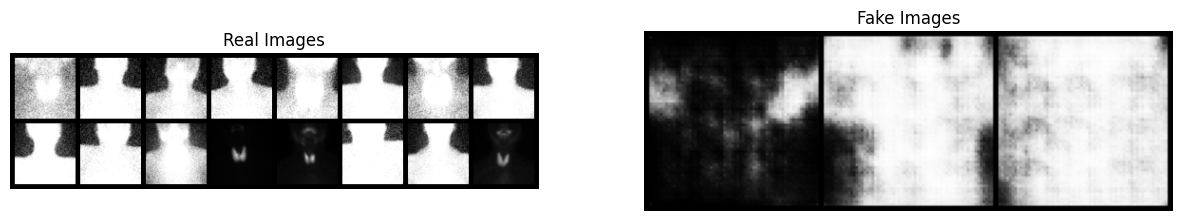

In [ ]:
test2(generator, discriminator, num_epochs, metrics, train_loader)

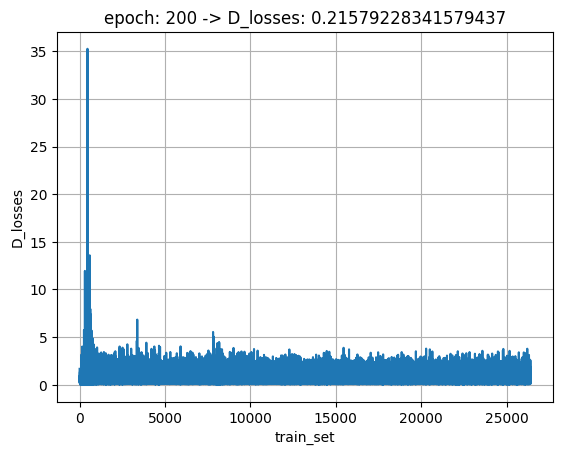

In [ ]:
save_model(generator, discriminator, optimizerG, optimizerD, metrics, num_epochs)

Discriminator s o/p tensor([[0.0004],
        [0.0119],
        [0.2263],
        [0.0038]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Discriminator c o/p tensor([[1.],
        [1.],
        [1.],
        [1.]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


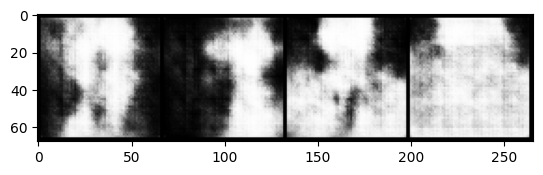

In [ ]:
test_batch = 4
test_fake = 1

if test_fake:
  #check for fake image
  test_img_list = []
  test_noise = torch.randn(test_batch, nz, 1, 1, device=device)
  test_img = generator(test_noise)#.detach().cpu()

else:
  #check for real image
  test_loader = torch.utils.data.DataLoader(train_set, batch_size=test_batch,
                                            shuffle=True)
  data = next(iter(test_loader))
  test_noise, test_class_lable = data
  test_img.data.resize_(test_noise.size()).copy_(test_noise)
  #print(data[0].size())
  print('class label for real', test_class_lable)

s_output,c_label_op = discriminator(test_img.detach().to(device))
print('Discriminator s o/p', s_output)
print('Discriminator c o/p', c_label_op)

# label = np.random.randint(0, nb_label, batch_size)
# c_label.data.resize_(batch_size).copy_(torch.from_numpy(label))
# print(c_label)

test_img = test_img.detach().cpu()
test_img_list.append(vutils.make_grid(test_img, padding=2, normalize=True))
plt.imshow(np.transpose(test_img_list[-1],(1,2,0)))